# FR Test 2

## 数据加载与基本检查

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import os
import warnings
from PIL import Image

# 设置随机种子确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 隐藏警告
warnings.filterwarnings('ignore')

# 创建输出文件夹
os.makedirs('outputs', exist_ok=True)

# 加载数据集
print("正在加载Food-101数据集...")
dataset = load_dataset("ethz/food101")

# 检查数据集结构
print(dataset)

# 查看训练集和验证集数量
print(f"训练集样本数: {len(dataset['train'])}")
print(f"测试集样本数: {len(dataset['validation'])}")

# 获取所有类别
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"类别数量: {num_classes}")

# 查看随机样本
sample_idx = random.randint(0, len(dataset['train'])-1)
sample = dataset['train'][sample_idx]
print("\n随机样本:")
print(f"类别ID: {sample['label']}")
print(f"类别名称: {food_classes[sample['label']]}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在加载Food-101数据集...
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
训练集样本数: 75750
测试集样本数: 25250
类别数量: 101

随机样本:
类别ID: 57
类别名称: hummus


### 图像预处理和可视化

2025-03-31 18:42:33.307954: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-03-31 18:42:33.308002: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-03-31 18:42:33.308005: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-03-31 18:42:33.308025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 18:42:33.308034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


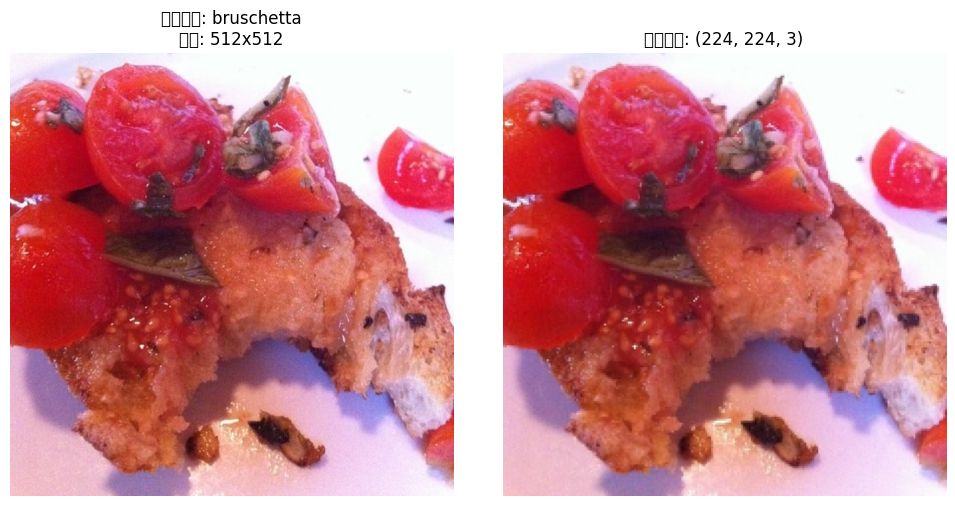


检查图像属性...
图像宽度范围: 440-512, 平均: 504.8
图像高度范围: 306-512, 平均: 478.6
图像通道数: {3}


In [2]:
# 图像预处理函数
def preprocess_image(image, target_size=(224, 224)):
    """
    基本图像预处理：调整大小和标准化
    
    参数:
    - image: PIL图像对象或numpy数组
    - target_size: 目标图像尺寸，默认为224x224
    
    返回:
    - 预处理后的图像数组（归一化到[0,1]范围）
    """
    # 如果输入是PIL图像，转换为numpy数组
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # 如果是灰度图像，转换为RGB
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA图像
        image = image[:, :, :3]
    
    # 转换为TensorFlow张量
    image_tensor = tf.convert_to_tensor(image)
    
    # 调整图像大小
    image_resized = tf.image.resize(image_tensor, target_size)
    
    # 标准化到[0,1]范围
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    return image_normalized

# 测试预处理函数
sample_idx = random.randint(0, len(dataset['train'])-1)
sample_image = dataset['train'][sample_idx]['image']
sample_label = dataset['train'][sample_idx]['label']
sample_class = food_classes[sample_label]

# 预处理图像
processed_image = preprocess_image(sample_image)

# 可视化原始图像和预处理后的图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f"原始图像: {sample_class}\n尺寸: {sample_image.width}x{sample_image.height}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title(f"预处理后: {processed_image.shape}")
plt.axis('off')

plt.tight_layout()
plt.savefig("outputs/preprocessing_example.png")
plt.show()

# 检查一批随机图像的通道和大小
print("\n检查图像属性...")
widths, heights, channels = [], [], []
for i in range(10):
    idx = random.randint(0, len(dataset['train'])-1)
    img = dataset['train'][idx]['image']
    img_array = np.array(img)
    
    widths.append(img.width)
    heights.append(img.height)
    
    if len(img_array.shape) == 2:
        channels.append(1)  # 灰度图像
    else:
        channels.append(img_array.shape[2])  # RGB或RGBA

print(f"图像宽度范围: {min(widths)}-{max(widths)}, 平均: {sum(widths)/len(widths):.1f}")
print(f"图像高度范围: {min(heights)}-{max(heights)}, 平均: {sum(heights)/len(heights):.1f}")
print(f"图像通道数: {set(channels)}")

### 创建TensorFlow数据集

In [3]:
def create_tf_dataset(dataset_split, batch_size=32, is_training=False, shuffle_buffer=10000):
    """
    创建TensorFlow数据集
    
    参数:
    - dataset_split: HuggingFace数据集分割
    - batch_size: 批量大小
    - is_training: 是否为训练模式(决定是否使用数据增强)
    - shuffle_buffer: 用于打乱数据的缓冲区大小
    
    返回:
    - TensorFlow数据集
    """
    def gen():
        # 获取索引并(可选)打乱
        indices = list(range(len(dataset_split)))
        if is_training:
            random.shuffle(indices)
            
        for idx in indices:
            try:
                sample = dataset_split[idx]
                image = sample['image']
                label = sample['label']
                
                # 转换为numpy数组
                image_array = np.array(image)
                
                # 确保图像是RGB (3通道)
                if len(image_array.shape) == 2:  # 灰度图像
                    image_array = np.stack([image_array] * 3, axis=-1)
                elif image_array.shape[-1] == 4:  # RGBA图像
                    image_array = image_array[:, :, :3]
                    
                yield image_array, label
            except Exception as e:
                print(f"处理样本 {idx} 时出错: {e}")
                continue
    
    # 创建数据集
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    
    # 图像预处理
    def _preprocess(image, label):
        # 预处理图像
        image = tf.cast(image, tf.float32) / 255.0
        
        # 调整大小
        image = tf.image.resize(image, (224, 224))
        
        # 数据增强 (仅在训练时)
        if is_training:
            # 随机水平翻转
            image = tf.image.random_flip_left_right(image)
            
            # 随机亮度和对比度 (减小范围以避免过度增强)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            
            # 确保值在[0,1]范围内
            image = tf.clip_by_value(image, 0.0, 1.0)
        
        return image, label
    
    # 应用预处理
    ds = ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 打乱、批处理和预取
    if is_training:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 创建训练和验证数据集
BATCH_SIZE = 32
print("创建训练和验证数据集...")
# 为了测试，先使用少量样本
train_sample_size = 1000
val_sample_size = 200
print(f"使用 {train_sample_size} 个训练样本和 {val_sample_size} 个验证样本进行测试...")

train_ds = create_tf_dataset(
    dataset['train'].select(range(train_sample_size)), 
    batch_size=BATCH_SIZE, 
    is_training=True
)
val_ds = create_tf_dataset(
    dataset['validation'].select(range(val_sample_size)), 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 检查数据集
print("检查数据集...")
for images, labels in train_ds.take(1):
    print(f"批次形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"图像值范围: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")
    print(f"标签类型: {labels.dtype}")
    print(f"标签示例: {labels[:5].numpy()}")

创建训练和验证数据集...
使用 1000 个训练样本和 200 个验证样本进行测试...
检查数据集...
批次形状: (32, 224, 224, 3)
标签形状: (32,)
图像值范围: [0.0, 1.0]
标签类型: <dtype: 'int64'>
标签示例: [6 6 6 6 6]


2025-03-31 18:43:28.107766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 创建模型（使用迁移学习）

In [4]:
def build_model(num_classes=101, freeze_base=True):
    """
    构建基于ResNet50的模型
    
    参数:
    - num_classes: 分类数量
    - freeze_base: 是否冻结ResNet50的权重
    
    返回:
    - 编译好的模型
    """
    # 加载预训练的ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # 设置基础模型是否可训练
    base_model.trainable = not freeze_base
    
    # 如果部分解冻，只解冻最后的一些层
    if not freeze_base:
        # 冻结前面的层，只训练后面的层
        for layer in base_model.layers[:-30]:
            layer.trainable = False
    
    # 构建完整模型
    model = tf.keras.Sequential([
        # 预处理层
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x * 255.0)),
        
        # 基础模型
        base_model,
        
        # 分类头
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# 创建模型
NUM_CLASSES = len(food_classes)
print(f"创建含有 {NUM_CLASSES} 个分类的模型...")
model, base_model = build_model(num_classes=NUM_CLASSES, freeze_base=True)

# 显示模型结构
model.summary()

# 查看可训练参数数量
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'可训练参数: {trainable_count:,}')
print(f'不可训练参数: {non_trainable_count:,}')
print(f'总参数: {trainable_count + non_trainable_count:,}')

创建含有 101 个分类的模型...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,405 (92.11 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

可训练参数: 554,597
不可训练参数: 23,591,808
总参数: 24,146,405


### 第一阶段训练

创建完整训练和验证数据集...
使用 5000 个训练样本和 1000 个验证样本...
开始第一阶段训练 (冻结基础模型)...
Epoch 1/8


2025-03-31 18:45:29.818457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    157/Unknown 21s 70ms/step - accuracy: 0.6365 - loss: 2.1675

2025-03-31 18:45:50.365685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:45:50.365709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_24]]
2025-03-31 18:45:50.365722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-03-31 18:45:50.365728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12381487750122714635
2025-03-31 18:45:50.365732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14025633426652666449
2025-03-31 18:45:50.365733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-


Epoch 1: val_accuracy improved from -inf to 0.91800, saving model to outputs/food101_best_model_stage1.h5


2025-03-31 18:45:54.584783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:45:54.584803: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:45:54.584839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.6372 - loss: 2.1630 - val_accuracy: 0.9180 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 2/8
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8240 - loss: 0.8988

2025-03-31 18:46:10.147622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:10.147642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-31 18:46:10.147645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 18:46:10.147649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 18:46:10.147651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8574275456396016584
2025-03-31 18:46:10.147656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-


Epoch 2: val_accuracy improved from 0.91800 to 0.93300, saving model to outputs/food101_best_model_stage1.h5


2025-03-31 18:46:11.980631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:11.980654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:46:11.980665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930339194495162943
2025-03-31 18:46:11.980668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 18:46:11.980670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-03-31 18:46:11.980672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.8242 - loss: 0.8983 - val_accuracy: 0.9330 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 3/8
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8565 - loss: 0.6798

2025-03-31 18:46:26.942888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:26.942910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-31 18:46:26.942919: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2502159073209032852
2025-03-31 18:46:26.942921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_4/_36]]
2025-03-31 18:46:26.942930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 18:46:26.942936: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 85950738920


Epoch 3: val_accuracy improved from 0.93300 to 0.94000, saving model to outputs/food101_best_model_stage1.h5


2025-03-31 18:46:28.773500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:28.773524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:46:28.773528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.8564 - loss: 0.6801 - val_accuracy: 0.9400 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 4/8
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8796 - loss: 0.5476

2025-03-31 18:46:43.606648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:43.606666: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 18:46:43.606672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-31 18:46:43.606675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 18:46:43.606678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 18:46:43.606692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-03-


Epoch 4: val_accuracy did not improve from 0.94000
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8795 - loss: 0.5487 - val_accuracy: 0.9300 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 5/8


2025-03-31 18:46:45.551296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:46:45.551313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:46:45.551324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930339194495162943
2025-03-31 18:46:45.551326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 18:46:45.551329: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-03-31 18:46:45.551331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8870 - loss: 0.5459

2025-03-31 18:47:00.778941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:47:00.778960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 18:47:00.778967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-31 18:47:00.778970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 18:47:00.778975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8574275456396016584
2025-03-31 18:47:00.778978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 686695507846470478
2025-03-31 18:47:00.778980: W tensorflow/core/framework/local_rendezvo


Epoch 5: val_accuracy did not improve from 0.94000

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.8868 - loss: 0.5463 - val_accuracy: 0.9330 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 6/8


2025-03-31 18:47:02.808846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:47:02.808861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:47:02.808868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930339194495162943
2025-03-31 18:47:02.808870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 18:47:02.808874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-03-31 18:47:02.808877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8910 - loss: 0.4758

2025-03-31 18:47:17.750415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_44]]
2025-03-31 18:47:17.750429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1560171369638740058
2025-03-31 18:47:17.750436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2502159073209032852
2025-03-31 18:47:17.750440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12649573610884473150
2025-03-31 18:47:17.750445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 18:47:17.750448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6: val_accuracy did not improve from 0.94000
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.8910 - loss: 0.4753 - val_accuracy: 0.9350 - val_loss: 0.3157 - learning_rate: 2.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


2025-03-31 18:47:19.770975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:47:19.770994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:47:19.771010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:47:19.771021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589


第一阶段模型已保存
第一阶段最终训练准确率: 0.8934
第一阶段最终验证准确率: 0.9350


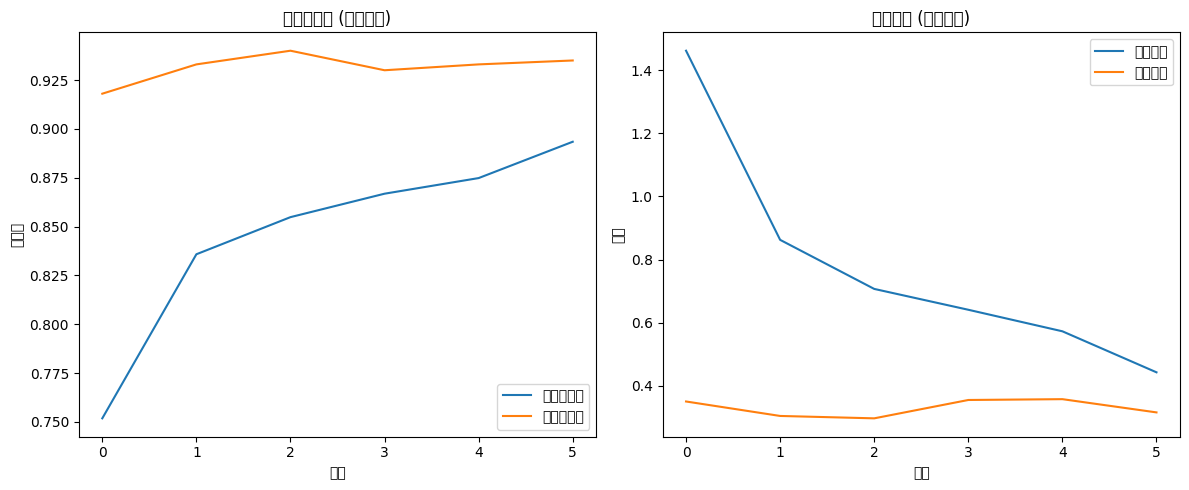

In [5]:
# 设置训练参数
EPOCHS_STAGE1 = 8  # 第一阶段先训练少量轮次
STEPS_PER_EPOCH = None  # 使用None会自动计算步数

# 设置回调函数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage1.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 重新创建完整数据集 (现在我们确认数据管道工作正常，使用更多样本)
print("创建完整训练和验证数据集...")
# 使用一部分数据集进行快速训练
train_size = 5000  # 每类约50张图像
val_size = 1000    # 每类约10张图像

print(f"使用 {train_size} 个训练样本和 {val_size} 个验证样本...")

train_full_ds = create_tf_dataset(
    dataset['train'].select(range(train_size)), 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=train_size
)
val_full_ds = create_tf_dataset(
    dataset['validation'].select(range(val_size)), 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 第一阶段：冻结基础模型训练
print("开始第一阶段训练 (冻结基础模型)...")
history1 = model.fit(
    train_full_ds,
    epochs=EPOCHS_STAGE1,
    validation_data=val_full_ds,
    callbacks=callbacks,
    verbose=1
)

# 保存第一阶段训练结果
model.save('outputs/food101_stage1_model.h5')
print("第一阶段模型已保存")

# 显示训练结果
final_train_acc = history1.history['accuracy'][-1]
final_val_acc = history1.history['val_accuracy'][-1]
print(f"第一阶段最终训练准确率: {final_train_acc:.4f}")
print(f"第一阶段最终验证准确率: {final_val_acc:.4f}")

# 可视化第一阶段训练历史
plt.figure(figsize=(12, 5))

# 绘制准确率
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='训练准确率')
plt.plot(history1.history['val_accuracy'], label='验证准确率')
plt.title('模型准确率 (第一阶段)')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend()

# 绘制损失
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='训练损失')
plt.plot(history1.history['val_loss'], label='验证损失')
plt.title('模型损失 (第一阶段)')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend()

plt.tight_layout()
plt.savefig('outputs/training_history_stage1.png')
plt.show()

### 第二阶段训练，解冻部分基础模型进行微调


开始第二阶段训练 (解冻部分基础模型)...
解冻ResNet50的最后30层...
ResNet50基础模型共有 175 层，其中 30 层被设为可训练
重新创建训练和验证数据集...
使用 10000 个训练样本和 2000 个验证样本...
开始第二阶段训练，共 10 轮...
Epoch 1/10
    313/Unknown 37s 75ms/step - accuracy: 0.5910 - loss: 3.0595

2025-03-31 18:49:40.840810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:49:40.840827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 18:49:40.840830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 18:49:40.840833: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15491016918715589946
2025-03-31 18:49:40.840835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:49:40.840838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 18:49:40.840840: I tensorflow/core/framework/local_rende


Epoch 1: val_accuracy improved from -inf to 0.86200, saving model to outputs/food101_best_model_stage2.h5


2025-03-31 18:49:45.814006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:49:45.814022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:49:45.814029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.5914 - loss: 3.0556 - val_accuracy: 0.8620 - val_loss: 0.5136 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8562 - loss: 0.6251

2025-03-31 18:50:17.035654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:50:17.035669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 18:50:17.035672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:50:17.035675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 18:50:17.035677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 18:50:17.035679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11890923380957104980
2025-03-31 18:50:17.035681: I tensorflow/core/framework/local_rende


Epoch 2: val_accuracy improved from 0.86200 to 0.89350, saving model to outputs/food101_best_model_stage2.h5


2025-03-31 18:50:21.401859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:50:21.401873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:50:21.401887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8562 - loss: 0.6250 - val_accuracy: 0.8935 - val_loss: 0.4228 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9033 - loss: 0.3771

2025-03-31 18:50:52.743601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:50:52.743614: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:50:52.743617: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 18:50:52.743620: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 18:50:52.743622: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14497097978216089918
2025-03-31 18:50:52.743624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11890923380957104980
2025-03-31 18:50:52.743626: I tensorflow/core/framework/local_rend


Epoch 3: val_accuracy did not improve from 0.89350
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.9033 - loss: 0.3771 - val_accuracy: 0.8745 - val_loss: 0.4931 - learning_rate: 1.0000e-04
Epoch 4/10


2025-03-31 18:50:56.355453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:50:56.355468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:50:56.355480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9302 - loss: 0.2720

2025-03-31 18:51:27.354281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:51:27.354293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_102]]
2025-03-31 18:51:27.354308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3875798619193924172
2025-03-31 18:51:27.354310: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:51:27.354316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17202846021021546460
2025-03-31 18:51:27.354320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9519759


Epoch 4: val_accuracy did not improve from 0.89350

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.9302 - loss: 0.2721 - val_accuracy: 0.8860 - val_loss: 0.4887 - learning_rate: 1.0000e-04
Epoch 5/10


2025-03-31 18:51:30.694640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:51:30.694654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:51:30.694669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9524 - loss: 0.1698

2025-03-31 18:52:03.533507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:52:03.533522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3875798619193924172
2025-03-31 18:52:03.533526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 18:52:03.533529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 18:52:03.533532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15491016918715589946
2025-03-31 18:52:03.533534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:52:03.533537: I tensorflow/core/framework/local_rendez


Epoch 5: val_accuracy improved from 0.89350 to 0.89650, saving model to outputs/food101_best_model_stage2.h5


2025-03-31 18:52:07.950912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:52:07.950931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:52:07.950937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9524 - loss: 0.1698 - val_accuracy: 0.8965 - val_loss: 0.4080 - learning_rate: 2.0000e-05
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9673 - loss: 0.1098

2025-03-31 18:52:42.355084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:52:42.355098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:52:42.355102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 18:52:42.355105: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:52:42.355108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 18:52:42.355110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14497097978216089918
2025-03-31 18:52:42.355121: I tensorflow/core/framework/local_rende


Epoch 6: val_accuracy improved from 0.89650 to 0.90400, saving model to outputs/food101_best_model_stage2.h5


2025-03-31 18:52:46.213080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:52:46.213099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:52:46.213116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9673 - loss: 0.1098 - val_accuracy: 0.9040 - val_loss: 0.4015 - learning_rate: 2.0000e-05
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9750 - loss: 0.0770

2025-03-31 18:53:20.044906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:53:20.044920: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:53:20.044923: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 18:53:20.044927: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 18:53:20.044929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11890923380957104980
2025-03-31 18:53:20.044932: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12111939211950976678
2025-03-31 18:53:20.044934: I tensorflow/core/framework/local_rend


Epoch 7: val_accuracy did not improve from 0.90400
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.9750 - loss: 0.0771 - val_accuracy: 0.8960 - val_loss: 0.4125 - learning_rate: 2.0000e-05
Epoch 8/10


2025-03-31 18:53:23.767806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:53:23.767823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:53:23.767833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9775 - loss: 0.0762

2025-03-31 18:53:56.506436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:53:56.506451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 18:53:56.506455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:53:56.506458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 18:53:56.506461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 18:53:56.506463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:53:56.506465: I tensorflow/core/framework/local_rendez


Epoch 8: val_accuracy did not improve from 0.90400
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.9775 - loss: 0.0761 - val_accuracy: 0.9030 - val_loss: 0.4002 - learning_rate: 2.0000e-05
Epoch 9/10


2025-03-31 18:54:00.078910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:54:00.078925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:54:00.078933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9811 - loss: 0.0576

2025-03-31 18:54:32.036228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:54:32.036240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:54:32.036244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 18:54:32.036246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_94]]
2025-03-31 18:54:32.036254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:54:32.036258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03


Epoch 9: val_accuracy improved from 0.90400 to 0.90550, saving model to outputs/food101_best_model_stage2.h5


2025-03-31 18:54:35.444464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:54:35.444479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760
2025-03-31 18:54:35.444497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.9811 - loss: 0.0577 - val_accuracy: 0.9055 - val_loss: 0.4162 - learning_rate: 2.0000e-05
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9839 - loss: 0.0470

2025-03-31 18:55:07.364285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:55:07.364298: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 18:55:07.364300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 18:55:07.364303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 18:55:07.364305: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15491016918715589946
2025-03-31 18:55:07.364307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-03-31 18:55:07.364310: I tensorflow/core/framework/local_rendez


Epoch 10: val_accuracy did not improve from 0.90550

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.9839 - loss: 0.0470 - val_accuracy: 0.9000 - val_loss: 0.4344 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.


2025-03-31 18:55:10.659940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 18:55:10.659951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 18:55:10.659967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6150865227286064760


最终模型已保存
第二阶段最终训练准确率: 0.9834
第二阶段最终验证准确率: 0.9000
第二阶段最佳验证准确率: 0.9055


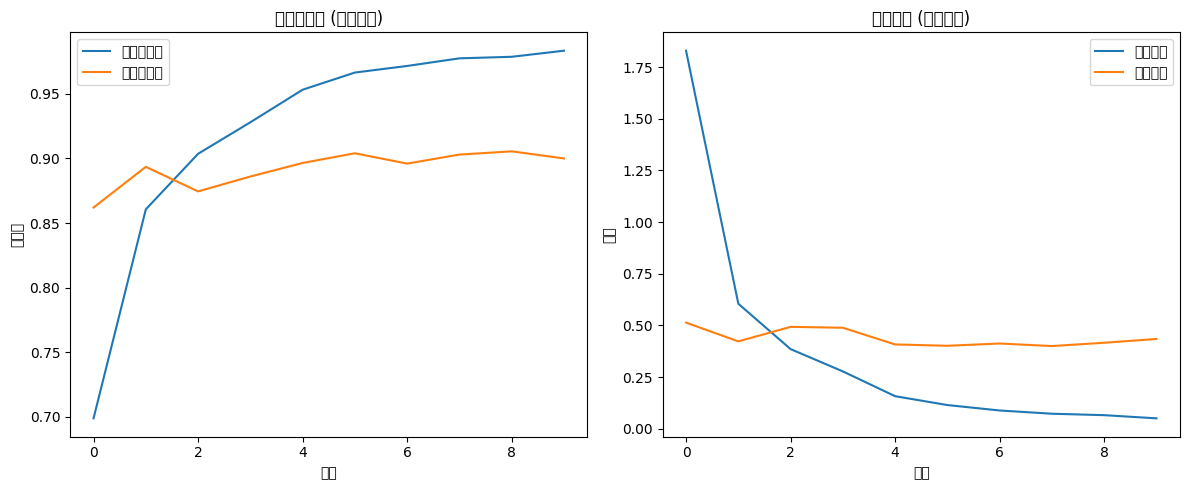

In [7]:
# 第二阶段：解冻部分基础模型进行微调
print("\n开始第二阶段训练 (解冻部分基础模型)...")

# 获取ResNet50基础模型 (使用当前模型而不是加载)
base_model = model.layers[1]  # 索引0是Lambda层，1是ResNet50

# 解冻部分基础模型
base_model.trainable = True

# 冻结前面的层，只训练最后的30层
print("解冻ResNet50的最后30层...")
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 查看有多少层被解冻
trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
total_layers = len(base_model.layers)
print(f"ResNet50基础模型共有 {total_layers} 层，其中 {trainable_layers} 层被设为可训练")

# 使用较小的学习率重新编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 降低学习率进行微调
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 设置第二阶段回调
callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage2.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 重新创建训练和验证数据集
print("重新创建训练和验证数据集...")
# 使用更多样本但仍然保持较小规模以便快速训练
train_size = 10000  # 增加训练样本数
val_size = 2000    # 增加验证样本数

print(f"使用 {train_size} 个训练样本和 {val_size} 个验证样本...")

train_stage2_ds = create_tf_dataset(
    dataset['train'].select(range(train_size)), 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=train_size
)
val_stage2_ds = create_tf_dataset(
    dataset['validation'].select(range(val_size)), 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 第二阶段训练
EPOCHS_STAGE2 = 10
print(f"开始第二阶段训练，共 {EPOCHS_STAGE2} 轮...")

history2 = model.fit(
    train_stage2_ds,
    epochs=EPOCHS_STAGE2,
    validation_data=val_stage2_ds,
    callbacks=callbacks_stage2,
    verbose=1
)

# 保存最终模型
model.save('outputs/food101_final_model.h5')
print("最终模型已保存")

# 显示第二阶段训练结果
final_train_acc = history2.history['accuracy'][-1]
final_val_acc = history2.history['val_accuracy'][-1]
best_val_acc = max(history2.history['val_accuracy'])
print(f"第二阶段最终训练准确率: {final_train_acc:.4f}")
print(f"第二阶段最终验证准确率: {final_val_acc:.4f}")
print(f"第二阶段最佳验证准确率: {best_val_acc:.4f}")

# 可视化第二阶段训练历史
plt.figure(figsize=(12, 5))

# 绘制准确率
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='训练准确率')
plt.plot(history2.history['val_accuracy'], label='验证准确率')
plt.title('模型准确率 (第二阶段)')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend()

# 绘制损失
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='训练损失')
plt.plot(history2.history['val_loss'], label='验证损失')
plt.title('模型损失 (第二阶段)')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend()

plt.tight_layout()
plt.savefig('outputs/training_history_stage2.png')
plt.show()

## 改进1： 随机抽样并增加到30,000个训练样本

正在加载Food-101数据集...
训练集样本数: 75750
测试集样本数: 25250
类别数量: 101
随机抽样选择训练和验证样本...
已随机选择 30000 个训练样本和 5000 个验证样本
随机抽样中检测到的类别数: 101 (应该接近101)
创建训练和验证数据集...
检查数据集...


2025-03-31 19:39:36.557618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 13331 of 30000
2025-03-31 19:39:48.733820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


批次形状: (32, 224, 224, 3)
标签形状: (32,)
图像值范围: [0.0, 1.0]


2025-03-31 19:39:49.439931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


创建含有 101 个分类的模型...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,405 (92.11 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

开始第一阶段训练 (冻结基础模型)...
Epoch 1/10


2025-03-31 19:40:01.858953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 13049 of 30000
2025-03-31 19:40:14.234225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    938/Unknown 72s 50ms/step - accuracy: 0.2209 - loss: 4.5414

2025-03-31 19:41:02.514556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:41:02.514571: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:41:02.514574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:41:02.514577: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3939457569041279434
2025-03-31 19:41:02.514580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 19:41:02.514583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03


Epoch 1: val_accuracy improved from -inf to 0.54800, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:41:15.025004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:41:15.025018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:41:15.025057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - accuracy: 0.2210 - loss: 4.5408 - val_accuracy: 0.5480 - val_loss: 1.8952 - learning_rate: 0.0010
Epoch 2/10


2025-03-31 19:41:25.505236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12646 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:02:03 23s/step - accuracy: 0.4375 - loss: 3.1140

2025-03-31 19:41:38.510962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3954 - loss: 3.2476

2025-03-31 19:42:25.512146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:42:25.512162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:42:25.512170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:42:25.512188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 19:42:25.512194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5382716216687312511
2025-03-31 19:42:25.512197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14025633426652666449
2025-03-


Epoch 2: val_accuracy did not improve from 0.54800
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.3954 - loss: 3.2476 - val_accuracy: 0.5364 - val_loss: 1.9339 - learning_rate: 0.0010
Epoch 3/10


2025-03-31 19:42:33.281808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:42:33.281823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:42:33.281862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 19:42:43.301123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12463 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.3837 - loss: 3.7045

2025-03-31 19:42:56.494828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4220 - loss: 3.0329

2025-03-31 19:43:50.060283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:43:50.060298: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:43:50.060303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:43:50.060306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3939457569041279434
2025-03-31 19:43:50.060309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 19:43:50.060310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03


Epoch 3: val_accuracy improved from 0.54800 to 0.55420, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:44:01.000719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:44:01.000735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:44:01.000767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 69ms/step - accuracy: 0.4220 - loss: 3.0330 - val_accuracy: 0.5542 - val_loss: 1.8566 - learning_rate: 0.0010
Epoch 4/10


2025-03-31 19:44:11.354932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12577 of 30000
2025-03-31 19:44:21.355432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 26006 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 5:58:33 23s/step - accuracy: 0.4375 - loss: 2.7314

2025-03-31 19:44:24.146254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4380 - loss: 2.9392

2025-03-31 19:45:12.279607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:45:12.279626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-03-31 19:45:12.279644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-03-31 19:45:12.279651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9271583146452975261
2025-03-31 19:45:12.279654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13493888286703882823
2025-03-31 19:45:12.279659: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8595073892


Epoch 4: val_accuracy improved from 0.55420 to 0.55760, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:45:21.153353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:45:21.153369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:45:21.153401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.4380 - loss: 2.9394 - val_accuracy: 0.5576 - val_loss: 1.8345 - learning_rate: 0.0010
Epoch 5/10


2025-03-31 19:45:31.522010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12426 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:03:35 23s/step - accuracy: 0.3750 - loss: 3.2947

2025-03-31 19:45:44.643195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4409 - loss: 2.9182

2025-03-31 19:46:31.981301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:46:31.981315: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:46:31.981325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:46:31.981328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:46:31.981341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 19:46:31.981346: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5382716216687312511
2025-03-


Epoch 5: val_accuracy did not improve from 0.55760
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.4409 - loss: 2.9184 - val_accuracy: 0.5452 - val_loss: 1.9851 - learning_rate: 0.0010
Epoch 6/10


2025-03-31 19:46:41.227810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:46:41.227827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:46:41.227869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 19:46:51.242852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12457 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.3993 - loss: 3.2968   

2025-03-31 19:47:04.276905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4349 - loss: 3.0509

2025-03-31 19:47:51.589844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:47:51.589858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:47:51.589866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:47:51.589869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3939457569041279434
2025-03-31 19:47:51.589871: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03-31 19:47:51.589873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 686695507846470478
2025-03-31 19:47:51.589876: I tensorflow/core/framework/local_rendezv


Epoch 6: val_accuracy did not improve from 0.55760

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.4349 - loss: 3.0511 - val_accuracy: 0.5556 - val_loss: 1.9612 - learning_rate: 0.0010
Epoch 7/10


2025-03-31 19:48:02.096779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:48:02.096795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:48:02.096830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 19:48:12.114173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12234 of 30000
2025-03-31 19:48:22.114282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25352 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.3733 - loss: 3.6079

2025-03-31 19:48:25.375483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4833 - loss: 2.6318

2025-03-31 19:49:12.450518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:49:12.450531: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:49:12.450534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:49:12.450535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:49:12.450544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 19:49:12.450546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3939457569041279434
2025-03-


Epoch 7: val_accuracy improved from 0.55760 to 0.61940, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:49:22.764702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:49:22.764717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:49:22.764752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.4834 - loss: 2.6316 - val_accuracy: 0.6194 - val_loss: 1.5126 - learning_rate: 2.0000e-04
Epoch 8/10


2025-03-31 19:49:33.133423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12407 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.5677 - loss: 2.0412

2025-03-31 19:49:46.164768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5198 - loss: 2.2329

2025-03-31 19:50:33.272420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:50:33.272445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:50:33.272448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:50:33.272467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8854019267947456606
2025-03-31 19:50:33.272475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:50:33.272492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13527000019862465214
2025-03


Epoch 8: val_accuracy improved from 0.61940 to 0.63120, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:50:43.968531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:50:43.968546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:50:43.968590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.5199 - loss: 2.2328 - val_accuracy: 0.6312 - val_loss: 1.4351 - learning_rate: 2.0000e-04
Epoch 9/10


2025-03-31 19:50:54.330391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12469 of 30000
2025-03-31 19:51:04.330900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25611 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.5920 - loss: 2.1209   

2025-03-31 19:51:07.432450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5394 - loss: 2.0415

2025-03-31 19:51:53.880223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:51:53.880239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:51:53.880244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:51:53.880263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 19:51:53.880267: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5382716216687312511
2025-03-31 19:51:53.880269: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14025633426652666449
2025-03-


Epoch 9: val_accuracy improved from 0.63120 to 0.63500, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:52:04.187585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:52:04.187600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:52:04.187642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.5394 - loss: 2.0415 - val_accuracy: 0.6350 - val_loss: 1.3988 - learning_rate: 2.0000e-04
Epoch 10/10


2025-03-31 19:52:14.542266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12510 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.6667 - loss: 1.4717

2025-03-31 19:52:27.548435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5543 - loss: 1.8956

2025-03-31 19:53:14.231566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:53:14.231585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18102315653605798038
2025-03-31 19:53:14.231588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-03-31 19:53:14.231591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-03-31 19:53:14.231607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-03-31 19:53:14.231609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3939457569041279434
2025-03-


Epoch 10: val_accuracy improved from 0.63500 to 0.63720, saving model to outputs/food101_best_model_stage1.keras


2025-03-31 19:53:24.478728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:53:24.478744: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:53:24.478780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.5543 - loss: 1.8957 - val_accuracy: 0.6372 - val_loss: 1.3638 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
第一阶段训练完成，耗时: 814.75 秒
第一阶段模型已保存

开始第二阶段训练 (解冻部分基础模型)...
解冻ResNet50的最后30层...
ResNet50基础模型共有 175 层，其中 30 层被设为可训练
开始第二阶段训练，共 15 轮...
Epoch 1/15


2025-03-31 19:53:38.278758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12324 of 30000
2025-03-31 19:53:51.417976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    938/Unknown 98s 75ms/step - accuracy: 0.5271 - loss: 2.0151

2025-03-31 19:55:03.015129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:55:03.015187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_94]]
2025-03-31 19:55:03.015312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 19:55:03.015319: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9519759123930963999
2025-03-31 19:55:03.015323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8129713881643180091
2025-03-31 19:55:03.015326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-03-


Epoch 1: val_accuracy improved from -inf to 0.65460, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 19:55:14.407812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:55:14.407828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-03-31 19:55:14.407835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 19:55:14.407839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-03-31 19:55:14.407850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133


938/938 ━━━━━━━━━━━━━━━━━━━━ 109s 87ms/step - accuracy: 0.5271 - loss: 2.0151 - val_accuracy: 0.6546 - val_loss: 1.3080 - learning_rate: 1.0000e-04
Epoch 2/15


2025-03-31 19:55:24.954878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12646 of 30000
2025-03-31 19:55:38.008061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6186 - loss: 1.5011

2025-03-31 19:56:50.093291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:56:50.093307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 19:56:50.093312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/dropout_2_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_250]]
2025-03-31 19:56:50.093326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-03-31 19:56:50.093331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10250745231127331923
2025-03-31 19:56:50.093334: I tensorflow/core/fr


Epoch 2: val_accuracy improved from 0.65460 to 0.67700, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 19:57:00.870289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:57:00.870308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 19:57:00.870323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133


938/938 ━━━━━━━━━━━━━━━━━━━━ 106s 88ms/step - accuracy: 0.6186 - loss: 1.5011 - val_accuracy: 0.6770 - val_loss: 1.2220 - learning_rate: 1.0000e-04
Epoch 3/15


2025-03-31 19:57:11.335331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12400 of 30000
2025-03-31 19:57:24.564252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6775 - loss: 1.2497

2025-03-31 19:58:37.863747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:58:37.863762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_34/_128]]
2025-03-31 19:58:37.863773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 19:58:37.863776: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-03-31 19:58:37.863784: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 19:58:37.863791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 102507


Epoch 3: val_accuracy improved from 0.67700 to 0.68660, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 19:58:47.387635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 19:58:47.387653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 19:58:47.387659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 106s 88ms/step - accuracy: 0.6775 - loss: 1.2497 - val_accuracy: 0.6866 - val_loss: 1.2085 - learning_rate: 1.0000e-04
Epoch 4/15


2025-03-31 19:58:57.829105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12441 of 30000
2025-03-31 19:59:07.828839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25589 of 30000
2025-03-31 19:59:11.065581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7217 - loss: 1.0266

2025-03-31 20:00:20.277736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:00:20.277760: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:00:20.277764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:00:20.277766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 20:00:20.277768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 20:00:20.277770: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 20:00:20.277772: I tensorflow/core/framework/local_rende


Epoch 4: val_accuracy improved from 0.68660 to 0.69500, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:00:29.477147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:00:29.477160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 20:00:29.477175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133


938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 84ms/step - accuracy: 0.7217 - loss: 1.0267 - val_accuracy: 0.6950 - val_loss: 1.1671 - learning_rate: 1.0000e-04
Epoch 5/15


2025-03-31 20:00:39.906512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12568 of 30000
2025-03-31 20:00:53.617701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7600 - loss: 0.8680

2025-03-31 20:02:04.997770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:02:04.997793: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10083259155808890986
2025-03-31 20:02:04.997797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:02:04.997807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12111939211950976678
2025-03-31 20:02:04.997810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_72/_170]]
2025-03-31 20:02:04.997813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9519759


Epoch 5: val_accuracy improved from 0.69500 to 0.70560, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:02:14.385270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:02:14.385288: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:02:14.385293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 86ms/step - accuracy: 0.7600 - loss: 0.8680 - val_accuracy: 0.7056 - val_loss: 1.1726 - learning_rate: 1.0000e-04
Epoch 6/15


2025-03-31 20:02:24.831893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12464 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:02:42 23s/step - accuracy: 0.8438 - loss: 0.5231

2025-03-31 20:02:37.965152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7996 - loss: 0.7162

2025-03-31 20:03:49.107314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:03:49.107328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:03:49.107331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:03:49.107333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:03:49.107335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 20:03:49.107337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 20:03:49.107339: I tensorflow/core/framework/local_rendez


Epoch 6: val_accuracy did not improve from 0.70560

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 85ms/step - accuracy: 0.7996 - loss: 0.7162 - val_accuracy: 0.6956 - val_loss: 1.2074 - learning_rate: 1.0000e-04
Epoch 7/15


2025-03-31 20:03:57.714480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:03:57.714496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 20:03:57.714517: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:04:07.730101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12512 of 30000


  2/938 ━━━━━━━━━━━━━━━━━━━━ 1:10 75ms/step - accuracy: 0.8516 - loss: 0.4200  

2025-03-31 20:04:20.838515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8471 - loss: 0.5333

2025-03-31 20:05:31.958509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:05:31.958518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_32/_126]]
2025-03-31 20:05:31.958538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-03-31 20:05:31.958542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4022178602180832340
2025-03-31 20:05:31.958545: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-03-31 20:05:31.958547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402


Epoch 7: val_accuracy improved from 0.70560 to 0.72900, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:05:40.967944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:05:40.967960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:05:40.967965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0.8471 - loss: 0.5333 - val_accuracy: 0.7290 - val_loss: 1.0648 - learning_rate: 2.0000e-05
Epoch 8/15


2025-03-31 20:05:51.411905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12407 of 30000
2025-03-31 20:06:04.553186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8867 - loss: 0.3968

2025-03-31 20:07:16.833276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:07:16.833293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10083259155808890986
2025-03-31 20:07:16.833296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:07:16.833299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14375174295976293080
2025-03-31 20:07:16.833301: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 20:07:16.833303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6875917095853225764
2025-03-31 20:07:16.833305: I tensorflow/core/framework/local_rende


Epoch 8: val_accuracy improved from 0.72900 to 0.72980, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:07:25.848744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:07:25.848759: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:07:25.848766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 86ms/step - accuracy: 0.8867 - loss: 0.3968 - val_accuracy: 0.7298 - val_loss: 1.0730 - learning_rate: 2.0000e-05
Epoch 9/15


2025-03-31 20:07:36.304408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12647 of 30000
2025-03-31 20:07:46.304423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25781 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:02:20 23s/step - accuracy: 0.9062 - loss: 0.2614

2025-03-31 20:07:49.332466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8999 - loss: 0.3424

2025-03-31 20:09:02.230337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:09:02.230357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:09:02.230360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:09:02.230363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:09:02.230369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 20:09:02.230510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/A


Epoch 9: val_accuracy did not improve from 0.72980

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 88ms/step - accuracy: 0.8999 - loss: 0.3424 - val_accuracy: 0.7272 - val_loss: 1.0740 - learning_rate: 2.0000e-05
Epoch 10/15


2025-03-31 20:09:11.664811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:09:11.664824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 20:09:11.664840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:09:21.681189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12557 of 30000
2025-03-31 20:09:31.681664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25478 of 30000
2025-03-31 20:09:34.930906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9155 - loss: 0.2924

2025-03-31 20:10:48.096201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:10:48.096222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10083259155808890986
2025-03-31 20:10:48.096233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_74/_172]]
2025-03-31 20:10:48.096242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:10:48.096250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:10:48.096258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302


Epoch 10: val_accuracy improved from 0.72980 to 0.73280, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:10:56.035636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:10:56.035654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 20:10:56.035661: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930339194495162943
2025-03-31 20:10:56.035664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 20:10:56.035666: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:10:56.035669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656


938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 87ms/step - accuracy: 0.9155 - loss: 0.2924 - val_accuracy: 0.7328 - val_loss: 1.0647 - learning_rate: 4.0000e-06
Epoch 11/15


2025-03-31 20:11:06.498598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12597 of 30000
2025-03-31 20:11:16.498866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 25639 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:03:38 23s/step - accuracy: 0.8125 - loss: 0.3829

2025-03-31 20:11:19.646711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9241 - loss: 0.2664

2025-03-31 20:12:30.709144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:12:30.709156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:12:30.709159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:12:30.709162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:12:30.709164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-03-31 20:12:30.709176: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-03-31 20:12:30.709183: I tensorflow/core/framework/local_rendez


Epoch 11: val_accuracy did not improve from 0.73280
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 85ms/step - accuracy: 0.9241 - loss: 0.2664 - val_accuracy: 0.7310 - val_loss: 1.0660 - learning_rate: 4.0000e-06
Epoch 12/15


2025-03-31 20:12:39.047240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:12:39.047257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-03-31 20:12:39.047262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:12:39.047267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-31 20:12:49.063882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12346 of 30000
2025-03-31 20:12:59.063887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer 

  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:13:13 24s/step - accuracy: 1.0000 - loss: 0.1340

2025-03-31 20:13:02.829373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9314 - loss: 0.2480

2025-03-31 20:14:13.673755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:14:13.673771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:14:13.673774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:14:13.673777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_72/_170]]
2025-03-31 20:14:13.673779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:14:13.673782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14497097


Epoch 12: val_accuracy improved from 0.73280 to 0.73440, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:14:22.870232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:14:22.870251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:14:22.870256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0.9314 - loss: 0.2480 - val_accuracy: 0.7344 - val_loss: 1.0709 - learning_rate: 4.0000e-06
Epoch 13/15


2025-03-31 20:14:33.293655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12549 of 30000
2025-03-31 20:14:46.644908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9314 - loss: 0.2370

2025-03-31 20:15:57.804091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:15:57.804108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10083259155808890986
2025-03-31 20:15:57.804111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-03-31 20:15:57.804113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:15:57.804116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14375174295976293080
2025-03-31 20:15:57.804118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6875917095853225764
2025-03-31 20:15:57.804120: I tensorflow/core/framework/local_rendez


Epoch 13: val_accuracy improved from 0.73440 to 0.73460, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:16:08.197179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:16:08.197195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:16:08.197204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 87ms/step - accuracy: 0.9314 - loss: 0.2370 - val_accuracy: 0.7346 - val_loss: 1.0709 - learning_rate: 1.0000e-06
Epoch 14/15


2025-03-31 20:16:18.657878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12518 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:03:58 23s/step - accuracy: 0.9062 - loss: 0.2580

2025-03-31 20:16:31.777404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9338 - loss: 0.2352

2025-03-31 20:17:43.174853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:17:43.174867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_72/_170]]
2025-03-31 20:17:43.174875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7929524531403559868
2025-03-31 20:17:43.174878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9519759123930963999
2025-03-31 20:17:43.174882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10250745231127331923
2025-03-31 20:17:43.174883: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 54954021


Epoch 14: val_accuracy did not improve from 0.73460
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 85ms/step - accuracy: 0.9338 - loss: 0.2352 - val_accuracy: 0.7342 - val_loss: 1.0695 - learning_rate: 1.0000e-06
Epoch 15/15


2025-03-31 20:17:51.691702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:17:51.691722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:17:51.691730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-31 20:18:01.708845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:190: Filling up shuffle buffer (this may take a while): 12470 of 30000
2025-03-31 20:18:15.145336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9350 - loss: 0.2377

2025-03-31 20:19:27.668605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:19:27.668628: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10083259155808890986
2025-03-31 20:19:27.668631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-03-31 20:19:27.668633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14375174295976293080
2025-03-31 20:19:27.668636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-03-31 20:19:27.668638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16251107495970673720
2025-03-31 20:19:27.668640: I tensorflow/core/framework/local_rendez


Epoch 15: val_accuracy improved from 0.73460 to 0.73520, saving model to outputs/food101_best_model_stage2.keras


2025-03-31 20:19:37.054660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-31 20:19:37.054678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8032241225802487133
2025-03-31 20:19:37.054683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 106s 87ms/step - accuracy: 0.9350 - loss: 0.2377 - val_accuracy: 0.7352 - val_loss: 1.0712 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 15.
第二阶段训练完成，耗时: 1572.10 秒
总训练时间: 2387.44 秒
最终模型已保存

训练结果摘要:
第一阶段最终训练准确率: 0.5526
第一阶段最终验证准确率: 0.6372
第一阶段最佳验证准确率: 0.6372
第二阶段最终训练准确率: 0.9352
第二阶段最终验证准确率: 0.7352
第二阶段最佳验证准确率: 0.7352


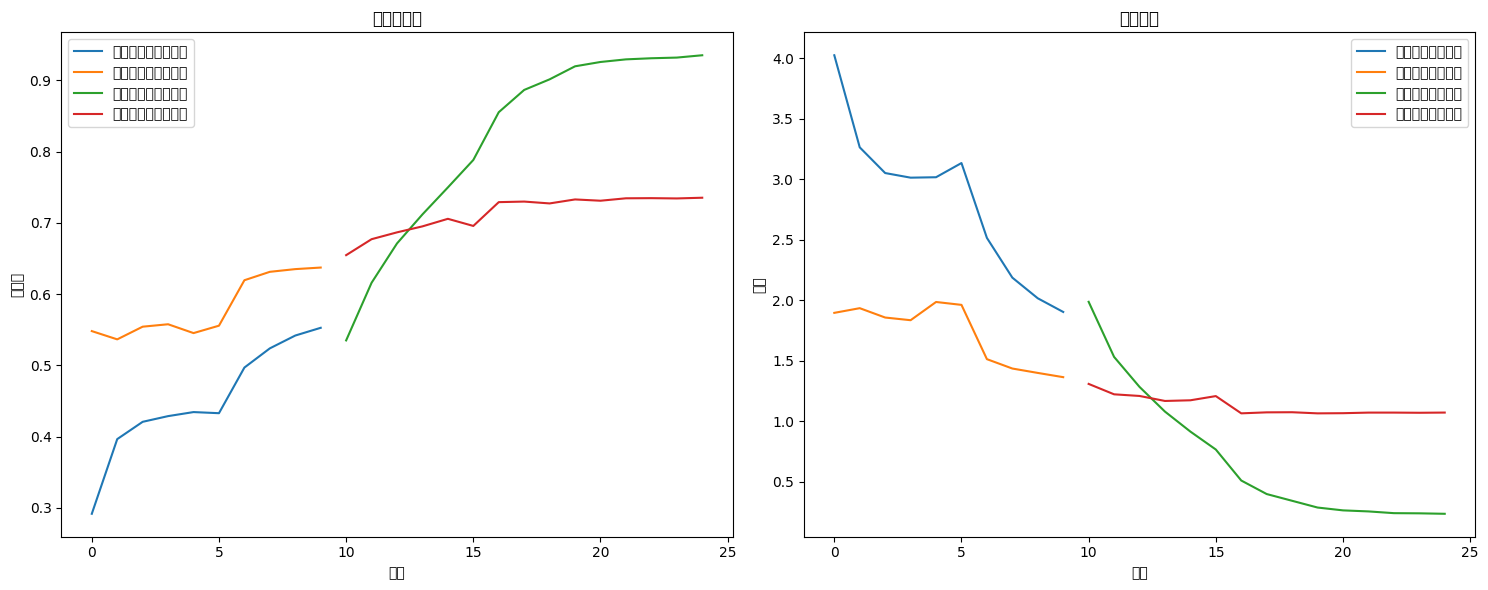


在随机样本上测试模型...


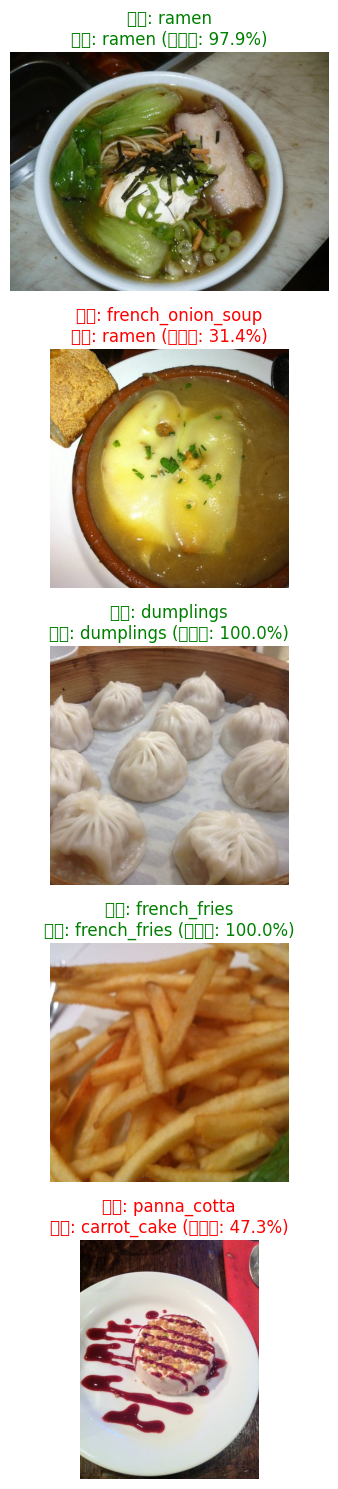

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import os
import warnings
from PIL import Image
import time

# 设置随机种子确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 隐藏警告
warnings.filterwarnings('ignore')

# 创建输出文件夹
os.makedirs('outputs', exist_ok=True)

# 加载数据集
print("正在加载Food-101数据集...")
dataset = load_dataset("ethz/food101")

# 基本信息
print(f"训练集样本数: {len(dataset['train'])}")
print(f"测试集样本数: {len(dataset['validation'])}")

# 获取所有类别
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"类别数量: {num_classes}")

# 图像预处理函数
def preprocess_image(image, target_size=(224, 224)):
    """
    基本图像预处理：调整大小和标准化
    
    参数:
    - image: PIL图像对象或numpy数组
    - target_size: 目标图像尺寸，默认为224x224
    
    返回:
    - 预处理后的图像数组（归一化到[0,1]范围）
    """
    # 如果输入是PIL图像，转换为numpy数组
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # 如果是灰度图像，转换为RGB
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA图像
        image = image[:, :, :3]
    
    # 转换为TensorFlow张量
    image_tensor = tf.convert_to_tensor(image)
    
    # 调整图像大小
    image_resized = tf.image.resize(image_tensor, target_size)
    
    # 标准化到[0,1]范围
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    return image_normalized

# 创建TensorFlow数据集
def create_tf_dataset(indices, dataset_split, batch_size=32, is_training=False, shuffle_buffer=10000):
    """
    创建TensorFlow数据集
    
    参数:
    - indices: 数据样本的索引列表
    - dataset_split: HuggingFace数据集分割
    - batch_size: 批量大小
    - is_training: 是否为训练模式(决定是否使用数据增强)
    - shuffle_buffer: 用于打乱数据的缓冲区大小
    
    返回:
    - TensorFlow数据集
    """
    def gen():
        # 获取索引并(可选)打乱
        if is_training:
            random.shuffle(indices)
            
        for idx in indices:
            try:
                sample = dataset_split[idx]
                image = sample['image']
                label = sample['label']
                
                # 转换为numpy数组
                image_array = np.array(image)
                
                # 确保图像是RGB (3通道)
                if len(image_array.shape) == 2:  # 灰度图像
                    image_array = np.stack([image_array] * 3, axis=-1)
                elif image_array.shape[-1] == 4:  # RGBA图像
                    image_array = image_array[:, :, :3]
                    
                yield image_array, label
            except Exception as e:
                # print(f"处理样本 {idx} 时出错: {e}")
                continue
    
    # 创建数据集
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    
    # 图像预处理
    def _preprocess(image, label):
        # 预处理图像
        image = tf.cast(image, tf.float32) / 255.0
        
        # 调整大小
        image = tf.image.resize(image, (224, 224))
        
        # 数据增强 (仅在训练时)
        if is_training:
            # 随机水平翻转
            image = tf.image.random_flip_left_right(image)
            
            # 随机亮度和对比度
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            
            # 确保值在[0,1]范围内
            image = tf.clip_by_value(image, 0.0, 1.0)
        
        return image, label
    
    # 应用预处理
    ds = ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 打乱、批处理和预取
    if is_training:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 随机抽样选择训练和验证样本
print("随机抽样选择训练和验证样本...")
TRAIN_SIZE = 30000  # 增加到30000个样本
VAL_SIZE = 5000     # 增加验证集大小

# 随机抽样
train_indices = random.sample(range(len(dataset['train'])), TRAIN_SIZE)
val_indices = random.sample(range(len(dataset['validation'])), VAL_SIZE)

print(f"已随机选择 {TRAIN_SIZE} 个训练样本和 {VAL_SIZE} 个验证样本")

# 检查类别分布
train_labels = [dataset['train'][i]['label'] for i in train_indices[:1000]]  # 只检查1000个样本以节省时间
label_counts = {}
for label in train_labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

print(f"随机抽样中检测到的类别数: {len(label_counts)} (应该接近101)")

# 创建数据集
BATCH_SIZE = 32
print("创建训练和验证数据集...")

train_ds = create_tf_dataset(
    train_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=TRAIN_SIZE
)

val_ds = create_tf_dataset(
    val_indices, 
    dataset['validation'], 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 检查数据集
print("检查数据集...")
for images, labels in train_ds.take(1):
    print(f"批次形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"图像值范围: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")

# 构建模型
def build_model(num_classes=101, freeze_base=True):
    """
    构建基于ResNet50的模型
    
    参数:
    - num_classes: 分类数量
    - freeze_base: 是否冻结ResNet50的权重
    
    返回:
    - 编译好的模型
    """
    # 加载预训练的ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # 设置基础模型是否可训练
    base_model.trainable = not freeze_base
    
    # 如果部分解冻，只解冻最后的一些层
    if not freeze_base:
        # 冻结前面的层，只训练后面的层
        for layer in base_model.layers[:-30]:
            layer.trainable = False
    
    # 构建完整模型
    model = tf.keras.Sequential([
        # 预处理层
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x * 255.0)),
        
        # 基础模型
        base_model,
        
        # 分类头
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# 创建模型
print(f"创建含有 {num_classes} 个分类的模型...")
model, base_model = build_model(num_classes=num_classes, freeze_base=True)

# 显示模型结构摘要
model.summary()

# 设置训练参数
EPOCHS_STAGE1 = 10  # 减少轮次以加快训练
STEPS_PER_EPOCH = None  # 使用None会自动计算步数

# 设置回调函数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第一阶段训练
print("开始第一阶段训练 (冻结基础模型)...")
start_time = time.time()

history1 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE1,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

stage1_time = time.time() - start_time
print(f"第一阶段训练完成，耗时: {stage1_time:.2f} 秒")

# 保存第一阶段模型
model.save('outputs/food101_stage1_model.keras')
print("第一阶段模型已保存")

# 第二阶段：解冻部分基础模型进行微调
print("\n开始第二阶段训练 (解冻部分基础模型)...")

# 获取ResNet50基础模型
base_model = model.layers[1]  # 索引0是Lambda层，1是ResNet50

# 解冻部分基础模型
base_model.trainable = True

# 冻结前面的层，只训练最后的30层
print("解冻ResNet50的最后30层...")
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 查看有多少层被解冻
trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
total_layers = len(base_model.layers)
print(f"ResNet50基础模型共有 {total_layers} 层，其中 {trainable_layers} 层被设为可训练")

# 使用较小的学习率重新编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 降低学习率进行微调
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 设置第二阶段回调
callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第二阶段训练
EPOCHS_STAGE2 = 15  # 减少轮次以加快训练
print(f"开始第二阶段训练，共 {EPOCHS_STAGE2} 轮...")
stage2_start_time = time.time()

history2 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE2,
    validation_data=val_ds,
    callbacks=callbacks_stage2,
    verbose=1
)

stage2_time = time.time() - stage2_start_time
total_time = time.time() - start_time

print(f"第二阶段训练完成，耗时: {stage2_time:.2f} 秒")
print(f"总训练时间: {total_time:.2f} 秒")

# 保存最终模型
model.save('outputs/food101_final_model.keras')
print("最终模型已保存")

# 显示第一阶段和第二阶段训练结果
final_train_acc1 = history1.history['accuracy'][-1]
final_val_acc1 = history1.history['val_accuracy'][-1]
best_val_acc1 = max(history1.history['val_accuracy'])

final_train_acc2 = history2.history['accuracy'][-1]
final_val_acc2 = history2.history['val_accuracy'][-1]
best_val_acc2 = max(history2.history['val_accuracy'])

print("\n训练结果摘要:")
print(f"第一阶段最终训练准确率: {final_train_acc1:.4f}")
print(f"第一阶段最终验证准确率: {final_val_acc1:.4f}")
print(f"第一阶段最佳验证准确率: {best_val_acc1:.4f}")
print(f"第二阶段最终训练准确率: {final_train_acc2:.4f}")
print(f"第二阶段最终验证准确率: {final_val_acc2:.4f}")
print(f"第二阶段最佳验证准确率: {best_val_acc2:.4f}")

# 可视化训练历史
plt.figure(figsize=(15, 6))

# 绘制准确率
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='第一阶段训练准确率')
plt.plot(history1.history['val_accuracy'], label='第一阶段验证准确率')

# 计算第一阶段轮数
offset = len(history1.history['accuracy'])
# 绘制第二阶段
plt.plot(
    [i + offset for i in range(len(history2.history['accuracy']))],
    history2.history['accuracy'], 
    label='第二阶段训练准确率'
)
plt.plot(
    [i + offset for i in range(len(history2.history['val_accuracy']))],
    history2.history['val_accuracy'], 
    label='第二阶段验证准确率'
)

plt.title('模型准确率')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend()

# 绘制损失
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='第一阶段训练损失')
plt.plot(history1.history['val_loss'], label='第一阶段验证损失')

# 绘制第二阶段
plt.plot(
    [i + offset for i in range(len(history2.history['loss']))],
    history2.history['loss'], 
    label='第二阶段训练损失'
)
plt.plot(
    [i + offset for i in range(len(history2.history['val_loss']))],
    history2.history['val_loss'], 
    label='第二阶段验证损失'
)

plt.title('模型损失')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend()

plt.tight_layout()
plt.savefig('outputs/training_history_full.png')
plt.show()

# 在几个随机样本上测试模型
def test_on_random_samples(model, dataset_split, num_samples=5):
    # 随机选择样本
    indices = random.sample(range(len(dataset_split)), num_samples)
    
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(indices):
        # 获取样本
        sample = dataset_split[idx]
        image = np.array(sample['image'])
        true_label = sample['label']
        
        # 预处理图像
        img = preprocess_image(image)
        img = tf.expand_dims(img, 0)  # 添加批次维度
        
        # 预测
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        
        # 显示图像和预测结果
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(sample['image'])
        
        # 给出正确/错误的颜色标记
        color = 'green' if predicted_label == true_label else 'red'
        
        plt.title(
            f"真实: {food_classes[true_label]}\n预测: {food_classes[predicted_label]} (置信度: {predictions[0][predicted_label]*100:.1f}%)", 
            color=color
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/prediction_samples.png')
    plt.show()

print("\n在随机样本上测试模型...")
test_on_random_samples(model, dataset['validation'], num_samples=5)

# 改进2： 接着上一个训练， 增强数据看效果

正在加载Food-101数据集...
训练集样本数: 75750
测试集样本数: 25250
类别数量: 101
随机抽样选择训练和验证样本...
已随机选择 30000 个训练样本和 5000 个验证样本
随机抽样中检测到的类别数: 101 (应该接近101)
创建训练和验证数据集...
检查数据集...


2025-04-01 17:38:13.247815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 13221 of 30000
2025-04-01 17:38:25.949124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


批次形状: (32, 224, 224, 3)
标签形状: (32,)
图像值范围: [0.0, 1.0]


2025-04-01 17:38:26.789551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


创建含有 101 个分类的模型...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,405 (92.11 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

开始第一阶段训练 (冻结基础模型)...
Epoch 1/10


2025-04-01 17:38:39.092202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 13148 of 30000
2025-04-01 17:38:49.092592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 26784 of 30000
2025-04-01 17:38:51.423033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    938/Unknown 72s 51ms/step - accuracy: 0.1694 - loss: 4.9319

2025-04-01 17:39:39.941059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:39:39.941071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_3_1/dropout_3_1/Add/_40]]
2025-04-01 17:39:39.941081: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12649573610884473150
2025-04-01 17:39:39.941085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18240922013991498408
2025-04-01 17:39:39.941088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6512316931299755558
2025-04-01 17:39:39.941092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled.


Epoch 1: val_accuracy improved from -inf to 0.48980, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:39:49.273876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:39:49.273891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-01 17:39:49.273902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659


938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.1694 - loss: 4.9315 - val_accuracy: 0.4898 - val_loss: 2.2260 - learning_rate: 0.0010
Epoch 2/10


2025-04-01 17:39:59.737178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 11962 of 30000
2025-04-01 17:40:09.738462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 23273 of 30000
2025-04-01 17:40:15.378479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3091 - loss: 3.8089

2025-04-01 17:41:03.563521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:41:03.563539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-04-01 17:41:03.563555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-04-01 17:41:03.563559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:41:03.563562: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14025633426652666449
2025-04-01 17:41:03.563565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3453325236415322643
2025-04-


Epoch 2: val_accuracy improved from 0.48980 to 0.51560, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:41:14.556145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:41:14.556162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:41:14.556166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - accuracy: 0.3091 - loss: 3.8088 - val_accuracy: 0.5156 - val_loss: 2.0456 - learning_rate: 0.0010
Epoch 3/10


2025-04-01 17:41:24.935917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12026 of 30000
2025-04-01 17:41:39.111451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3303 - loss: 3.4834

2025-04-01 17:42:26.735629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:42:26.735657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-04-01 17:42:26.735663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:42:26.735667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9433285799184269869
2025-04-01 17:42:26.735670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-04-01 17:42:26.735675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3303743626


Epoch 3: val_accuracy did not improve from 0.51560
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.3303 - loss: 3.4833 - val_accuracy: 0.5082 - val_loss: 2.0500 - learning_rate: 0.0010
Epoch 4/10


2025-04-01 17:42:36.533584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:42:36.533601: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:42:36.533603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-01 17:42:46.547980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12017 of 30000
2025-04-01 17:42:56.548026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24769 of 30000


  2/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.3984 - loss: 3.2351   

2025-04-01 17:43:00.379295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3409 - loss: 3.3522

2025-04-01 17:43:47.578178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:43:47.578194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12649573610884473150
2025-04-01 17:43:47.578197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18240922013991498408
2025-04-01 17:43:47.578201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17017811400984483062
2025-04-01 17:43:47.578204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6512316931299755558
2025-04-01 17:43:47.578206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-04-01 17:43:47.578209: I tensorflow/core/framework/local_rende


Epoch 4: val_accuracy improved from 0.51560 to 0.52380, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:43:57.773779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:43:57.773797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:43:57.773806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.3409 - loss: 3.3523 - val_accuracy: 0.5238 - val_loss: 1.9617 - learning_rate: 0.0010
Epoch 5/10


2025-04-01 17:44:08.166674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12095 of 30000
2025-04-01 17:44:18.166697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24972 of 30000
2025-04-01 17:44:21.933669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3474 - loss: 3.3480

2025-04-01 17:45:09.961849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:45:09.961870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18240922013991498408
2025-04-01 17:45:09.961892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-04-01 17:45:09.961906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6512316931299755558
2025-04-01 17:45:09.961914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11633903373497296998
2025-04-01 17:45:09.961917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 524011920


Epoch 5: val_accuracy did not improve from 0.52380
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.3474 - loss: 3.3481 - val_accuracy: 0.5020 - val_loss: 2.1395 - learning_rate: 0.0010
Epoch 6/10


2025-04-01 17:45:18.545909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:45:18.545925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:45:18.545933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-01 17:45:28.560686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12061 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.3524 - loss: 3.0678

2025-04-01 17:45:42.245682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3386 - loss: 3.4550

2025-04-01 17:46:29.299219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:46:29.299237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_22]]
2025-04-01 17:46:29.299253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-04-01 17:46:29.299257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:46:29.299261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14025633426652666449
2025-04-01 17:46:29.299264: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3453325236415322643
2025-04-


Epoch 6: val_accuracy did not improve from 0.52380

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.3386 - loss: 3.4552 - val_accuracy: 0.5166 - val_loss: 2.1487 - learning_rate: 0.0010
Epoch 7/10


2025-04-01 17:46:37.163248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:46:37.163270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:46:37.163276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-01 17:46:47.180297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 11946 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.3038 - loss: 4.2637   

2025-04-01 17:47:01.256175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3792 - loss: 3.1377

2025-04-01 17:47:48.651073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:47:48.651090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-04-01 17:47:48.651107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-04-01 17:47:48.651112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:47:48.651116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12381487750122714635
2025-04-01 17:47:48.651119: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 172301054


Epoch 7: val_accuracy improved from 0.52380 to 0.58260, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:47:56.876573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:47:56.876590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:47:56.876596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.3792 - loss: 3.1373 - val_accuracy: 0.5826 - val_loss: 1.6523 - learning_rate: 2.0000e-04
Epoch 8/10


2025-04-01 17:48:07.236557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12252 of 30000
2025-04-01 17:48:17.236614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 25006 of 30000
2025-04-01 17:48:20.861031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4185 - loss: 2.6530

2025-04-01 17:49:07.328243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:49:07.328264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-04-01 17:49:07.328269: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:49:07.328273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9433285799184269869
2025-04-01 17:49:07.328276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-04-01 17:49:07.328280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3303743626


Epoch 8: val_accuracy improved from 0.58260 to 0.59100, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:49:15.357523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:49:15.357540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:49:15.357547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.4185 - loss: 2.6529 - val_accuracy: 0.5910 - val_loss: 1.5867 - learning_rate: 2.0000e-04
Epoch 9/10


2025-04-01 17:49:25.683335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12268 of 30000
2025-04-01 17:49:35.683926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24824 of 30000


  2/938 ━━━━━━━━━━━━━━━━━━━━ 1:02 67ms/step - accuracy: 0.4219 - loss: 2.5685  

2025-04-01 17:49:39.514906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4391 - loss: 2.4378

2025-04-01 17:50:26.159195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:50:26.159210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12649573610884473150
2025-04-01 17:50:26.159214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18240922013991498408
2025-04-01 17:50:26.159217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_28]]
2025-04-01 17:50:26.159237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5240119208927174517
2025-04-01 17:50:26.159242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 33037436263


Epoch 9: val_accuracy improved from 0.59100 to 0.59760, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:50:34.344419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:50:34.344437: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:50:34.344442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.4391 - loss: 2.4378 - val_accuracy: 0.5976 - val_loss: 1.5421 - learning_rate: 2.0000e-04
Epoch 10/10


2025-04-01 17:50:44.674873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12037 of 30000


  3/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.4826 - loss: 2.1553

2025-04-01 17:50:58.727810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4527 - loss: 2.3221

2025-04-01 17:51:45.813260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:51:45.813282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_38]]
2025-04-01 17:51:45.813287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16477355880694817307
2025-04-01 17:51:45.813291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9433285799184269869
2025-04-01 17:51:45.813296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9361699478030987055
2025-04-01 17:51:45.813299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3303743626


Epoch 10: val_accuracy improved from 0.59760 to 0.60460, saving model to outputs/food101_best_model_stage1.keras


2025-04-01 17:51:54.268869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:51:54.268887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-01 17:51:54.268909: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659


938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.4527 - loss: 2.3220 - val_accuracy: 0.6046 - val_loss: 1.5162 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
第一阶段训练完成，耗时: 807.19 秒
第一阶段模型已保存

开始第二阶段训练 (解冻部分基础模型)...
解冻ResNet50的最后30层...
ResNet50基础模型共有 175 层，其中 30 层被设为可训练
开始第二阶段训练，共 15 轮...
Epoch 1/15


2025-04-01 17:52:08.005915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12037 of 30000
2025-04-01 17:52:22.128852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    938/Unknown 99s 75ms/step - accuracy: 0.4495 - loss: 2.2975

2025-04-01 17:53:34.544065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:53:34.544180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_54/_150]]
2025-04-01 17:53:34.544190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 17:53:34.544194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 17:53:34.544195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9519759123930963999
2025-04-01 17:53:34.544200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1271585


Epoch 1: val_accuracy improved from -inf to 0.63100, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 17:53:46.051692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:53:46.051704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 17:53:46.051709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:53:46.051711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 17:53:46.051714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656


938/938 ━━━━━━━━━━━━━━━━━━━━ 111s 88ms/step - accuracy: 0.4495 - loss: 2.2975 - val_accuracy: 0.6310 - val_loss: 1.4038 - learning_rate: 1.0000e-04
Epoch 2/15


2025-04-01 17:53:56.585264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12097 of 30000
2025-04-01 17:54:06.585528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24733 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:15:37 24s/step - accuracy: 0.5000 - loss: 2.2161

2025-04-01 17:54:10.506024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5178 - loss: 1.9433

2025-04-01 17:55:20.452782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:55:20.452799: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-04-01 17:55:20.452801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_102]]
2025-04-01 17:55:20.452818: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 17:55:20.452828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 17:55:20.452832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732


Epoch 2: val_accuracy improved from 0.63100 to 0.64440, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 17:55:29.397366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:55:29.397387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 17:55:29.397392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:55:29.397395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 17:55:29.397398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656


938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 85ms/step - accuracy: 0.5178 - loss: 1.9433 - val_accuracy: 0.6444 - val_loss: 1.3016 - learning_rate: 1.0000e-04
Epoch 3/15


2025-04-01 17:55:39.827255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12066 of 30000
2025-04-01 17:55:53.750525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5636 - loss: 1.7370

2025-04-01 17:57:04.620520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:57:04.620536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 17:57:04.620539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 17:57:04.620541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 17:57:04.620544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 17:57:04.620550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-04-01 17:57:04.620552: W tensorflow/core/framework/local_rende


Epoch 3: val_accuracy improved from 0.64440 to 0.67380, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 17:57:13.559763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:57:13.559779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 17:57:13.559786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:57:13.559788: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 17:57:13.559792: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656


938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 85ms/step - accuracy: 0.5636 - loss: 1.7370 - val_accuracy: 0.6738 - val_loss: 1.2414 - learning_rate: 1.0000e-04
Epoch 4/15


2025-04-01 17:57:23.979442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12079 of 30000
2025-04-01 17:57:37.759887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6037 - loss: 1.5394

2025-04-01 17:58:49.000800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:58:49.000815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-04-01 17:58:49.000822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 17:58:49.000825: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 17:58:49.000827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 17:58:49.000829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 17:58:49.000831: I tensorflow/core/framework/local_rendez


Epoch 4: val_accuracy improved from 0.67380 to 0.68300, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 17:58:56.674328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 17:58:56.674346: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 17:58:56.674356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 84ms/step - accuracy: 0.6037 - loss: 1.5395 - val_accuracy: 0.6830 - val_loss: 1.2048 - learning_rate: 1.0000e-04
Epoch 5/15


2025-04-01 17:59:07.089448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12070 of 30000
2025-04-01 17:59:17.089984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24529 of 30000
2025-04-01 17:59:21.121049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6257 - loss: 1.4354

2025-04-01 18:00:32.687483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:00:32.687502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_102]]
2025-04-01 18:00:32.687637: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:00:32.687641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:00:32.687644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-04-01 18:00:32.687648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 144970


Epoch 5: val_accuracy improved from 0.68300 to 0.69800, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:00:40.267626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:00:40.267641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-01 18:00:40.267658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659


938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 85ms/step - accuracy: 0.6257 - loss: 1.4355 - val_accuracy: 0.6980 - val_loss: 1.1467 - learning_rate: 1.0000e-04
Epoch 6/15


2025-04-01 18:00:50.691189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12135 of 30000
2025-04-01 18:01:04.321342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6559 - loss: 1.3104

2025-04-01 18:02:16.394924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:02:16.394939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:02:16.394945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_40/_136]]
2025-04-01 18:02:16.394962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-04-01 18:02:16.394966: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10250745231127331923
2025-04-01 18:02:16.394971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 175954


Epoch 6: val_accuracy did not improve from 0.69800
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 84ms/step - accuracy: 0.6559 - loss: 1.3104 - val_accuracy: 0.6964 - val_loss: 1.1652 - learning_rate: 1.0000e-04
Epoch 7/15


2025-04-01 18:02:23.703875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:02:23.703893: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:02:23.703898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-01 18:02:33.720903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12213 of 30000
2025-04-01 18:02:47.598227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6805 - loss: 1.2072

2025-04-01 18:04:00.350834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:04:00.350854: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-04-01 18:04:00.350864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:04:00.350866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 18:04:00.350869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_102]]
2025-04-01 18:04:00.350882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1008325


Epoch 7: val_accuracy improved from 0.69800 to 0.70080, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:04:07.727350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:04:07.727370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:04:07.727374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 86ms/step - accuracy: 0.6805 - loss: 1.2073 - val_accuracy: 0.7008 - val_loss: 1.1408 - learning_rate: 1.0000e-04
Epoch 8/15


2025-04-01 18:04:18.137730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12122 of 30000
2025-04-01 18:04:28.137777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24485 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:19:49 24s/step - accuracy: 0.8125 - loss: 0.9273

2025-04-01 18:04:32.287007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7020 - loss: 1.1233

2025-04-01 18:05:46.284256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:05:46.284284: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:05:46.284289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 18:05:46.284292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 18:05:46.284295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 18:05:46.284297: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-04-01 18:05:46.284299: I tensorflow/core/framework/local_rende


Epoch 8: val_accuracy improved from 0.70080 to 0.70120, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:05:53.760654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:05:53.760673: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:05:53.760680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 106s 87ms/step - accuracy: 0.7020 - loss: 1.1233 - val_accuracy: 0.7012 - val_loss: 1.1278 - learning_rate: 1.0000e-04
Epoch 9/15


2025-04-01 18:06:04.184536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12092 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:12:58 24s/step - accuracy: 0.8125 - loss: 0.7843

2025-04-01 18:06:17.954591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7183 - loss: 1.0525

2025-04-01 18:07:29.279786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:07:29.279801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 18:07:29.279816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10200074758655107670
2025-04-01 18:07:29.279820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 18:07:29.279822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14543362526177191622
2025-04-01 18:07:29.279824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:07:29.279826: I tensorflow/core/framework/local_rende


Epoch 9: val_accuracy improved from 0.70120 to 0.70300, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:07:37.191321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:07:37.191338: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:07:37.191344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 85ms/step - accuracy: 0.7183 - loss: 1.0525 - val_accuracy: 0.7030 - val_loss: 1.1216 - learning_rate: 1.0000e-04
Epoch 10/15


2025-04-01 18:07:47.607499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12232 of 30000


  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:15:15 24s/step - accuracy: 0.5938 - loss: 1.2513

2025-04-01 18:08:01.464632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7330 - loss: 0.9799

2025-04-01 18:09:12.157367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:09:12.157381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:09:12.157384: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 18:09:12.157389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 18:09:12.157391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:09:12.157393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-04-01 18:09:12.157395: I tensorflow/core/framework/local_rende


Epoch 10: val_accuracy did not improve from 0.70300
938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 83ms/step - accuracy: 0.7330 - loss: 0.9799 - val_accuracy: 0.6994 - val_loss: 1.1818 - learning_rate: 1.0000e-04
Epoch 11/15


2025-04-01 18:09:19.657588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:09:19.657606: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:09:19.657610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 18:09:19.657615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 18:09:29.671996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12077 of 30000
2025-04-01 18:09:39.672186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7490 - loss: 0.9153

2025-04-01 18:10:55.472210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:10:55.472229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5495402169157935120
2025-04-01 18:10:55.472250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:10:55.472254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_102]]
2025-04-01 18:10:55.472268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5004302347184038428
2025-04-01 18:10:55.472275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732


Epoch 11: val_accuracy improved from 0.70300 to 0.71080, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:11:03.521518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:11:03.521532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 18:11:03.521537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:11:03.521541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 18:11:03.521543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656



Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 85ms/step - accuracy: 0.7490 - loss: 0.9153 - val_accuracy: 0.7108 - val_loss: 1.1601 - learning_rate: 1.0000e-04
Epoch 12/15


2025-04-01 18:11:13.942074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12250 of 30000
2025-04-01 18:11:23.942277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24774 of 30000
2025-04-01 18:11:27.933075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7947 - loss: 0.7417

2025-04-01 18:12:40.464080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:12:40.464100: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:12:40.464104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:12:40.464107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-04-01 18:12:40.464109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14497097978216089918
2025-04-01 18:12:40.464111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16809833110028421626
2025-04-01 18:12:40.464113: I tensorflow/core/framework/local_rend


Epoch 12: val_accuracy improved from 0.71080 to 0.73480, saving model to outputs/food101_best_model_stage2.keras


2025-04-01 18:12:48.413177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:12:48.413195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:12:48.413201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 86ms/step - accuracy: 0.7947 - loss: 0.7417 - val_accuracy: 0.7348 - val_loss: 1.0390 - learning_rate: 2.0000e-05
Epoch 13/15


2025-04-01 18:12:58.833570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 12126 of 30000
2025-04-01 18:13:08.833769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while): 24742 of 30000
2025-04-01 18:13:12.665217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8217 - loss: 0.6444

2025-04-01 18:14:24.221370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:14:24.221382: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:14:24.221390: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:14:24.221392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-04-01 18:14:24.221394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14497097978216089918
2025-04-01 18:14:24.221441: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16809833110028421626
2025-04-01 18:14:24.221445: I tensorflow/core/framework/local_rend


Epoch 13: val_accuracy did not improve from 0.73480
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 84ms/step - accuracy: 0.8217 - loss: 0.6444 - val_accuracy: 0.7334 - val_loss: 1.0459 - learning_rate: 2.0000e-05
Epoch 14/15


2025-04-01 18:14:31.957421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:14:31.957436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 18:14:31.957442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:14:31.957445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 18:14:31.957447: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-04-01 18:14:41.972622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while)

  1/938 ━━━━━━━━━━━━━━━━━━━━ 6:17:57 24s/step - accuracy: 0.8438 - loss: 0.5369

2025-04-01 18:14:56.022379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8364 - loss: 0.5882

2025-04-01 18:16:08.731135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:16:08.731154: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17791732111096521974
2025-04-01 18:16:08.731158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17595472555420026662
2025-04-01 18:16:08.731162: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12715855484036368570
2025-04-01 18:16:08.731165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11890923380957104980
2025-04-01 18:16:08.731168: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4022178602180832340
2025-04-01 18:16:08.731171: W tensorflow/core/framework/local_rende


Epoch 14: val_accuracy did not improve from 0.73480

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 85ms/step - accuracy: 0.8364 - loss: 0.5882 - val_accuracy: 0.7330 - val_loss: 1.0633 - learning_rate: 2.0000e-05
Epoch 15/15


2025-04-01 18:16:16.159059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:16:16.159078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-01 18:16:16.159083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659
2025-04-01 18:16:16.159086: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11250777870124872589
2025-04-01 18:16:16.159089: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15442494145396173656
2025-04-01 18:16:26.176932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:331: Filling up shuffle buffer (this may take a while)

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8482 - loss: 0.5439

2025-04-01 18:17:53.552015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:17:53.552032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_74/_172]]
2025-04-01 18:17:53.552049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14432574351009333734
2025-04-01 18:17:53.552061: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18171586979788800895
2025-04-01 18:17:53.552068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3638038468072654156
2025-04-01 18:17:53.552074: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1759547


Epoch 15: val_accuracy did not improve from 0.73480
938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 87ms/step - accuracy: 0.8482 - loss: 0.5439 - val_accuracy: 0.7344 - val_loss: 1.0502 - learning_rate: 4.0000e-06
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 12.


2025-04-01 18:18:01.549754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-01 18:18:01.549770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-01 18:18:01.549781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12876012445105619659


第二阶段训练完成，耗时: 1566.31 秒
总训练时间: 2374.13 秒
最终模型已保存

训练结果摘要:
第一阶段最终训练准确率: 0.4537
第一阶段最终验证准确率: 0.6046
第一阶段最佳验证准确率: 0.6046
第二阶段最终训练准确率: 0.8503
第二阶段最终验证准确率: 0.7344
第二阶段最佳验证准确率: 0.7348


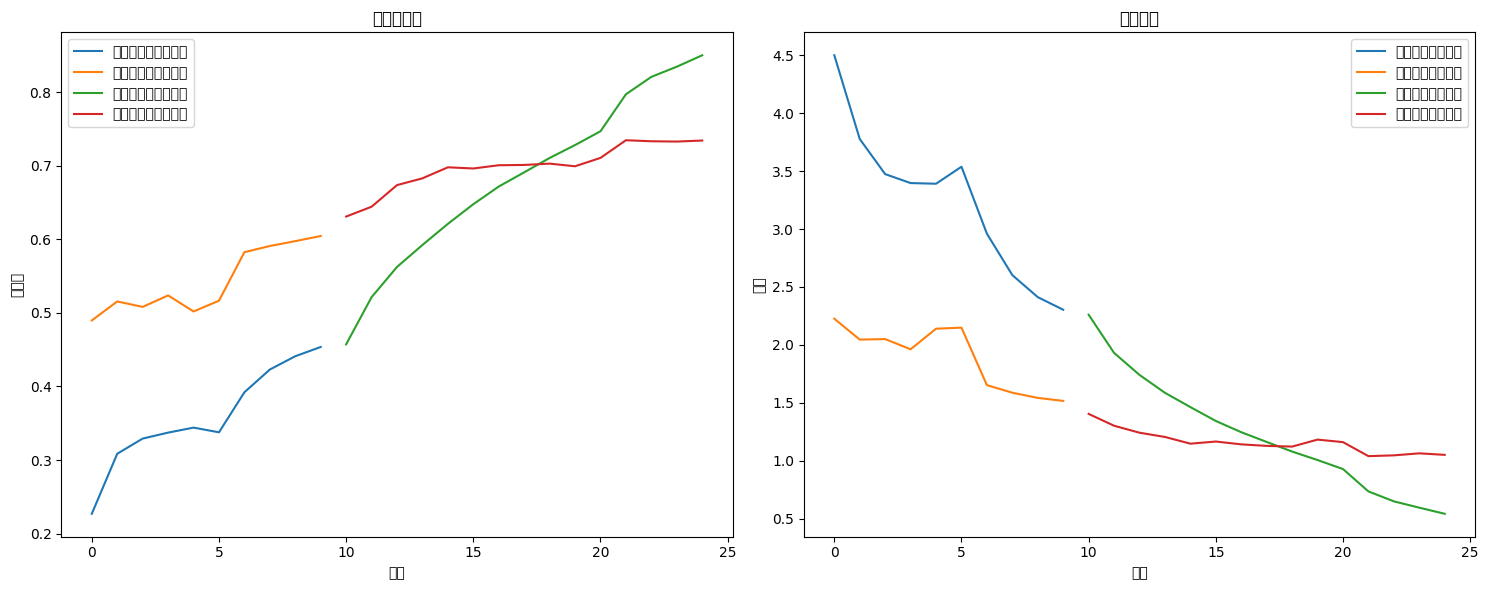


在随机样本上测试模型...


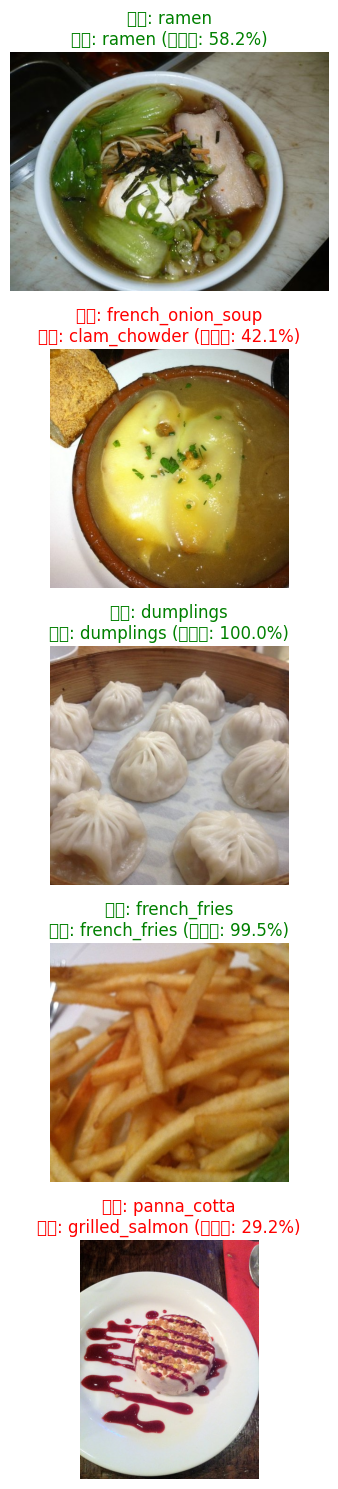

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import os
import warnings
from PIL import Image
import time

# 设置随机种子确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 隐藏警告
warnings.filterwarnings('ignore')

# 创建输出文件夹
os.makedirs('outputs', exist_ok=True)

# 加载数据集
print("正在加载Food-101数据集...")
dataset = load_dataset("ethz/food101")

# 基本信息
print(f"训练集样本数: {len(dataset['train'])}")
print(f"测试集样本数: {len(dataset['validation'])}")

# 获取所有类别
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"类别数量: {num_classes}")

# 图像预处理函数
def preprocess_image(image, target_size=(224, 224)):
    """
    基本图像预处理：调整大小和标准化
    
    参数:
    - image: PIL图像对象或numpy数组
    - target_size: 目标图像尺寸，默认为224x224
    
    返回:
    - 预处理后的图像数组（归一化到[0,1]范围）
    """
    # 如果输入是PIL图像，转换为numpy数组
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # 如果是灰度图像，转换为RGB
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA图像
        image = image[:, :, :3]
    
    # 转换为TensorFlow张量
    image_tensor = tf.convert_to_tensor(image)
    
    # 调整图像大小
    image_resized = tf.image.resize(image_tensor, target_size)
    
    # 标准化到[0,1]范围
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    return image_normalized

# 创建TensorFlow数据集 - 增强版
def create_tf_dataset(indices, dataset_split, batch_size=32, is_training=False, shuffle_buffer=10000):
    """
    创建TensorFlow数据集，增强版数据增强
    
    参数:
    - indices: 数据样本的索引列表
    - dataset_split: HuggingFace数据集分割
    - batch_size: 批量大小
    - is_training: 是否为训练模式(决定是否使用数据增强)
    - shuffle_buffer: 用于打乱数据的缓冲区大小
    
    返回:
    - TensorFlow数据集
    """
    def gen():
        # 获取索引并(可选)打乱
        if is_training:
            random.shuffle(indices)
            
        for idx in indices:
            try:
                sample = dataset_split[idx]
                image = sample['image']
                label = sample['label']
                
                # 转换为numpy数组
                image_array = np.array(image)
                
                # 确保图像是RGB (3通道)
                if len(image_array.shape) == 2:  # 灰度图像
                    image_array = np.stack([image_array] * 3, axis=-1)
                elif image_array.shape[-1] == 4:  # RGBA图像
                    image_array = image_array[:, :, :3]
                    
                yield image_array, label
            except Exception as e:
                # print(f"处理样本 {idx} 时出错: {e}")
                continue
    
    # 创建数据集
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    
    # 图像预处理和增强的增强版
    def _enhanced_preprocess(image, label):
        # 预处理图像
        image = tf.cast(image, tf.float32) / 255.0
        
        # 调整大小
        image = tf.image.resize(image, (224, 224))
        
        # 增强版的数据增强 (仅在训练时)
        if is_training:
            # 随机水平翻转
            image = tf.image.random_flip_left_right(image)
            
            # 随机亮度、对比度和饱和度调整
            image = tf.image.random_brightness(image, 0.2)  # 增大亮度变化范围
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)  # 添加饱和度调整
            
            # 随机色调变化
            image = tf.image.random_hue(image, 0.1)  # 添加色调变化
            
            # 随机裁剪和调整大小 - 先放大再裁剪，增加多样性
            image = tf.image.resize(image, (250, 250))  # 放大到更大尺寸
            image = tf.image.random_crop(image, (224, 224, 3))  # 随机裁剪回224x224
            
            # 随机选择是否应用随机缩放
            # 以0.5概率应用
            random_apply_scale = tf.cast(tf.random.uniform([], 0, 2, dtype=tf.int32), tf.bool)
            def random_scale(img):
                # 随机缩放因子
                scale_factor = tf.random.uniform([], 0.8, 1.2)
                new_height = tf.cast(224 * scale_factor, tf.int32)
                new_width = tf.cast(224 * scale_factor, tf.int32)
                # 调整大小
                img = tf.image.resize(img, [new_height, new_width])
                # 填充或裁剪到224x224
                img = tf.image.resize_with_crop_or_pad(img, 224, 224)
                return img
            
            image = tf.cond(random_apply_scale, 
                           lambda: random_scale(image), 
                           lambda: image)
            
            # 确保值在[0,1]范围内
            image = tf.clip_by_value(image, 0.0, 1.0)
        
        return image, label
    
    # 应用预处理
    ds = ds.map(_enhanced_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 打乱、批处理和预取
    if is_training:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 随机抽样选择训练和验证样本
print("随机抽样选择训练和验证样本...")
TRAIN_SIZE = 30000  # 保持30000个样本
VAL_SIZE = 5000     # 保持5000个验证样本

# 随机抽样
train_indices = random.sample(range(len(dataset['train'])), TRAIN_SIZE)
val_indices = random.sample(range(len(dataset['validation'])), VAL_SIZE)

print(f"已随机选择 {TRAIN_SIZE} 个训练样本和 {VAL_SIZE} 个验证样本")

# 检查类别分布
train_labels = [dataset['train'][i]['label'] for i in train_indices[:1000]]  # 只检查1000个样本以节省时间
label_counts = {}
for label in train_labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

print(f"随机抽样中检测到的类别数: {len(label_counts)} (应该接近101)")

# 创建数据集
BATCH_SIZE = 32
print("创建训练和验证数据集...")

train_ds = create_tf_dataset(
    train_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=TRAIN_SIZE
)

val_ds = create_tf_dataset(
    val_indices, 
    dataset['validation'], 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 检查数据集
print("检查数据集...")
for images, labels in train_ds.take(1):
    print(f"批次形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"图像值范围: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")

# 构建模型
def build_model(num_classes=101, freeze_base=True):
    """
    构建基于ResNet50的模型
    
    参数:
    - num_classes: 分类数量
    - freeze_base: 是否冻结ResNet50的权重
    
    返回:
    - 编译好的模型
    """
    # 加载预训练的ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # 设置基础模型是否可训练
    base_model.trainable = not freeze_base
    
    # 如果部分解冻，只解冻最后的一些层
    if not freeze_base:
        # 冻结前面的层，只训练后面的层
        for layer in base_model.layers[:-30]:
            layer.trainable = False
    
    # 构建完整模型
    model = tf.keras.Sequential([
        # 预处理层
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x * 255.0)),
        
        # 基础模型
        base_model,
        
        # 分类头
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# 创建模型
print(f"创建含有 {num_classes} 个分类的模型...")
model, base_model = build_model(num_classes=num_classes, freeze_base=True)

# 显示模型结构摘要
model.summary()

# 设置训练参数
EPOCHS_STAGE1 = 10  # 保持原来的轮数
STEPS_PER_EPOCH = None  # 使用None会自动计算步数

# 设置回调函数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第一阶段训练
print("开始第一阶段训练 (冻结基础模型)...")
start_time = time.time()

history1 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE1,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

stage1_time = time.time() - start_time
print(f"第一阶段训练完成，耗时: {stage1_time:.2f} 秒")

# 保存第一阶段模型
model.save('outputs/food101_stage1_model.keras')
print("第一阶段模型已保存")

# 第二阶段：解冻部分基础模型进行微调
print("\n开始第二阶段训练 (解冻部分基础模型)...")

# 获取ResNet50基础模型
base_model = model.layers[1]  # 索引0是Lambda层，1是ResNet50

# 解冻部分基础模型
base_model.trainable = True

# 冻结前面的层，只训练最后的30层
print("解冻ResNet50的最后30层...")
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 查看有多少层被解冻
trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
total_layers = len(base_model.layers)
print(f"ResNet50基础模型共有 {total_layers} 层，其中 {trainable_layers} 层被设为可训练")

# 使用较小的学习率重新编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 降低学习率进行微调
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 设置第二阶段回调
callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第二阶段训练
EPOCHS_STAGE2 = 15  # 保持原来的轮数
print(f"开始第二阶段训练，共 {EPOCHS_STAGE2} 轮...")
stage2_start_time = time.time()

history2 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE2,
    validation_data=val_ds,
    callbacks=callbacks_stage2,
    verbose=1
)

stage2_time = time.time() - stage2_start_time
total_time = time.time() - start_time

print(f"第二阶段训练完成，耗时: {stage2_time:.2f} 秒")
print(f"总训练时间: {total_time:.2f} 秒")

# 保存最终模型
model.save('outputs/food101_final_model.keras')
print("最终模型已保存")

# 显示第一阶段和第二阶段训练结果
final_train_acc1 = history1.history['accuracy'][-1]
final_val_acc1 = history1.history['val_accuracy'][-1]
best_val_acc1 = max(history1.history['val_accuracy'])

final_train_acc2 = history2.history['accuracy'][-1]
final_val_acc2 = history2.history['val_accuracy'][-1]
best_val_acc2 = max(history2.history['val_accuracy'])

print("\n训练结果摘要:")
print(f"第一阶段最终训练准确率: {final_train_acc1:.4f}")
print(f"第一阶段最终验证准确率: {final_val_acc1:.4f}")
print(f"第一阶段最佳验证准确率: {best_val_acc1:.4f}")
print(f"第二阶段最终训练准确率: {final_train_acc2:.4f}")
print(f"第二阶段最终验证准确率: {final_val_acc2:.4f}")
print(f"第二阶段最佳验证准确率: {best_val_acc2:.4f}")

# 可视化训练历史
plt.figure(figsize=(15, 6))

# 绘制准确率
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='第一阶段训练准确率')
plt.plot(history1.history['val_accuracy'], label='第一阶段验证准确率')

# 计算第一阶段轮数
offset = len(history1.history['accuracy'])
# 绘制第二阶段
plt.plot(
    [i + offset for i in range(len(history2.history['accuracy']))],
    history2.history['accuracy'], 
    label='第二阶段训练准确率'
)
plt.plot(
    [i + offset for i in range(len(history2.history['val_accuracy']))],
    history2.history['val_accuracy'], 
    label='第二阶段验证准确率'
)

plt.title('模型准确率')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend()

# 绘制损失
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='第一阶段训练损失')
plt.plot(history1.history['val_loss'], label='第一阶段验证损失')

# 绘制第二阶段
plt.plot(
    [i + offset for i in range(len(history2.history['loss']))],
    history2.history['loss'], 
    label='第二阶段训练损失'
)
plt.plot(
    [i + offset for i in range(len(history2.history['val_loss']))],
    history2.history['val_loss'], 
    label='第二阶段验证损失'
)

plt.title('模型损失')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend()

plt.tight_layout()
plt.savefig('outputs/training_history_full.png')
plt.show()

# 在几个随机样本上测试模型
def test_on_random_samples(model, dataset_split, num_samples=5):
    # 随机选择样本
    indices = random.sample(range(len(dataset_split)), num_samples)
    
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(indices):
        # 获取样本
        sample = dataset_split[idx]
        image = np.array(sample['image'])
        true_label = sample['label']
        
        # 预处理图像
        img = preprocess_image(image)
        img = tf.expand_dims(img, 0)  # 添加批次维度
        
        # 预测
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        
        # 显示图像和预测结果
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(sample['image'])
        
        # 给出正确/错误的颜色标记
        color = 'green' if predicted_label == true_label else 'red'
        
        plt.title(
            f"真实: {food_classes[true_label]}\n预测: {food_classes[predicted_label]} (置信度: {predictions[0][predicted_label]*100:.1f}%)", 
            color=color
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/prediction_samples.png')
    plt.show()

print("\n在随机样本上测试模型...")
test_on_random_samples(model, dataset['validation'], num_samples=5)

## 改进3： 尝试类别平衡

正在加载Food-101数据集...
训练集样本数: 75750
测试集样本数: 25250
类别数量: 101
创建平衡的训练和验证数据集...
创建平衡数据集，目标每类500个样本...
分析类别分布...
类别样本数范围: 461 - 500
实际每类样本数: 461
创建了含有46561个样本的平衡数据集
创建平衡数据集，目标每类100个样本...
分析类别分布...
类别样本数范围: 100 - 100
实际每类样本数: 100
创建了含有10000个样本的平衡数据集
验证类别分布...
训练数据每个类别样本数 (总计46561张图像):
类别 0 (apple_pie): 461 样本
类别 1 (baby_back_ribs): 461 样本
类别 2 (baklava): 461 样本
类别 3 (beef_carpaccio): 461 样本
类别 4 (beef_tartare): 461 样本
类别 5 (beet_salad): 461 样本
类别 6 (beignets): 461 样本
类别 7 (bibimbap): 461 样本
类别 8 (bread_pudding): 461 样本
类别 9 (breakfast_burrito): 461 样本
创建训练和验证数据集...
检查数据集...
批次形状: (32, 224, 224, 3)
标签形状: (32, 101)
图像值范围: [0.0, 1.0]
创建含有 101 个分类的模型...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,405 (92.11 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

开始第一阶段训练 (冻结基础模型)...
Epoch 1/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1618 - loss: 5.4568
Epoch 1: val_accuracy improved from -inf to 0.51090, saving model to outputs/food101_best_model_stage1.keras
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 133s 66ms/step - accuracy: 0.1618 - loss: 5.4564 - val_accuracy: 0.5109 - val_loss: 2.5487 - learning_rate: 0.0010
Epoch 2/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2802 - loss: 3.8639
Epoch 2: val_accuracy improved from 0.51090 to 0.51970, saving model to outputs/food101_best_model_stage1.keras
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 115s 79ms/step - accuracy: 0.2802 - loss: 3.8638 - val_accuracy: 0.5197 - val_loss: 2.4566 - learning_rate: 0.0010
Epoch 3/10
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3038 - loss: 3.6980
Epoch 3: val_accuracy did not improve from 0.51970
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 131s 90ms/step - accuracy: 0.3038 - loss: 3.6980 - val_accuracy: 0.4987 - val_loss: 2.6327 - learning_rate: 0.0010
Ep

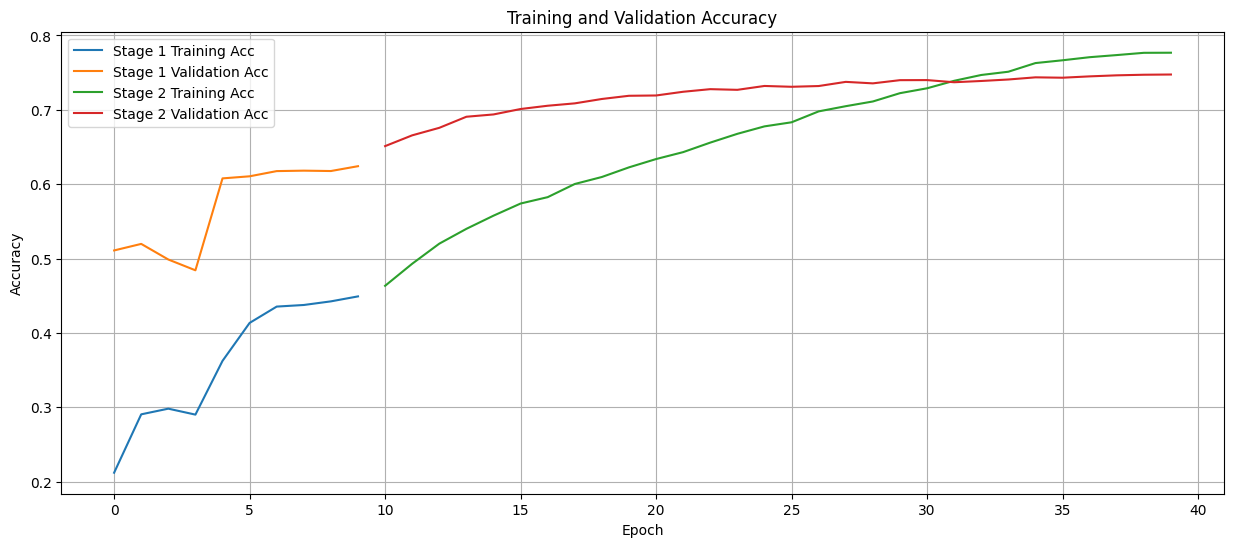

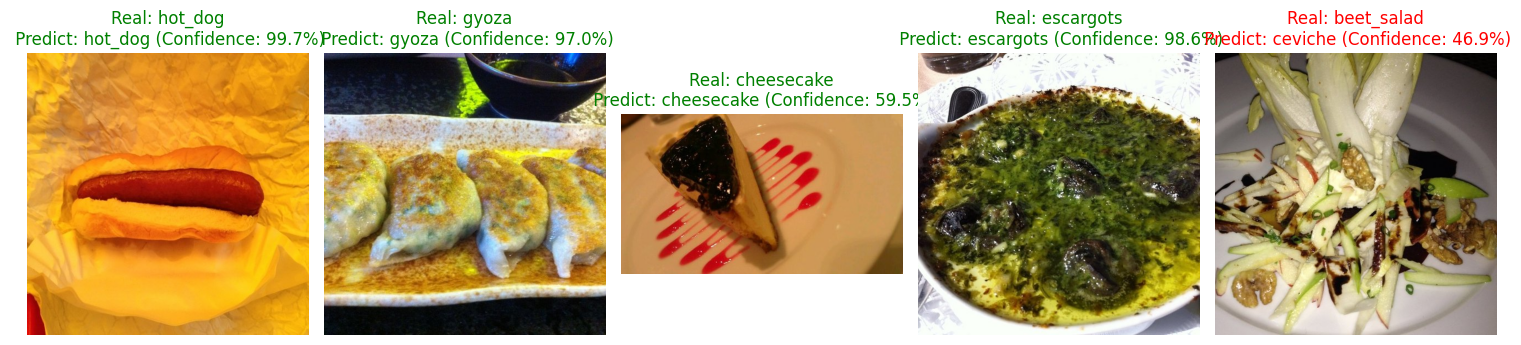

In [2]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# 强制关闭tf.data的INFO日志
tf.get_logger().setLevel(logging.ERROR)

# 再额外强制屏蔽底层日志
tf.autograph.set_verbosity(0)

# 直接禁止absl日志（Google库日志）
logging.getLogger('absl').setLevel('ERROR')


import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import warnings
from PIL import Image
import time
from collections import Counter
import logging



# 设置随机种子确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



os.makedirs('outputs', exist_ok=True)

# 加载数据集
print("正在加载Food-101数据集...")
dataset = load_dataset("ethz/food101")

# 基本信息
print(f"训练集样本数: {len(dataset['train'])}")
print(f"测试集样本数: {len(dataset['validation'])}")

# 获取所有类别
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"类别数量: {num_classes}")

# 创建类别平衡的数据集
def create_balanced_dataset(dataset_split, samples_per_class=300, max_samples=30000):
    """
    创建类别平衡的数据集，每个类别使用相同数量的样本
    
    参数:
    - dataset_split: 数据集分割
    - samples_per_class: 每个类别选择的样本数
    - max_samples: 最大样本总数限制
    
    返回:
    - 平衡后的样本索引列表
    """
    print(f"创建平衡数据集，目标每类{samples_per_class}个样本...")
    
    # 获取所有样本的标签
    all_indices = list(range(len(dataset_split)))
    random.shuffle(all_indices)  # 随机打乱所有索引
    
    # 按类别收集样本
    class_indices = {i: [] for i in range(num_classes)}
    
    # 第一遍：计算每个类别的样本数
    print("分析类别分布...")
    for idx in all_indices[:min(len(all_indices), 50000)]:  # 只分析部分样本以节省时间
        label = dataset_split[idx]['label']
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
    
    # 查看收集到的每个类别的样本数
    class_counts = {i: len(indices) for i, indices in class_indices.items()}
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    print(f"类别样本数范围: {min_count} - {max_count}")
    
    # 确保每个类别样本数相等，取最小值
    actual_samples_per_class = min(samples_per_class, min_count)
    print(f"实际每类样本数: {actual_samples_per_class}")
    
    # 第二遍：均衡采样
    balanced_indices = []
    for class_id in range(num_classes):
        # 如果某类别样本不足，获取所有样本；否则随机选择指定数量
        if len(class_indices[class_id]) <= actual_samples_per_class:
            balanced_indices.extend(class_indices[class_id])
        else:
            balanced_indices.extend(random.sample(class_indices[class_id], actual_samples_per_class))
    
    # 最终随机打乱
    random.shuffle(balanced_indices)
    
    # 如果样本总数超过max_samples，则截断
    if len(balanced_indices) > max_samples:
        balanced_indices = balanced_indices[:max_samples]
    
    print(f"创建了含有{len(balanced_indices)}个样本的平衡数据集")
    return balanced_indices

# 图像预处理函数
def preprocess_image(image, target_size=(224, 224)):
    """
    基本图像预处理：调整大小和标准化
    
    参数:
    - image: PIL图像对象或numpy数组
    - target_size: 目标图像尺寸，默认为224x224
    
    返回:
    - 预处理后的图像数组（归一化到[0,1]范围）
    """
    # 如果输入是PIL图像，转换为numpy数组
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # 如果是灰度图像，转换为RGB
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA图像
        image = image[:, :, :3]
    
    # 转换为TensorFlow张量
    image_tensor = tf.convert_to_tensor(image)
    
    # 调整图像大小
    image_resized = tf.image.resize(image_tensor, target_size)
    
    # 标准化到[0,1]范围
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    return image_normalized

# 创建TensorFlow数据集
def create_tf_dataset(indices, dataset_split, batch_size=32, is_training=False, shuffle_buffer=10000):
    """
    创建TensorFlow数据集
    
    参数:
    - indices: 数据样本的索引列表
    - dataset_split: HuggingFace数据集分割
    - batch_size: 批量大小
    - is_training: 是否为训练模式(决定是否使用数据增强)
    - shuffle_buffer: 用于打乱数据的缓冲区大小
    
    返回:
    - TensorFlow数据集
    """
    def gen():
        # 获取索引并(可选)打乱
        if is_training:
            random.shuffle(indices)
            
        for idx in indices:
            try:
                sample = dataset_split[idx]
                image = sample['image']
                label = sample['label']
                
                # 转换为numpy数组
                image_array = np.array(image)
                
                # 确保图像是RGB (3通道)
                if len(image_array.shape) == 2:  # 灰度图像
                    image_array = np.stack([image_array] * 3, axis=-1)
                elif image_array.shape[-1] == 4:  # RGBA图像
                    image_array = image_array[:, :, :3]
                    
                yield image_array, label
            except Exception as e:
                # print(f"处理样本 {idx} 时出错: {e}")
                continue
    
    # 创建数据集
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    try:
        import tensorflow_addons as tfa
        USE_TFA_ROTATE = True
    except ImportError:
        USE_TFA_ROTATE = False
        print("No tensorflow_addons!!!!")


    def _preprocess(image, label):
        # 转换 & 归一化
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (256, 256))  # 稍大些用于裁剪
    
        if is_training:
            # 随机裁剪为 224x224
            image = tf.image.random_crop(image, size=(224, 224, 3))
    
            # 随机翻转
            image = tf.image.random_flip_left_right(image)
    
            # 随机色彩增强
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
    
            # 随机旋转（需安装 tensorflow-addons）
            if USE_TFA_ROTATE:
                angle = tf.random.uniform([], -15, 15) * np.pi / 180
                image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    
            # 添加轻度高斯噪声
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
        else:
            # 验证阶段：中心裁剪
            image = tf.image.resize_with_crop_or_pad(image, 224, 224)

        # ✅ 新增：把整数 label 转成 one-hot
        label = tf.one_hot(label, num_classes)
    
        return image, label

    
    # 应用预处理
    ds = ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        ds = ds.repeat()
    
    # 打乱、批处理和预取
    if is_training:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 创建平衡的训练和验证数据集
print("创建平衡的训练和验证数据集...")
train_balanced_indices = create_balanced_dataset(
    dataset['train'], 
    samples_per_class=500,  # 每个类别使用400张图像
    max_samples=50000       # 总样本数上限仍为40000
)

val_balanced_indices = create_balanced_dataset(
    dataset['validation'], 
    samples_per_class=100,   # 每个类别使用50张图像
    max_samples=10000        # 总样本数上限仍为5000 
)

# 检查类别分布是否真的平衡
print("验证类别分布...")
train_balanced_labels = [dataset['train'][i]['label'] for i in train_balanced_indices]
label_counter = Counter(train_balanced_labels)

print(f"训练数据每个类别样本数 (总计{len(train_balanced_indices)}张图像):")
for class_id in range(min(10, len(label_counter))):
    class_name = food_classes[class_id]
    count = label_counter[class_id]
    print(f"类别 {class_id} ({class_name}): {count} 样本")


# 创建数据集
BATCH_SIZE = 32
print("创建训练和验证数据集...")

train_ds = create_tf_dataset(
    train_balanced_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=len(train_balanced_indices)
)

val_ds = create_tf_dataset(
    val_balanced_indices, 
    dataset['validation'], 
    batch_size=BATCH_SIZE, 
    is_training=False
)

# 检查数据集
print("检查数据集...")
for images, labels in train_ds.take(1):
    print(f"批次形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"图像值范围: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")

# 构建模型
def build_model(num_classes=101, freeze_base=True):
    """
    构建基于ResNet50的模型
    
    参数:
    - num_classes: 分类数量
    - freeze_base: 是否冻结ResNet50的权重
    
    返回:
    - 编译好的模型
    """
    # 加载预训练的ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # 设置基础模型是否可训练
    base_model.trainable = not freeze_base
    
    # 如果部分解冻，只解冻最后的一些层
    if not freeze_base:
        # 冻结前面的层，只训练后面的层
        for layer in base_model.layers[:-20]:
            layer.trainable = False
    
    # 构建完整模型
    model = tf.keras.Sequential([
        # 预处理层
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x * 255.0)),
        
        # 基础模型
        base_model,
        
        # 分类头
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.6),# 增加到0.6
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    return model, base_model

# 创建模型
print(f"创建含有 {num_classes} 个分类的模型...")
model, base_model = build_model(num_classes=num_classes, freeze_base=True)

# 显示模型结构摘要
model.summary()

# 设置训练参数
EPOCHS_STAGE1 = 15  # 保持原来的轮数
STEPS_PER_EPOCH = None  # 使用None会自动计算步数

# 设置回调函数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,  # 增加patience以允许模型继续训练
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第一阶段训练
print("开始第一阶段训练 (冻结基础模型)...")
start_time = time.time()

steps_per_epoch = len(train_balanced_indices) // BATCH_SIZE
history1 = model.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,  # 👈 必加
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


stage1_time = time.time() - start_time
print(f"第一阶段训练完成，耗时: {stage1_time:.2f} 秒")

# 保存第一阶段模型
model.save('outputs/food101_stage1_model.keras')
print("第一阶段模型已保存")

# 第二阶段：解冻部分基础模型进行微调
print("\n开始第二阶段训练 (解冻部分基础模型)...")

# 获取ResNet50基础模型
base_model = model.layers[1]  # 索引0是Lambda层，1是ResNet50

# 解冻部分基础模型
base_model.trainable = True

# 冻结前面的层，只训练最后的30层
print("解冻ResNet50的最后20层...")
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 查看有多少层被解冻
trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
total_layers = len(base_model.layers)
print(f"ResNet50基础模型共有 {total_layers} 层，其中 {trainable_layers} 层被设为可训练")

# 使用较小的学习率重新编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 降低学习率进行微调
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# 设置第二阶段回调
callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # 增加patience以允许模型继续训练
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # 使用更温和的学习率衰减
        patience=3,  # 增加patience
        min_lr=1e-7,
        verbose=1
    )
]

# 第二阶段训练
EPOCHS_STAGE2 = 30  # 保持原来的轮数
print(f"开始第二阶段训练，共 {EPOCHS_STAGE2} 轮...")
stage2_start_time = time.time()

# ✅ 重新创建训练数据集用于第二阶段微调（数据增强会重新打乱）
print("\n重新生成训练数据集用于第二阶段训练...")

train_ds2 = create_tf_dataset(
    train_balanced_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE, 
    is_training=True,
    shuffle_buffer=len(train_balanced_indices)
)



history2 = model.fit(
    train_ds2,
    epochs=EPOCHS_STAGE2,
    steps_per_epoch=steps_per_epoch,  # 👈 必加
    validation_data=val_ds,
    callbacks=callbacks_stage2,
    verbose=1
)

stage2_time = time.time() - stage2_start_time
total_time = time.time() - start_time

print(f"第二阶段训练完成，耗时: {stage2_time:.2f} 秒")
print(f"总训练时间: {total_time:.2f} 秒")

# 保存最终模型
model.save('outputs/food101_final_model.keras')
print("最终模型已保存")

# 显示第一阶段和第二阶段训练结果
final_train_acc1 = history1.history['accuracy'][-1]
final_val_acc1 = history1.history['val_accuracy'][-1]
best_val_acc1 = max(history1.history['val_accuracy'])

final_train_acc2 = history2.history['accuracy'][-1]
final_val_acc2 = history2.history['val_accuracy'][-1]
best_val_acc2 = max(history2.history['val_accuracy'])

print("\n训练结果摘要:")
print(f"第一阶段最终训练准确率: {final_train_acc1:.4f}")
print(f"第一阶段最终验证准确率: {final_val_acc1:.4f}")
print(f"第一阶段最佳验证准确率: {best_val_acc1:.4f}")
print(f"第二阶段最终训练准确率: {final_train_acc2:.4f}")
print(f"第二阶段最终验证准确率: {final_val_acc2:.4f}")
print(f"第二阶段最佳验证准确率: {best_val_acc2:.4f}")

# 可视化训练历史
plt.figure(figsize=(15, 6))

# 第一阶段epoch数
epochs_stage1 = len(history1.history['accuracy'])

# 绘制准确率曲线
plt.plot(range(epochs_stage1), history1.history['accuracy'], label='Stage 1 Training Acc')
plt.plot(range(epochs_stage1), history1.history['val_accuracy'], label='Stage 1 Validation Acc')

epochs_stage2 = len(history2.history['accuracy'])
plt.plot(range(epochs_stage1, epochs_stage1 + epochs_stage2), history2.history['accuracy'], label='Stage 2 Training Acc')
plt.plot(range(epochs_stage1, epochs_stage1 + epochs_stage2), history2.history['val_accuracy'], label='Stage 2 Validation Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)


# 在几个随机样本上测试模型
def test_on_random_samples(model, dataset_split, num_samples=5):
    # 随机选择样本
    indices = random.sample(range(len(dataset_split)), num_samples)
    
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(indices):
        # 获取样本
        sample = dataset_split[idx]
        image = np.array(sample['image'])
        true_label = sample['label']
        
        # 预处理图像
        img = preprocess_image(image)
        img = tf.expand_dims(img, 0)  # 添加批次维度
        
        # 预测
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        
        # 显示图像和预测结果
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample['image'])
        
        # 给出正确/错误的颜色标记
        color = 'green' if predicted_label == true_label else 'red'
        
        plt.title(
            f"Real: {food_classes[true_label]}\n Predict: {food_classes[predicted_label]} (Confidence: {predictions[0][predicted_label]*100:.1f}%)", 
            color=color
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/prediction_samples.png')
    plt.show()

print("\n在随机样本上测试模型...")
test_on_random_samples(model, dataset['validation'], num_samples=5)

# 改进4： 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在加载Food-101数据集...
训练集样本数: 75750
测试集样本数: 25250
类别数量: 101
创建平衡的训练和验证数据集...
创建平衡数据集，目标每类500个样本...
分析类别分布...
类别样本数范围: 461 - 500
实际每类样本数: 461
创建了含有46561个样本的平衡数据集
创建平衡数据集，目标每类100个样本...
分析类别分布...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


类别样本数范围: 100 - 100
实际每类样本数: 100
创建了含有10000个样本的平衡数据集
验证类别分布...
训练数据每个类别样本数 (总计46561张图像):
类别 0 (apple_pie): 461 样本
类别 1 (baby_back_ribs): 461 样本
类别 2 (baklava): 461 样本
类别 3 (beef_carpaccio): 461 样本
类别 4 (beef_tartare): 461 样本
类别 5 (beet_salad): 461 样本
类别 6 (beignets): 461 样本
类别 7 (bibimbap): 461 样本
类别 8 (bread_pudding): 461 样本
类别 9 (breakfast_burrito): 461 样本
创建第一阶段训练和验证数据集 (图像尺寸: 224x224)...
No tensorflow_addons!!!!
No tensorflow_addons!!!!
检查数据集...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.16.2 and is not supported. 
Some things might work, some things might not.
If you 

批次形状: (32, 224, 224, 3)
标签形状: (32, 101)
图像值范围: [0.0, 1.0]
创建第一阶段模型 (图像尺寸: 224x224)...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,405 (92.11 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

开始第一阶段训练 (冻结基础模型, 图像尺寸: 224x224)...
Epoch 1/15
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1429 - loss: 5.6719
Epoch 1: val_accuracy improved from -inf to 0.49380, saving model to outputs/food101_best_model_stage1.keras


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1455/1455 ━━━━━━━━━━━━━━━━━━━━ 132s 65ms/step - accuracy: 0.1430 - loss: 5.6715 - val_accuracy: 0.4938 - val_loss: 2.5563 - learning_rate: 0.0010
Epoch 2/15
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2587 - loss: 3.9663
Epoch 2: val_accuracy did not improve from 0.49380
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 101s 69ms/step - accuracy: 0.2588 - loss: 3.9663 - val_accuracy: 0.4892 - val_loss: 2.5325 - learning_rate: 0.0010
Epoch 3/15
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2666 - loss: 3.9402
Epoch 3: val_accuracy did not improve from 0.49380
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 114s 78ms/step - accuracy: 0.2666 - loss: 3.9402 - val_accuracy: 0.4661 - val_loss: 2.7242 - learning_rate: 0.0010
Epoch 4/15
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2591 - loss: 4.2037
Epoch 4: val_accuracy did not improve from 0.49380

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 107s 74ms/step - accuracy: 0.2591

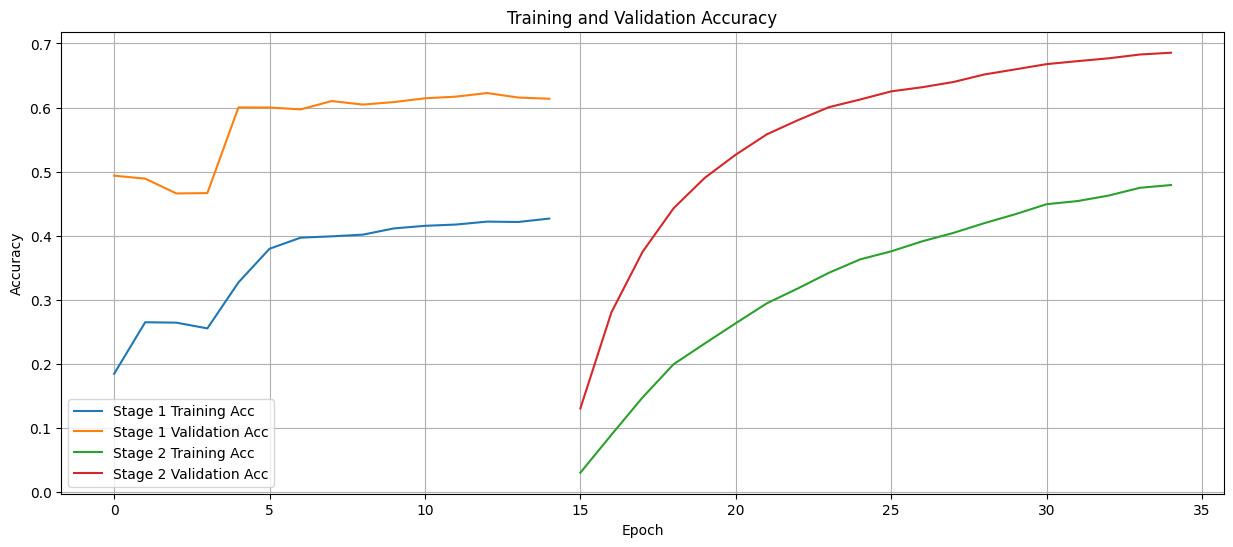


在随机样本上测试模型...


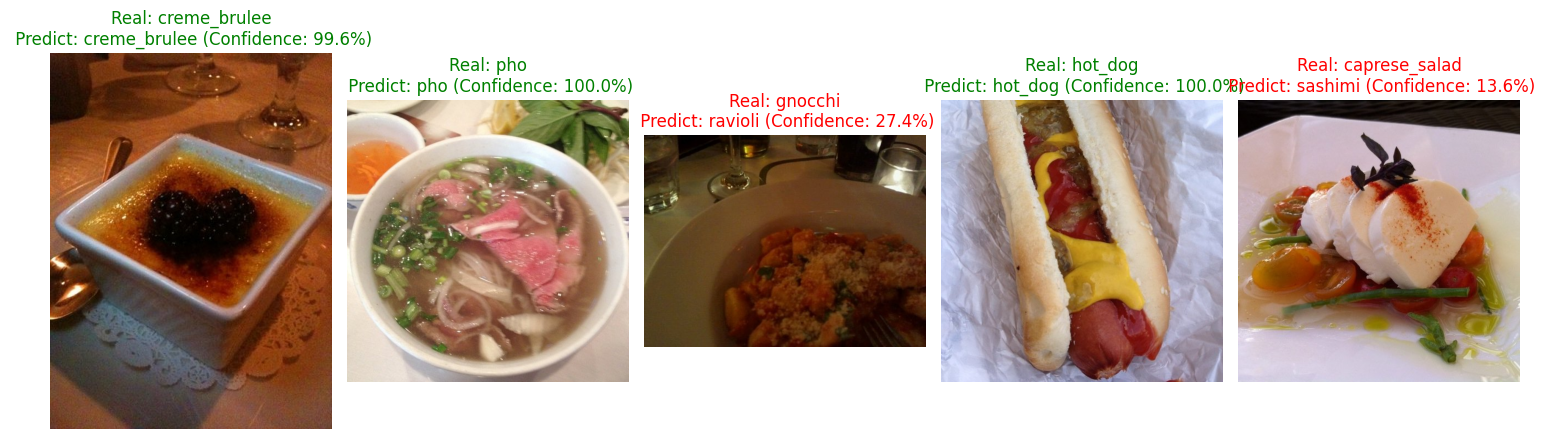

In [1]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# 强制关闭tf.data的INFO日志
tf.get_logger().setLevel(logging.ERROR)

# 再额外强制屏蔽底层日志
tf.autograph.set_verbosity(0)

# 直接禁止absl日志（Google库日志）
logging.getLogger('absl').setLevel('ERROR')


import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
import warnings
from PIL import Image
import time
from collections import Counter 
import logging



# 设置随机种子确保可重复性
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



os.makedirs('outputs', exist_ok=True)

# 加载数据集
print("正在加载Food-101数据集...")
dataset = load_dataset("ethz/food101")

# 基本信息
print(f"训练集样本数: {len(dataset['train'])}")
print(f"测试集样本数: {len(dataset['validation'])}")

# 获取所有类别
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)
print(f"类别数量: {num_classes}")

# 创建类别平衡的数据集
def create_balanced_dataset(dataset_split, samples_per_class=300, max_samples=30000):
    """
    创建类别平衡的数据集，每个类别使用相同数量的样本
    
    参数:
    - dataset_split: 数据集分割
    - samples_per_class: 每个类别选择的样本数
    - max_samples: 最大样本总数限制
    
    返回:
    - 平衡后的样本索引列表
    """
    print(f"创建平衡数据集，目标每类{samples_per_class}个样本...")
    
    # 获取所有样本的标签
    all_indices = list(range(len(dataset_split)))
    random.shuffle(all_indices)  # 随机打乱所有索引
    
    # 按类别收集样本
    class_indices = {i: [] for i in range(num_classes)}
    
    # 第一遍：计算每个类别的样本数
    print("分析类别分布...")
    for idx in all_indices[:min(len(all_indices), 50000)]:  # 只分析部分样本以节省时间
        label = dataset_split[idx]['label']
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
    
    # 查看收集到的每个类别的样本数
    class_counts = {i: len(indices) for i, indices in class_indices.items()}
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    print(f"类别样本数范围: {min_count} - {max_count}")
    
    # 确保每个类别样本数相等，取最小值
    actual_samples_per_class = min(samples_per_class, min_count)
    print(f"实际每类样本数: {actual_samples_per_class}")
    
    # 第二遍：均衡采样
    balanced_indices = []
    for class_id in range(num_classes):
        # 如果某类别样本不足，获取所有样本；否则随机选择指定数量
        if len(class_indices[class_id]) <= actual_samples_per_class:
            balanced_indices.extend(class_indices[class_id])
        else:
            balanced_indices.extend(random.sample(class_indices[class_id], actual_samples_per_class))
    
    # 最终随机打乱
    random.shuffle(balanced_indices)
    
    # 如果样本总数超过max_samples，则截断
    if len(balanced_indices) > max_samples:
        balanced_indices = balanced_indices[:max_samples]
    
    print(f"创建了含有{len(balanced_indices)}个样本的平衡数据集")
    return balanced_indices

# 图像预处理函数
def preprocess_image(image, target_size=(224, 224)):
    """
    基本图像预处理：调整大小和标准化
    
    参数:
    - image: PIL图像对象或numpy数组
    - target_size: 目标图像尺寸，默认为224x224
    
    返回:
    - 预处理后的图像数组（归一化到[0,1]范围）
    """
    # 如果输入是PIL图像，转换为numpy数组
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # 如果是灰度图像，转换为RGB
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[-1] == 4:  # RGBA图像
        image = image[:, :, :3]
    
    # 转换为TensorFlow张量
    image_tensor = tf.convert_to_tensor(image)
    
    # 调整图像大小
    image_resized = tf.image.resize(image_tensor, target_size)
    
    # 标准化到[0,1]范围
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    
    return image_normalized


def apply_mixup(images, labels, alpha=0.2):
    """
    应用MixUp数据增强
    
    参数:
    - images: 批次图像
    - labels: one-hot编码的标签
    - alpha: Beta分布参数
    
    返回:
    - 混合后的图像和标签
    """
    # 获取批次大小
    batch_size = tf.shape(images)[0]
    
    # 生成随机索引
    indices = tf.random.shuffle(tf.range(batch_size))
    
    # 使用TensorFlow的随机函数
    # 创建一个接近Beta分布的变换
    gamma_1 = tf.random.gamma(shape=[batch_size], alpha=alpha)
    gamma_2 = tf.random.gamma(shape=[batch_size], alpha=alpha)
    weight = gamma_1 / (gamma_1 + gamma_2)
    weight = tf.reshape(weight, (batch_size, 1, 1, 1))
    
    # 混合图像
    mixed_images = weight * images + (1 - weight) * tf.gather(images, indices)
    
    # 混合标签
    weight_labels = tf.reshape(weight, (batch_size, 1))
    mixed_labels = weight_labels * labels + (1 - weight_labels) * tf.gather(labels, indices)
    
    return mixed_images, mixed_labels

    
# 创建TensorFlow数据集
def create_tf_dataset(indices, dataset_split, batch_size=32, is_training=False, image_size=224, shuffle_buffer=10000, use_mixup=False, mixup_prob=0.5, alpha=0.2):
    """
    创建TensorFlow数据集
    
    参数:
    - indices: 数据样本的索引列表
    - dataset_split: HuggingFace数据集分割
    - batch_size: 批量大小
    - is_training: 是否为训练模式(决定是否使用数据增强)
    - image_size: 图像大小 (正方形)
    - shuffle_buffer: 用于打乱数据的缓冲区大小
    - use_mixup: 是否使用MixUp数据增强
    - mixup_prob: 应用MixUp的概率
    - alpha: MixUp的Beta分布参数
    
    返回:
    - TensorFlow数据集
    """
    def gen():
        # 获取索引并(可选)打乱
        if is_training:
            random.shuffle(indices)
            
        for idx in indices:
            try:
                sample = dataset_split[idx]
                image = sample['image']
                label = sample['label']
                
                # 转换为numpy数组
                image_array = np.array(image)
                
                # 确保图像是RGB (3通道)
                if len(image_array.shape) == 2:  # 灰度图像
                    image_array = np.stack([image_array] * 3, axis=-1)
                elif image_array.shape[-1] == 4:  # RGBA图像
                    image_array = image_array[:, :, :3]
                    
                yield image_array, label
            except Exception as e:
                # print(f"处理样本 {idx} 时出错: {e}")
                continue
    
    # 创建数据集
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    try:
        import tensorflow_addons as tfa
        USE_TFA_ROTATE = True
    except ImportError:
        USE_TFA_ROTATE = False
        print("No tensorflow_addons!!!!")

    # 添加更大的尺寸来为裁剪准备
    crop_padding = 32  # 额外的填充用于裁剪
    resize_size = image_size + crop_padding

    def _preprocess(image, label):
        # 转换 & 归一化
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (resize_size, resize_size))  # 稍大些用于裁剪
    
        if is_training:
            # 随机裁剪为目标尺寸
            image = tf.image.random_crop(image, size=(image_size, image_size, 3))
    
            # 随机翻转
            image = tf.image.random_flip_left_right(image)
    
            # 随机色彩增强
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
    
            # 随机旋转（需安装 tensorflow-addons）
            if USE_TFA_ROTATE:
                angle = tf.random.uniform([], -15, 15) * np.pi / 180
                image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    
            # 添加轻度高斯噪声
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
        else:
            # 验证阶段：中心裁剪
            image = tf.image.resize_with_crop_or_pad(image, image_size, image_size)

        # 把整数 label 转成 one-hot
        label = tf.one_hot(label, num_classes)
    
        return image, label

    
    # 应用预处理
    ds = ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        ds = ds.repeat()
    
    # 打乱、批处理和预取
    if is_training:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    
    ds = ds.batch(batch_size)

    # 在训练模式下添加MixUp
    if is_training and use_mixup:
        # 创建一个函数来随机决定是否应用MixUp
        def random_apply_mixup(images, labels):
            # 以一定概率应用MixUp
            should_apply = tf.cast(tf.random.uniform([], 0, 1) < mixup_prob, tf.bool)
            # 有条件地应用MixUp
            return tf.cond(
                should_apply,
                lambda: apply_mixup(images, labels, alpha),
                lambda: (images, labels)
            )
        
        # 应用MixUp
        ds = ds.map(random_apply_mixup, num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 创建平衡的训练和验证数据集
print("创建平衡的训练和验证数据集...")
train_balanced_indices = create_balanced_dataset(
    dataset['train'], 
    samples_per_class=500,  # 每个类别使用500张图像
    max_samples=50000       # 总样本数上限
)

val_balanced_indices = create_balanced_dataset(
    dataset['validation'], 
    samples_per_class=100,   # 每个类别使用100张图像
    max_samples=10000        # 总样本数上限
)

# 检查类别分布是否真的平衡
print("验证类别分布...")
train_balanced_labels = [dataset['train'][i]['label'] for i in train_balanced_indices]
label_counter = Counter(train_balanced_labels)

print(f"训练数据每个类别样本数 (总计{len(train_balanced_indices)}张图像):")
for class_id in range(min(10, len(label_counter))):
    class_name = food_classes[class_id]
    count = label_counter[class_id]
    print(f"类别 {class_id} ({class_name}): {count} 样本")


# 创建数据集 - 阶段1 (较小尺寸)
BATCH_SIZE = 32
IMAGE_SIZE_STAGE1 = 224  # 第一阶段使用小尺寸
print(f"创建第一阶段训练和验证数据集 (图像尺寸: {IMAGE_SIZE_STAGE1}x{IMAGE_SIZE_STAGE1})...")

train_ds = create_tf_dataset(
    train_balanced_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE, 
    is_training=True,
    image_size=IMAGE_SIZE_STAGE1,
    shuffle_buffer=len(train_balanced_indices),
    use_mixup=True,       # 启用MixUp
    mixup_prob=0.5,       # 50%的批次应用MixUp
    alpha=0.2             # MixUp强度参数
)

val_ds = create_tf_dataset(
    val_balanced_indices, 
    dataset['validation'], 
    batch_size=BATCH_SIZE, 
    is_training=False,
    image_size=IMAGE_SIZE_STAGE1
)

# 检查数据集
print("检查数据集...")
for images, labels in train_ds.take(1):
    print(f"批次形状: {images.shape}")
    print(f"标签形状: {labels.shape}")
    print(f"图像值范围: [{tf.reduce_min(images).numpy()}, {tf.reduce_max(images).numpy()}]")

# 构建模型
def build_model(num_classes=101, freeze_base=True, image_size=224):
    """
    构建基于ResNet50的模型
    
    参数:
    - num_classes: 分类数量
    - freeze_base: 是否冻结ResNet50的权重
    - image_size: 输入图像尺寸
    
    返回:
    - 编译好的模型
    """
    # 加载预训练的ResNet50
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )
    
    # 设置基础模型是否可训练
    base_model.trainable = not freeze_base
    
    # 如果部分解冻，只解冻最后的一些层
    if not freeze_base:
        # 冻结前面的层，只训练后面的层
        for layer in base_model.layers[:-20]:
            layer.trainable = False
    
    # 构建完整模型
    model = tf.keras.Sequential([
        # 预处理层
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x * 255.0)),
        
        # 基础模型
        base_model,
        
        # 分类头
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.6),# 增加到0.6
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    return model, base_model

# 创建第一阶段模型 (较小尺寸)
print(f"创建第一阶段模型 (图像尺寸: {IMAGE_SIZE_STAGE1}x{IMAGE_SIZE_STAGE1})...")
model, base_model = build_model(num_classes=num_classes, freeze_base=True, image_size=IMAGE_SIZE_STAGE1)

# 显示模型结构摘要
model.summary()

# 设置训练参数
EPOCHS_STAGE1 = 15
STEPS_PER_EPOCH = None  # 使用None会自动计算步数

# 设置回调函数
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,  # 增加patience以允许模型继续训练
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# 第一阶段训练 (较小尺寸)
print(f"开始第一阶段训练 (冻结基础模型, 图像尺寸: {IMAGE_SIZE_STAGE1}x{IMAGE_SIZE_STAGE1})...")
start_time = time.time()

steps_per_epoch = len(train_balanced_indices) // BATCH_SIZE
history1 = model.fit(
    train_ds,
    epochs=EPOCHS_STAGE1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


stage1_time = time.time() - start_time
print(f"第一阶段训练完成，耗时: {stage1_time:.2f} 秒")

# 保存第一阶段模型
model.save('outputs/food101_stage1_model.keras')
print("第一阶段模型已保存")

# ========== 第二阶段：使用更大尺寸直接微调 ==========
IMAGE_SIZE_STAGE2 = 320  # 第二阶段使用更大尺寸
print(f"\n开始第二阶段训练 (大图像尺寸: {IMAGE_SIZE_STAGE2}x{IMAGE_SIZE_STAGE2}, 解冻部分层)...")

# 创建第二阶段模型 (大尺寸)
print(f"创建第二阶段模型 (图像尺寸: {IMAGE_SIZE_STAGE2}x{IMAGE_SIZE_STAGE2})...")
model_stage2, base_model_stage2 = build_model(num_classes=num_classes, freeze_base=False, image_size=IMAGE_SIZE_STAGE2)

# 解冻部分基础模型
base_model_stage2.trainable = True

# 冻结前面的层，只训练最后的40层
print("解冻ResNet50的最后40层...")
for layer in base_model_stage2.layers[:-40]:
    layer.trainable = False

# 查看有多少层被解冻
trainable_layers = sum(1 for layer in base_model_stage2.layers if layer.trainable)
total_layers = len(base_model_stage2.layers)
print(f"ResNet50基础模型共有 {total_layers} 层，其中 {trainable_layers} 层被设为可训练")

# 使用较小的学习率重新编译模型
model_stage2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),  # 更小的学习率
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# 创建第二阶段数据集 (大尺寸)
print(f"创建第二阶段训练和验证数据集 (图像尺寸: {IMAGE_SIZE_STAGE2}x{IMAGE_SIZE_STAGE2})...")

train_ds2 = create_tf_dataset(
    train_balanced_indices, 
    dataset['train'], 
    batch_size=BATCH_SIZE // 2,  # 由于图像更大，减小批量大小
    is_training=True,
    image_size=IMAGE_SIZE_STAGE2,
    shuffle_buffer=len(train_balanced_indices),
    use_mixup=True,
    mixup_prob=0.3,  # 降低MixUp概率
    alpha=0.1       # 降低MixUp强度
)

val_ds2 = create_tf_dataset(
    val_balanced_indices, 
    dataset['validation'], 
    batch_size=BATCH_SIZE // 2,
    is_training=False,
    image_size=IMAGE_SIZE_STAGE2
)

# 设置第二阶段回调
callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='outputs/food101_best_model_stage2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,  # 使用更大的patience
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# 第二阶段训练
EPOCHS_STAGE2 = 20
print(f"开始第二阶段训练，共 {EPOCHS_STAGE2} 轮...")
stage2_start_time = time.time()

# 由于批量大小变化，需要重新计算steps_per_epoch
steps_per_epoch_stage2 = len(train_balanced_indices) // (BATCH_SIZE // 2)

history2 = model_stage2.fit(
    train_ds2,
    epochs=EPOCHS_STAGE2,
    steps_per_epoch=steps_per_epoch_stage2,
    validation_data=val_ds2,
    callbacks=callbacks_stage2,
    verbose=1
)

stage2_time = time.time() - stage2_start_time
total_time = time.time() - start_time

print(f"第二阶段训练完成，耗时: {stage2_time:.2f} 秒")
print(f"总训练时间: {total_time:.2f} 秒")

# 保存最终模型
model_stage2.save('outputs/food101_final_model.keras')
print("最终模型已保存")

# 显示训练结果
final_train_acc1 = history1.history['accuracy'][-1]
final_val_acc1 = history1.history['val_accuracy'][-1]
best_val_acc1 = max(history1.history['val_accuracy'])

final_train_acc2 = history2.history['accuracy'][-1]
final_val_acc2 = history2.history['val_accuracy'][-1]
best_val_acc2 = max(history2.history['val_accuracy'])

print("\n训练结果摘要:")
print(f"第一阶段(224x224)最终训练准确率: {final_train_acc1:.4f}")
print(f"第一阶段(224x224)最终验证准确率: {final_val_acc1:.4f}")
print(f"第一阶段(224x224)最佳验证准确率: {best_val_acc1:.4f}")

print(f"第二阶段(320x320微调)最终训练准确率: {final_train_acc2:.4f}")
print(f"第二阶段(320x320微调)最终验证准确率: {final_val_acc2:.4f}")
print(f"第二阶段(320x320微调)最佳验证准确率: {best_val_acc2:.4f}")

# 可视化训练历史
plt.figure(figsize=(15, 6))

# 第一阶段epoch数
epochs_stage1 = len(history1.history['accuracy'])

# 绘制准确率曲线
plt.plot(range(epochs_stage1), history1.history['accuracy'], label='Stage 1 Training Acc')
plt.plot(range(epochs_stage1), history1.history['val_accuracy'], label='Stage 1 Validation Acc')

epochs_stage2 = len(history2.history['accuracy'])
plt.plot(range(epochs_stage1, epochs_stage1 + epochs_stage2), history2.history['accuracy'], label='Stage 2 Training Acc')
plt.plot(range(epochs_stage1, epochs_stage1 + epochs_stage2), history2.history['val_accuracy'], label='Stage 2 Validation Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('outputs/training_history.png')
plt.show()


# 在几个随机样本上测试模型
def test_on_random_samples(model, dataset_split, num_samples=5, image_size=320):
    # 随机选择样本
    indices = random.sample(range(len(dataset_split)), num_samples)
    
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(indices):
        # 获取样本
        sample = dataset_split[idx]
        image = np.array(sample['image'])
        true_label = sample['label']
        
        # 预处理图像
        img = preprocess_image(image, target_size=(image_size, image_size))
        img = tf.expand_dims(img, 0)  # 添加批次维度
        
        # 预测
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        
        # 显示图像和预测结果
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample['image'])
        
        # 给出正确/错误的颜色标记
        color = 'green' if predicted_label == true_label else 'red'
        
        plt.title(
            f"Real: {food_classes[true_label]}\n Predict: {food_classes[predicted_label]} (Confidence: {predictions[0][predicted_label]*100:.1f}%)", 
            color=color
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/prediction_samples.png')
    plt.show()

print("\n在随机样本上测试模型...")
test_on_random_samples(model_stage2, dataset['validation'], num_samples=5, image_size=IMAGE_SIZE_STAGE2)

In [1]:
# 完整训练脚本，整合了：
# - 标签平滑
# - MixUp 增强
# - 冻结/解冻策略
# - 多阶段训练
# - 指定图像大小 / dropout / 解冻层数

import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
logging.getLogger('absl').setLevel('ERROR')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 加载数据集
print("加载Food101...")
dataset = load_dataset("ethz/food101")
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# ======================== 创建平衡索引 ======================
def create_balanced_indices(split, per_class):
    class_to_indices = {i: [] for i in range(num_classes)}
    for i, sample in enumerate(split):
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
    indices = sum([class_to_indices[i] for i in range(num_classes)], [])
    random.shuffle(indices)
    return indices

train_indices = create_balanced_indices(dataset['train'], 500)
val_indices = create_balanced_indices(dataset['validation'], 100)

# ===================== 数据增强（含MixUp） =====================
def apply_mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    beta = tf.random.gamma([batch_size], alpha) / tf.reduce_sum(tf.random.gamma([batch_size], alpha), axis=0)
    beta = tf.reshape(beta, (batch_size, 1, 1, 1))
    beta_y = tf.reshape(beta, (batch_size, 1))
    return beta * images + (1 - beta) * tf.gather(images, indices), beta_y * labels + (1 - beta_y) * tf.gather(labels, indices)

def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True, mixup=False):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, (image_size+32, image_size+32))
        if is_training:
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
        else:
            img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    if is_training and mixup:
        ds = ds.map(lambda x, y: apply_mixup(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ========================= 构建模型 =========================
def build_model(image_size=224, dropout=0.5, label_smooth=0.1, unfreeze_layers=0):
    base = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x*255.)),
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3 if unfreeze_layers == 0 else 1e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    return model

# ========================= 模型训练 =========================
def train_model():
    BATCH_SIZE = 32
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 320

    # 阶段1
    train_ds1 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True, mixup=True)
    val_ds1 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)

    model1 = build_model(image_size=IMAGE_SIZE1, dropout=0.5, label_smooth=0.1, unfreeze_layers=0)
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=15,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage1.keras', save_best_only=True)
               ])

    # 阶段2
    train_ds2 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE//2, is_training=True, mixup=True)
    val_ds2 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE//2, is_training=False)

    model2 = build_model(image_size=IMAGE_SIZE2, dropout=0.5, label_smooth=0.1, unfreeze_layers=30)
    model2.set_weights(model1.get_weights())  # 权重继承

    model2.fit(train_ds2, validation_data=val_ds2,
               steps_per_epoch=len(train_indices)//(BATCH_SIZE//2),
               validation_steps=len(val_indices)//(BATCH_SIZE//2),
               epochs=20,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage2.keras', save_best_only=True)
               ])

    model2.save('outputs/final_model.keras')
    print("训练完成，模型已保存！")

# ========================= 运行训练 =========================
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    train_model()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载Food101...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 108s 63ms/step - accuracy: 0.2316 - loss: 4.8006 - val_accuracy: 0.5492 - val_loss: 2.4155
Epoch 2/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 98s 62ms/step - accuracy: 0.3728 - loss: 3.4775 - val_accuracy: 0.5546 - val_loss: 2.3597
Epoch 3/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - accuracy: 0.3943 - loss: 3.3493 - val_accuracy: 0.5658 - val_loss: 2.3848
Epoch 4/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 111s 70ms/step - accuracy: 0.3771 - loss: 3.5708 - val_accuracy: 0.5629 - val_loss: 2.4537
Epoch 5/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 112s 71ms/step - accuracy: 0.3758 - loss: 3.7695 - val_accuracy: 0.5618 - val_loss: 2.5281
Epoch 6/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - accuracy: 0.3688 - loss: 3.9613 - val_accuracy: 0.5518 - val_loss: 2.6590
Epoch 1/20
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 306s 93ms/step - accuracy: 0.3935 - loss: 3.3042 - val_accuracy: 0.6846 - val_loss: 1.9890
Epoch 2/20
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 302s 96ms/step - accuracy: 0.4752 - los

# 改进5： 整合上一步保存的模型， 改进数据增强，增加二阶段的轮次

In [1]:
# 完整训练脚本，整合了：
# - 标签平滑
# - 增强版MixUp和数据增强
# - 冻结/解冻策略
# - 多阶段训练
# - 指定图像大小 / dropout / 解冻层数

import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
logging.getLogger('absl').setLevel('ERROR')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 加载数据集
print("加载Food101...")
dataset = load_dataset("ethz/food101")
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# ======================== 创建平衡索引 ======================
def create_balanced_indices(split, per_class):
    class_to_indices = {i: [] for i in range(num_classes)}
    for i, sample in enumerate(split):
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
    indices = sum([class_to_indices[i] for i in range(num_classes)], [])
    random.shuffle(indices)
    return indices

train_indices = create_balanced_indices(dataset['train'], 500)
val_indices = create_balanced_indices(dataset['validation'], 100)

# ===================== 增强版数据增强（含MixUp） =====================
def apply_mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    beta = tf.random.gamma([batch_size], alpha) / tf.reduce_sum(tf.random.gamma([batch_size], alpha), axis=0)
    beta = tf.reshape(beta, (batch_size, 1, 1, 1))
    beta_y = tf.reshape(beta, (batch_size, 1))
    return beta * images + (1 - beta) * tf.gather(images, indices), beta_y * labels + (1 - beta_y) * tf.gather(labels, indices)

def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True, mixup=False):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, (image_size+32, image_size+32))
        if is_training:
            # 基础增强
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            
            # 颜色增强
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            img = tf.image.random_hue(img, 0.1)
            
            # 添加高斯噪声
            noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
            img = tf.clip_by_value(img + noise, 0.0, 1.0)
        else:
            img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    if is_training and mixup:
        ds = ds.map(lambda x, y: apply_mixup(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ========================= 构建模型 =========================
def build_model(image_size=224, dropout=0.5, label_smooth=0.1, unfreeze_layers=0):
    base = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x*255.)),
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3 if unfreeze_layers == 0 else 1e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    return model

# ========================= 模型训练 =========================
def train_model():
    BATCH_SIZE = 32
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 320

    # 阶段1
    train_ds1 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True, mixup=True)
    val_ds1 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)

    model1 = build_model(image_size=IMAGE_SIZE1, dropout=0.5, label_smooth=0.1, unfreeze_layers=0)
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=15,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage1.keras', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
               ])

    # 阶段2
    train_ds2 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE//2, is_training=True, mixup=True)
    val_ds2 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE//2, is_training=False)

    model2 = build_model(image_size=IMAGE_SIZE2, dropout=0.5, label_smooth=0.1, unfreeze_layers=35)  # 增加到35层
    # 设置权重，但要跳过不匹配的部分
    try:
        model2.set_weights(model1.get_weights())  # 尝试权重继承
        print("第一阶段权重成功传递到第二阶段")
    except Exception as e:
        print(f"权重传递失败: {e}")
        print("从预训练权重开始训练第二阶段")

    model2.fit(train_ds2, validation_data=val_ds2,
               steps_per_epoch=len(train_indices)//(BATCH_SIZE//2),
               validation_steps=len(val_indices)//(BATCH_SIZE//2),
               epochs=30,  # 增加到30轮
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage2.keras', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)
               ])

    model2.save('outputs/final_model.keras')
    print("训练完成，模型已保存！")

# ========================= 测试时增强 =========================
def test_with_tta(model, image_path, top_k=5):
    # 加载和预处理图像
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    # 原始预测
    img_resized = tf.image.resize(img, (320, 320))
    img_batch = tf.expand_dims(img_resized, 0)
    pred_orig = model.predict(img_batch)
    
    # 水平翻转
    img_flipped = tf.image.flip_left_right(img_resized)
    img_batch = tf.expand_dims(img_flipped, 0)
    pred_flip = model.predict(img_batch)
    
    # 不同尺度裁剪
    scale_preds = []
    for scale in [0.9, 0.95, 1.05, 1.1]:
        img_scaled = tf.image.resize(img, (int(320*scale), int(320*scale)))
        img_cropped = tf.image.resize_with_crop_or_pad(img_scaled, 320, 320)
        img_batch = tf.expand_dims(img_cropped, 0)
        scale_preds.append(model.predict(img_batch))
    
    # 平均所有预测
    all_preds = [pred_orig, pred_flip] + scale_preds
    avg_pred = tf.reduce_mean(all_preds, axis=0)
    
    # 获取top-k类别和概率
    top_k_values, top_k_indices = tf.nn.top_k(avg_pred, k=top_k)
    return top_k_indices.numpy(), top_k_values.numpy()

# ========================= 运行训练 =========================
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    train_model()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载Food101...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 109s 63ms/step - accuracy: 0.1866 - loss: 5.0809 - val_accuracy: 0.5316 - val_loss: 2.4514 - learning_rate: 0.0010
Epoch 2/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 115s 73ms/step - accuracy: 0.3115 - loss: 3.6989 - val_accuracy: 0.5223 - val_loss: 2.4642 - learning_rate: 0.0010
Epoch 3/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.3247 - loss: 3.6294 - val_accuracy: 0.5205 - val_loss: 2.5350 - learning_rate: 0.0010
Epoch 4/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3138 - loss: 3.8703
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 124s 78ms/step - accuracy: 0.3138 - loss: 3.8703 - val_accuracy: 0.5207 - val_loss: 2.5985 - learning_rate: 0.0010
Epoch 5/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.3685 - loss: 3.4413 - val_accuracy: 0.6330 - val_loss: 2.1190 - learning_rate: 2.0000e-04
Epoch 6/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 124s 78ms/step - accuracy

# 改进6： 

In [ ]:
# 完整训练脚本，整合了：
# - 标签平滑
# - MixUp 增强
# - 冻结/解冻策略
# - 多阶段训练
# - 图像尺寸增大

import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
logging.getLogger('absl').setLevel('ERROR')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 加载数据集
print("加载Food101...")
dataset = load_dataset("ethz/food101")
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# ======================== 创建平衡索引 ======================
def create_balanced_indices(split, per_class):
    class_to_indices = {i: [] for i in range(num_classes)}
    for i, sample in enumerate(split):
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
    indices = sum([class_to_indices[i] for i in range(num_classes)], [])
    random.shuffle(indices)
    return indices

train_indices = create_balanced_indices(dataset['train'], 500)  # 增加到600样本/类
val_indices = create_balanced_indices(dataset['validation'], 100)

# ===================== 数据增强（含MixUp） =====================
def apply_mixup(images, labels, alpha=0.1):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    beta = tf.random.gamma([batch_size], alpha) / tf.reduce_sum(tf.random.gamma([batch_size], alpha), axis=0)
    beta = tf.reshape(beta, (batch_size, 1, 1, 1))
    beta_y = tf.reshape(beta, (batch_size, 1))
    return beta * images + (1 - beta) * tf.gather(images, indices), beta_y * labels + (1 - beta_y) * tf.gather(labels, indices)

def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True, mixup=False):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, (image_size+32, image_size+32))
        
        if is_training:
            # 基础增强
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            
            # 颜色增强 - 降低强度
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            img = tf.image.random_hue(img, 0.1)
            
            # 添加更小的高斯噪声
            noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
            img = tf.clip_by_value(img + noise, 0.0, 1.0)
        else:
            img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
        
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    if is_training and mixup:
        ds = ds.map(lambda x, y: apply_mixup(x, y, alpha=0.2), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ========================= 构建模型 =========================
def build_model(image_size=224, dropout=0.5, label_smooth=0.1, unfreeze_layers=0):
    # 使用ResNet50
    base = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x*255.)),
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 使用固定学习率
    lr = 1e-3 if unfreeze_layers == 0 else 5e-6
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    return model

# ========================= 模型训练 =========================
def train_model():
    BATCH_SIZE = 32
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 384  # 降低为384x384
    
    # 阶段1
    train_ds1 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True, mixup=True)
    val_ds1 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)

    model1 = build_model(image_size=IMAGE_SIZE1, dropout=0.5, label_smooth=0.1, unfreeze_layers=0)
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=15,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage1.keras', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
                   )
               ])

    # 阶段2
    BATCH_SIZE2 = max(16, BATCH_SIZE // 2)  # 较大批量
    train_ds2 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=True, mixup=True)
    val_ds2 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=False)

    model2 = build_model(image_size=IMAGE_SIZE2, dropout=0.5, label_smooth=0.1, unfreeze_layers=35)
    
    # 尝试权重继承
    try:
        model2.set_weights(model1.get_weights())
        print("第一阶段权重成功传递到第二阶段")
    except Exception as e:
        print(f"权重传递失败: {e}")
        print("从预训练权重开始训练第二阶段")

    model2.fit(train_ds2, validation_data=val_ds2,
               steps_per_epoch=len(train_indices)//BATCH_SIZE2,
               validation_steps=len(val_indices)//BATCH_SIZE2,
               epochs=50,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/best_stage2.keras', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1
                   )
               ])

    model2.save('outputs/final_model.keras')
    print("训练完成，模型已保存！")

# ========================= 测试时增强(TTA) =========================
def predict_with_tta(model, image, image_size=384):
    """使用测试时增强进行预测"""
    # 原始尺寸预测
    img_resized = tf.image.resize(image, (image_size, image_size))
    pred_orig = model.predict(tf.expand_dims(img_resized, 0))[0]
    
    # 水平翻转
    img_flipped = tf.image.flip_left_right(img_resized)
    pred_flip = model.predict(tf.expand_dims(img_flipped, 0))[0]
    
    # 中心裁剪(90%)
    center_crop_size = int(image_size * 0.9)
    img_center = tf.image.central_crop(img_resized, central_fraction=0.9)
    img_center = tf.image.resize(img_center, (image_size, image_size))
    pred_center = model.predict(tf.expand_dims(img_center, 0))[0]
    
    # 不同比例
    scale_preds = []
    for scale in [0.9, 1.1]:
        # 缩放然后恢复原尺寸
        h, w = int(image_size * scale), int(image_size * scale)
        img_scaled = tf.image.resize(image, (h, w))
        img_scaled = tf.image.resize_with_crop_or_pad(img_scaled, image_size, image_size)
        pred = model.predict(tf.expand_dims(img_scaled, 0))[0]
        scale_preds.append(pred)
    
    # 合并所有预测
    all_preds = [pred_orig, pred_flip, pred_center] + scale_preds
    avg_pred = tf.reduce_mean(all_preds, axis=0)
    
    return avg_pred

def evaluate_with_tta(model, dataset_split, indices, image_size=384, batch_size=16):
    """使用TTA评估模型性能"""
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    # 分批处理以节省内存
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_size_actual = len(batch_indices)
        total += batch_size_actual
        
        for j, idx in enumerate(batch_indices):
            # 获取图像和标签
            sample = dataset_split[idx]
            image = np.array(sample['image'])
            true_label = sample['label']
            
            # 预处理
            image = tf.cast(image, tf.float32) / 255.0
            
            # 使用TTA预测
            avg_pred = predict_with_tta(model, image, image_size)
            
            # 获取Top-1和Top-5预测
            top5_indices = tf.math.top_k(avg_pred, k=5)[1].numpy()
            
            # 更新统计
            if true_label == top5_indices[0]:
                correct_top1 += 1
            if true_label in top5_indices:
                correct_top5 += 1
        
        # 打印进度
        print(f"已处理 {total}/{len(indices)} 个样本")
        print(f"当前Top-1准确率: {correct_top1/total:.4f}")
        print(f"当前Top-5准确率: {correct_top5/total:.4f}")
    
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f"最终Top-1准确率: {top1_accuracy:.4f}")
    print(f"最终Top-5准确率: {top5_accuracy:.4f}")
    
    return top1_accuracy, top5_accuracy

# ========================= 运行训练和评估 =========================
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    train_model()

    # 启用不安全反序列化
    tf.keras.config.enable_unsafe_deserialization()
    
    # 加载最佳模型并使用TTA评估
    print("使用TTA评估最终模型...")
    model = tf.keras.models.load_model('outputs/best_stage2.keras')
    top1_acc, top5_acc = evaluate_with_tta(model, dataset['validation'], val_indices)
    
    print("评估完成!")
    print(f"Top-1准确率: {top1_acc:.4f}")
    print(f"Top-5准确率: {top5_acc:.4f}")

加载Food101...
Epoch 1/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 111s 64ms/step - accuracy: 0.1872 - loss: 5.0743 - val_accuracy: 0.5368 - val_loss: 2.4386 - learning_rate: 0.0010
Epoch 2/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - accuracy: 0.3132 - loss: 3.7047 - val_accuracy: 0.5253 - val_loss: 2.4435 - learning_rate: 0.0010
Epoch 3/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3234 - loss: 3.6083
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 113s 72ms/step - accuracy: 0.3234 - loss: 3.6083 - val_accuracy: 0.5260 - val_loss: 2.4968 - learning_rate: 0.0010
Epoch 4/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 113s 72ms/step - accuracy: 0.3716 - loss: 3.3514 - val_accuracy: 0.6304 - val_loss: 2.1301 - learning_rate: 2.0000e-04
Epoch 5/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 111s 70ms/step - accuracy: 0.4381 - loss: 2.9197 - val_accuracy: 0.6422 - val_loss: 2.1015 - learning_rate: 2.0000e-04
Epoch 6/15
1578/1578 ━━━━━━━━━━━━━━━━━━

### ===============================================
# V1: 使用EfficientNetB3

In [2]:
# 完整训练脚本，使用EfficientNetB3 - 改进版
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
logging.getLogger('absl').setLevel('ERROR')

# 开启混合精度训练以提升性能和稳定性
mixed_precision_policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(mixed_precision_policy)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 加载数据集
print("加载Food101...")
# 指定缓存目录
cache_dir = "/Users/PeterLam_1_2_3/.cache/huggingface/datasets"
# 使用缓存目录加载数据集
print("从缓存加载Food101...")
dataset = load_dataset("ethz/food101", cache_dir=cache_dir)

food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

print(num_classes)

# ======================== 创建平衡索引 ======================
def create_balanced_indices(split, per_class):
    class_to_indices = {i: [] for i in range(num_classes)}
    for i, sample in enumerate(split):
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
    indices = sum([class_to_indices[i] for i in range(num_classes)], [])
    random.shuffle(indices)
    return indices

train_indices = create_balanced_indices(dataset['train'], 500)  # 每类500样本
val_indices = create_balanced_indices(dataset['validation'], 100)

# ===================== 数据增强（含MixUp） =====================
def apply_mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    
    # 更安全的beta生成方式
    beta = tf.random.gamma([batch_size], alpha, 1.0)
    beta = beta / (beta + tf.random.gamma([batch_size], alpha, 1.0))
    
    beta = tf.reshape(beta, (batch_size, 1, 1, 1))
    beta_y = tf.reshape(beta, (batch_size, 1))
    return beta * images + (1 - beta) * tf.gather(images, indices), beta_y * labels + (1 - beta_y) * tf.gather(labels, indices)

def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True, mixup=False):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, (image_size+32, image_size+32))
        
        if is_training:
            # 基础增强
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            
            # 颜色增强
            img = tf.image.random_brightness(img, 0.2)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            img = tf.image.random_hue(img, 0.1)
            
            # 添加高斯噪声
            #noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
            #img = tf.clip_by_value(img + noise, 0.0, 1.0)
        else:
            img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
        
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# ========================= 构建EfficientNet模型 =========================
def build_efficientnet_model(image_size=224, dropout=0.3, label_smooth=0.1, unfreeze_layers=0, model_type='B3'):
    """
    构建基于EfficientNet的模型
    
    参数:
    - image_size: 输入图像尺寸
    - dropout: Dropout率
    - label_smooth: 标签平滑参数
    - unfreeze_layers: 解冻的层数，0表示全部冻结
    - model_type: EfficientNet模型类型，可选'B0'-'B7'
    
    返回:
    - 编译好的模型
    """
    # 选择EfficientNet模型
    if model_type == 'B0':
        base = tf.keras.applications.EfficientNetB0(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_type == 'B1':
        base = tf.keras.applications.EfficientNetB1(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_type == 'B2':
        base = tf.keras.applications.EfficientNetB2(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_type == 'B3':
        base = tf.keras.applications.EfficientNetB3(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_type == 'B4':
        base = tf.keras.applications.EfficientNetB4(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_type == 'B5':
        base = tf.keras.applications.EfficientNetB5(
            weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # 设置基础模型是否可训练
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        # 只解冻后面的层
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False
    
    # 构建完整模型
    inputs = tf.keras.layers.Input(shape=(image_size, image_size, 3))
    
    # EfficientNet预处理
    # 注意：EfficientNet使用不同的预处理方法
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = base(x)
    
    # 分类头
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # 添加注意力机制
    attention = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    x = tf.keras.layers.Multiply()([x, attention])
    
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    # 使用较小的学习率
    lr = 1e-3 if unfreeze_layers == 0 else 5e-6
    
    # 编译模型 - 添加梯度裁剪
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    
    return model

# ====================== 更安全的权重传递方法 ======================
def transfer_weights(source_model, target_model):
    """更安全的权重传递方法"""
    print("开始传递权重...")
    
    # 获取EfficientNet基础模型
    source_base = None
    target_base = None
    
    for layer in source_model.layers:
        if isinstance(layer, tf.keras.Model):
            source_base = layer
            break
    
    for layer in target_model.layers:
        if isinstance(layer, tf.keras.Model):
            target_base = layer
            break
    
    if source_base is None or target_base is None:
        print("无法找到基础模型，权重传递失败")
        return False
    
    # 针对基础模型的每一层尝试传递权重
    success_count = 0
    total_layers = 0
    
    for source_layer in source_base.layers:
        total_layers += 1
        try:
            # 根据名称查找目标层
            target_layer = target_base.get_layer(source_layer.name)
            
            # 获取权重
            source_weights = source_layer.get_weights()
            target_weights = target_layer.get_weights()
            
            # 检查形状是否兼容
            if len(source_weights) == len(target_weights) and all(
                s1.shape == s2.shape for s1, s2 in zip(source_weights, target_weights)
            ):
                target_layer.set_weights(source_weights)
                success_count += 1
            else:
                print(f"层 {source_layer.name} 的权重形状不匹配，跳过")
        except Exception as e:
            print(f"无法传递层 {source_layer.name} 的权重: {str(e)}")
    
    # 传递分类头的权重
    head_layers = 0
    head_success = 0
    
    # 尝试匹配非基础模型的层
    non_base_source_layers = [l for l in source_model.layers if not isinstance(l, tf.keras.Model)]
    non_base_target_layers = [l for l in target_model.layers if not isinstance(l, tf.keras.Model)]
    
    # 寻找共享的层
    shared_layers = min(len(non_base_source_layers), len(non_base_target_layers))
    for i in range(shared_layers):
        if i < 2:  # 跳过输入层
            continue
            
        head_layers += 1
        try:
            source_layer = non_base_source_layers[i]
            target_layer = non_base_target_layers[i]
            
            # 获取权重
            source_weights = source_layer.get_weights()
            target_weights = target_layer.get_weights()
            
            # 检查是否有权重和形状是否兼容
            if len(source_weights) > 0 and len(source_weights) == len(target_weights) and all(
                s1.shape == s2.shape for s1, s2 in zip(source_weights, target_weights)
            ):
                target_layer.set_weights(source_weights)
                head_success += 1
            else:
                print(f"分类头层 {i} 的权重形状不匹配，跳过")
        except Exception as e:
            print(f"无法传递分类头层 {i} 的权重: {str(e)}")
    
    print(f"权重传递完成! 基础模型: {success_count}/{total_layers} 层成功, 分类头: {head_success}/{head_layers} 层成功")
    return success_count > 0

# ========================= 模型训练 =========================
def train_model():
    BATCH_SIZE = 64
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 300  # EfficientNetB3适合的第二阶段尺寸
    
    # 阶段1
    train_ds1 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True, mixup=False)
    val_ds1 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)

    print("创建第一阶段EfficientNetB3模型...")
    model1 = build_efficientnet_model(image_size=IMAGE_SIZE1, dropout=0.3, label_smooth=0.1, unfreeze_layers=0, model_type='B3')
    model1.summary()
    
    # 添加TensorBoard回调以便于监控训练过程
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir='./logs/stage1',
        histogram_freq=1,
        update_freq='epoch'
    )
    
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=6,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_best_stage1.keras', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
                   ),
                   tensorboard_callback
               ])

    # 阶段2 - 渐进式训练
    BATCH_SIZE2 = max(16, BATCH_SIZE // 2)  # 较大尺寸，减小批次
    train_ds2 = create_dataset(dataset['train'], train_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=True, mixup=False)
    # 增加验证批次大小以提高稳定性
    val_ds2 = create_dataset(dataset['validation'], val_indices, image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2*2, is_training=False)

    print("创建第二阶段EfficientNetB3模型...")
    model2 = build_efficientnet_model(image_size=IMAGE_SIZE2, dropout=0.3, label_smooth=0.1, unfreeze_layers=0, model_type='B3')
    
    # 加载第一阶段的权重
    try:
        tf.keras.config.enable_unsafe_deserialization()
        
        try:
            # 尝试直接加载整个模型
            model1 = tf.keras.models.load_model('outputs/efficientnet_best_stage1.keras')
            print("成功加载第一阶段模型")
        except:
            print("无法加载完整模型，尝试加载权重")
            model1.load_weights('outputs/efficientnet_best_stage1.keras')
            print("成功加载第一阶段权重")
        
        # 使用更安全的权重传递方法
        transfer_success = transfer_weights(model1, model2)
        
        if transfer_success:
            print("第一阶段权重成功传递到第二阶段")
        else:
            print("权重传递失败，将使用预训练权重开始第二阶段")
    except Exception as e:
        print(f"加载权重时出错: {e}")
        print("将使用预训练权重开始第二阶段")
    
    # ====== 第二阶段分3步渐进式训练 ======
    
    # 1. 首先只训练分类头
    print("第二阶段第1部分：只训练分类头...")
    # 冻结所有层
    for layer in model2.layers:
        layer.trainable = False
    
    # 解冻分类头
    for layer in model2.layers[-5:]:
        layer.trainable = True
    
    # 重新编译模型 - 使用较大学习率
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    # 添加TensorBoard回调
    tensorboard_callback2_1 = tf.keras.callbacks.TensorBoard(
        log_dir='./logs/stage2_part1',
        histogram_freq=1,
        update_freq='epoch'
    )
    
    # 训练分类头
    model2.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//(BATCH_SIZE2*2),  # 减少步数加速训练
              validation_steps=len(val_indices)//(BATCH_SIZE2*2),
              epochs=5,  # 少量几轮
              callbacks=[
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2_head.keras', 
                                                   save_best_only=True),
                  tensorboard_callback2_1
              ])
    
    # 2. 解冻部分层进行中等程度微调
    print("第二阶段第2部分：微调后部分层...")
    # 首先加载分类头最佳权重
    try:
        model2.load_weights('outputs/efficientnet_stage2_head.keras')
        print("成功加载分类头训练的权重")
    except:
        print("无法加载分类头权重，继续使用当前权重")
    
    # 解冻更多层
    base_model = None
    for layer in model2.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            break
    
    if base_model:
        # 冻结所有层
        for layer in base_model.layers:
            layer.trainable = False
            
        # 解冻后20层
        trainable_layers = base_model.layers[-20:]
        for layer in trainable_layers:
            layer.trainable = True
        
        print(f"已解冻EfficientNet后20层进行微调")
    
    # 解冻分类头
    for layer in model2.layers[-5:]:
        layer.trainable = True
    
    # 重新编译模型 - 使用较小学习率
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    # 添加TensorBoard回调
    tensorboard_callback2_2 = tf.keras.callbacks.TensorBoard(
        log_dir='./logs/stage2_part2',
        histogram_freq=1,
        update_freq='epoch'
    )
    
    # 训练部分解冻的模型
    model2.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//BATCH_SIZE2,
              validation_steps=len(val_indices)//(BATCH_SIZE2*2),
              epochs=5,  # 中等轮次
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2_mid.keras', 
                                                   save_best_only=True),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1
                  ),
                  tensorboard_callback2_2
              ])
    
    # 3. 最终解冻全部目标层进行微调
    print("第二阶段第3部分：全面微调...")
    # 首先加载中间阶段最佳权重
    try:
        model2.load_weights('outputs/efficientnet_stage2_mid.keras')
        print("成功加载中间阶段训练的权重")
    except:
        print("无法加载中间阶段权重，继续使用当前权重")
    
    if base_model:
        # 解冻全部目标层
        for layer in base_model.layers[-40:]:  # 最后解冻40层
            layer.trainable = True
        
        print(f"已解冻EfficientNet后40层进行全面微调")
    
    # 重新编译模型 - 使用非常小的学习率
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    # 添加TensorBoard回调
    tensorboard_callback2_3 = tf.keras.callbacks.TensorBoard(
        log_dir='./logs/stage2_part3',
        histogram_freq=1,
        update_freq='epoch'
    )
    
    # 最终训练
    model2.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//BATCH_SIZE2,
              validation_steps=len(val_indices)//(BATCH_SIZE2*2),
              epochs=25,  # 较多轮次
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_best_stage2.keras', 
                                                   save_best_only=True),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
                  ),
                  tensorboard_callback2_3
              ])

    model2.save('outputs/efficientnet_final_model.keras')
    print("训练完成，最终模型已保存！")

# ========================= 测试时增强(TTA) =========================
def predict_with_tta(model, image, image_size=300):
    """使用测试时增强进行预测"""
    predictions = []
    
    # 原始尺寸预测
    img_resized = tf.image.resize(image, (image_size, image_size))
    pred_orig = model.predict(tf.expand_dims(img_resized, 0), verbose=0)[0]
    predictions.append(pred_orig)
    
    # 水平翻转
    img_flipped = tf.image.flip_left_right(img_resized)
    pred_flip = model.predict(tf.expand_dims(img_flipped, 0), verbose=0)[0]
    predictions.append(pred_flip)
    
    # 中心裁剪(90%)
    img_center = tf.image.central_crop(img_resized, central_fraction=0.9)
    img_center = tf.image.resize(img_center, (image_size, image_size))
    pred_center = model.predict(tf.expand_dims(img_center, 0), verbose=0)[0]
    predictions.append(pred_center)
    
    # 不同比例
    for scale in [0.9, 1.1]:
        # 缩放然后恢复原尺寸
        h, w = int(image_size * scale), int(image_size * scale)
        img_scaled = tf.image.resize(image, (h, w))
        img_scaled = tf.image.resize_with_crop_or_pad(img_scaled, image_size, image_size)
        pred = model.predict(tf.expand_dims(img_scaled, 0), verbose=0)[0]
        predictions.append(pred)
    
    # 旋转测试 (轻微旋转)
    for angle in [-15, 15]:  # 角度
        radian = angle * np.pi / 180
        img_rotated = tfa.image.rotate(img_resized, radian)
        pred_rotated = model.predict(tf.expand_dims(img_rotated, 0), verbose=0)[0]
        predictions.append(pred_rotated)
    
    # 合并所有预测
    avg_pred = tf.reduce_mean(predictions, axis=0)
    
    return avg_pred

def evaluate_with_tta(model, dataset_split, indices, image_size=300, batch_size=16):
    """使用TTA评估模型性能"""
    # 尝试导入tfa以支持图像旋转
    try:
        import tensorflow_addons as tfa
        print("已加载tensorflow_addons用于高级图像转换")
    except:
        print("未找到tensorflow_addons，将跳过旋转增强")
        global predict_with_tta
        # 重新定义predict_with_tta函数，移除旋转部分
        def predict_with_tta(model, image, image_size=300):
            predictions = []
            
            # 原始尺寸预测
            img_resized = tf.image.resize(image, (image_size, image_size))
            pred_orig = model.predict(tf.expand_dims(img_resized, 0), verbose=0)[0]
            predictions.append(pred_orig)
            
            # 水平翻转
            img_flipped = tf.image.flip_left_right(img_resized)
            pred_flip = model.predict(tf.expand_dims(img_flipped, 0), verbose=0)[0]
            predictions.append(pred_flip)
            
            # 中心裁剪(90%)
            img_center = tf.image.central_crop(img_resized, central_fraction=0.9)
            img_center = tf.image.resize(img_center, (image_size, image_size))
            pred_center = model.predict(tf.expand_dims(img_center, 0), verbose=0)[0]
            predictions.append(pred_center)
            
            # 不同比例
            for scale in [0.9, 1.1]:
                h, w = int(image_size * scale), int(image_size * scale)
                img_scaled = tf.image.resize(image, (h, w))
                img_scaled = tf.image.resize_with_crop_or_pad(img_scaled, image_size, image_size)
                pred = model.predict(tf.expand_dims(img_scaled, 0), verbose=0)[0]
                predictions.append(pred)
            
            # 合并所有预测
            avg_pred = tf.reduce_mean(predictions, axis=0)
            return avg_pred
    
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    class_correct = {i: 0 for i in range(num_classes)}
    class_total = {i: 0 for i in range(num_classes)}
    
    # 分批处理以节省内存
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_size_actual = len(batch_indices)
        total += batch_size_actual
        
        for j, idx in enumerate(batch_indices):
            # 获取图像和标签
            sample = dataset_split[idx]
            image = np.array(sample['image'])
            true_label = sample['label']
            
            # 预处理
            image = tf.cast(image, tf.float32) / 255.0
            
            # 使用TTA预测
            avg_pred = predict_with_tta(model, image, image_size)
            
            # 获取Top-1和Top-5预测
            top5_indices = tf.math.top_k(avg_pred, k=5)[1].numpy()
            
            # 更新统计
            if true_label == top5_indices[0]:
                correct_top1 += 1
                class_correct[true_label] += 1
            if true_label in top5_indices:
                correct_top5 += 1
            
            class_total[true_label] += 1
        
        # 打印进度
        print(f"已处理 {total}/{len(indices)} 个样本")
        print(f"当前Top-1准确率: {correct_top1/total:.4f}")
        print(f"当前Top-5准确率: {correct_top5/total:.4f}")
        
        # 每处理50个批次输出详细的类别准确率
        if i % (50 * batch_size) == 0 and i > 0:
            print("\n==== 各类别准确率 ====")
            for cls in range(num_classes):
                if class_total[cls] > 0:
                    accuracy = class_correct[cls] / class_total[cls]
                    print(f"类别 {cls} ({food_classes[cls]}): {accuracy:.4f} ({class_correct[cls]}/{class_total[cls]})")
            print("=====================\n")


def evaluate_with_tta_complete(model, dataset_split, indices, image_size=300, batch_size=16):
    """完整版TTA评估函数，包含返回类别准确率"""
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    class_correct = {i: 0 for i in range(num_classes)}
    class_total = {i: 0 for i in range(num_classes)}
    
    # 分批处理以节省内存
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_size_actual = len(batch_indices)
        total += batch_size_actual
        
        for j, idx in enumerate(batch_indices):
            # 获取图像和标签
            sample = dataset_split[idx]
            image = np.array(sample['image'])
            true_label = sample['label']
            
            # 预处理
            image = tf.cast(image, tf.float32) / 255.0
            
            # 使用TTA预测
            avg_pred = predict_with_tta(model, image, image_size)
            
            # 获取Top-1和Top-5预测
            top5_indices = tf.math.top_k(avg_pred, k=5)[1].numpy()
            
            # 更新统计
            if true_label == top5_indices[0]:
                correct_top1 += 1
                class_correct[true_label] += 1
            if true_label in top5_indices:
                correct_top5 += 1
            
            class_total[true_label] += 1
        
        # 打印进度
        print(f"已处理 {total}/{len(indices)} 个样本")
        print(f"当前Top-1准确率: {correct_top1/total:.4f}")
        print(f"当前Top-5准确率: {correct_top5/total:.4f}")
    
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f"最终Top-1准确率: {top1_accuracy:.4f}")
    print(f"最终Top-5准确率: {top5_accuracy:.4f}")
    
    # 计算每个类别的准确率
    print("\n==== 各类别最终准确率 ====")
    class_accuracies = {}
    for cls in range(num_classes):
        if class_total[cls] > 0:
            accuracy = class_correct[cls] / class_total[cls]
            class_accuracies[cls] = accuracy
            print(f"类别 {cls} ({food_classes[cls]}): {accuracy:.4f} ({class_correct[cls]}/{class_total[cls]})")
    
    # 找出表现最好和最差的类别
    best_class = max(class_accuracies.items(), key=lambda x: x[1])
    worst_class = min(class_accuracies.items(), key=lambda x: x[1])
    
    print(f"\n表现最好的类别: {food_classes[best_class[0]]} - 准确率: {best_class[1]:.4f}")
    print(f"表现最差的类别: {food_classes[worst_class[0]]} - 准确率: {worst_class[1]:.4f}")
    print("==========================")
    
    return top1_accuracy, top5_accuracy, class_accuracies

def visualize_results(model, dataset_split, indices, class_accuracies=None, num_samples=5):
    """可视化模型预测结果"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 随机选择几个样本
    selected_indices = np.random.choice(indices, num_samples, replace=False)
    
    plt.figure(figsize=(15, 4 * num_samples))
    
    for i, idx in enumerate(selected_indices):
        # 获取图像和真实标签
        sample = dataset_split[idx]
        image = np.array(sample['image'])
        true_label = sample['label']
        true_class = food_classes[true_label]
        
        # 预处理图像并预测
        image_tf = tf.cast(image, tf.float32) / 255.0
        pred = predict_with_tta(model, image_tf, image_size=300)
        
        # 获取Top-5预测类别及其概率
        top5_values, top5_indices = tf.math.top_k(pred, k=5)
        top5_classes = [food_classes[idx] for idx in top5_indices.numpy()]
        top5_probs = top5_values.numpy()
        
        # 绘制图像
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(image)
        plt.title(f"真实类别: {true_class}")
        plt.axis('off')
        
        # 绘制预测概率条形图
        plt.subplot(num_samples, 2, 2*i+2)
        bars = plt.barh(range(5), top5_probs, color='skyblue')
        plt.yticks(range(5), top5_classes)
        plt.xlim(0, 1)
        plt.title('预测概率')
        
        # 标记正确/错误的预测
        if true_label == top5_indices[0]:
            bars[0].set_color('green')
        else:
            # 查找真实类别在top5中的位置
            for j, idx in enumerate(top5_indices):
                if idx == true_label:
                    bars[j].set_color('orange')
                    break
        
        # 添加概率数值标签
        for j, v in enumerate(top5_probs):
            plt.text(v + 0.01, j, f"{v:.4f}")
    
    plt.tight_layout()
    plt.savefig('outputs/prediction_visualization.png')
    print("可视化结果已保存至 'outputs/prediction_visualization.png'")
    
    # 如果有类别准确率数据，绘制类别准确率热力图
    if class_accuracies:
        plt.figure(figsize=(12, 8))
        
        # 准备数据
        classes = list(class_accuracies.keys())
        accuracies = [class_accuracies[cls] for cls in classes]
        class_names = [food_classes[cls] for cls in classes]
        
        # 按准确率排序
        sorted_idx = np.argsort(accuracies)
        classes_sorted = [classes[i] for i in sorted_idx]
        accuracies_sorted = [accuracies[i] for i in sorted_idx]
        class_names_sorted = [class_names[i] for i in sorted_idx]
        
        # 绘制柱状图
        plt.barh(range(len(classes_sorted)), accuracies_sorted, color='skyblue')
        plt.yticks(range(len(classes_sorted)), class_names_sorted, fontsize=8)
        plt.xlabel('准确率')
        plt.title('各类别准确率分布')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # 为高准确率和低准确率类别使用不同颜色
        for i, acc in enumerate(accuracies_sorted):
            if acc > np.mean(accuracies) + np.std(accuracies):
                plt.barh(i, acc, color='green')
            elif acc < np.mean(accuracies) - np.std(accuracies):
                plt.barh(i, acc, color='red')
        
        plt.tight_layout()
        plt.savefig('outputs/class_accuracy_distribution.png')
        print("类别准确率分布已保存至 'outputs/class_accuracy_distribution.png'")
        
# ========================= 运行训练和评估 =========================
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    
    # 选择运行模式
    TRAIN_MODE = True  # 设置为True执行训练，False则只评估
    DEBUG_MODE = False  # 设置为True使用更少的样本进行快速测试
    
    # 调整样本数量（可选，仅在调试模式下使用）
    if DEBUG_MODE:
        samples_per_class_train = 50   # 调试模式下每类50个样本
        samples_per_class_val = 10     # 调试模式下每类10个验证样本
        print(f"调试模式：每类使用{samples_per_class_train}个训练样本和{samples_per_class_val}个验证样本")
        train_indices = create_balanced_indices(dataset['train'], samples_per_class_train)
        val_indices = create_balanced_indices(dataset['validation'], samples_per_class_val)
    
    # 执行训练
    if TRAIN_MODE:
        print("开始训练模型...")
        train_model()
    
    # 加载最佳模型并评估
    print("使用TTA评估最终模型...")
    
    # 启用不安全反序列化
    tf.keras.config.enable_unsafe_deserialization()
    
    try:
        model = tf.keras.models.load_model('outputs/efficientnet_best_stage2.keras')
        print("成功加载最终模型")
    except Exception as e:
        print(f"加载最终模型失败: {e}")
        print("尝试加载阶段1模型...")
        try:
            model = tf.keras.models.load_model('outputs/efficientnet_best_stage1.keras')
            print("成功加载阶段1模型")
        except Exception as e:
            print(f"加载阶段1模型也失败: {e}")
            print("无法继续评估，请先训练模型")
            exit(1)
    
    top1_acc, top5_acc, class_accuracies = evaluate_with_tta_complete(model, dataset['validation'], val_indices)
    
    print("评估完成!")
    print(f"Top-1准确率: {top1_acc:.4f}")
    print(f"Top-5准确率: {top5_acc:.4f}")
    
    # 可视化一些预测结果
    print("生成可视化结果...")
    visualize_results(model, dataset['validation'], val_indices, class_accuracies, num_samples=5)

加载Food101...
从缓存加载Food101...
101
开始训练模型...
创建第一阶段EfficientNetB3模型...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ multiply[0][0]    │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1536)      │      6,144 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      1,537 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1536)      │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    786,944 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 101)       │     25,957 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,737,493 (44.77 MB)

 Trainable params: 949,862 (3.62 MB)

 Non-trainable params: 10,787,631 (41.15 MB)

Epoch 1/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 318s 387ms/step - accuracy: 0.2009 - loss: 4.2882 - val_accuracy: 0.5742 - val_loss: 2.2006 - learning_rate: 0.0010
Epoch 2/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 306s 388ms/step - accuracy: 0.3754 - loss: 3.1335 - val_accuracy: 0.6282 - val_loss: 2.0893 - learning_rate: 0.0010
Epoch 3/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 307s 388ms/step - accuracy: 0.4010 - loss: 3.0403 - val_accuracy: 0.6210 - val_loss: 2.0925 - learning_rate: 0.0010
Epoch 4/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 305s 387ms/step - accuracy: 0.4236 - loss: 2.9262 - val_accuracy: 0.6260 - val_loss: 2.0683 - learning_rate: 0.0010
Epoch 5/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 300s 380ms/step - accuracy: 0.4358 - loss: 2.8803 - val_accuracy: 0.6341 - val_loss: 2.0508 - learning_rate: 0.0010
Epoch 6/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 299s 379ms/step - accuracy: 0.4389 - loss: 2.8544 - val_accuracy: 0.6296 - val_loss: 2.0585 - learning_rate: 0.0010
创建第二阶段EfficientNetB3模型...
成功加载第一阶段模型
开始传递权重...
无法传递层 input_layer_6 的权重

NameError: name 'tfa' is not defined

# V2: 改进：
简化数据增强：

移除了高斯噪声
减轻颜色增强强度
不再使用MixUp


简化模型架构：

使用更简单的Sequential模型替代复杂的函数式API
降低Dropout率到0.3
添加L2正则化


简化训练流程：

从三阶段简化到两阶段
更简单的权重传递机制
使用更大的图像尺寸(384x384)，与ResNet50一致


其他优化：

增加批次大小到64以加快第一阶段训练
降低标签平滑系数到0.05
添加进度报告

In [1]:
# 改进版Food101分类训练脚本
import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

# 设置日志和随机种子
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
logging.getLogger('absl').setLevel('ERROR')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 启用混合精度训练
mixed_precision_policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(mixed_precision_policy)

# 指定缓存目录加载数据集
print("加载Food101...")
cache_dir = "/Users/PeterLam_1_2_3/.cache/huggingface/datasets"
dataset = load_dataset("ethz/food101", cache_dir=cache_dir)
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# 创建平衡索引
def create_balanced_indices(split, per_class, report_progress=True):
    print(f"为每类创建{per_class}个平衡索引...")
    class_to_indices = {i: [] for i in range(num_classes)}
    
    for i, sample in enumerate(split):
        if report_progress and i % 5000 == 0:
            print(f"已处理 {i}/{len(split)} 样本")
            
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
            
        # 如果所有类别都收集满了，提前结束
        if all(len(indices) >= per_class for indices in class_to_indices.values()):
            print(f"所有类别样本收集完成，处理了 {i+1} 个样本")
            break
            
    indices = []
    for class_indices in class_to_indices.values():
        indices.extend(class_indices[:per_class])
        
    random.shuffle(indices)
    print(f"创建了 {len(indices)} 个平衡索引")
    return indices

train_indices = create_balanced_indices(dataset['train'], 500)
val_indices = create_balanced_indices(dataset['validation'], 100)

# 数据增强 - 减轻增强强度
def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        
        if is_training:
            # 先调整大小，保留一点余量用于裁剪
            img = tf.image.resize(img, (image_size+20, image_size+20))
            # 基础增强 - 减轻强度
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            
            # 轻度颜色增强
            img = tf.image.random_brightness(img, 0.1)  # 从0.2降到0.1
            img = tf.image.random_contrast(img, 0.9, 1.1)  # 从0.8-1.2降到0.9-1.1
            # 移除高斯噪声
        else:
            img = tf.image.resize(img, (image_size, image_size))
        
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(10000).repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# EfficientNetB3模型构建 - 简化架构
def build_model(image_size=224, dropout=0.3, label_smooth=0.05, unfreeze_layers=0):
    base = tf.keras.applications.EfficientNetB3(
        weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    # 设置训练状态
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False
    
    # 简化模型架构
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        tf.keras.layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.)),
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        # 简化分类头
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 添加梯度裁剪
    lr = 1e-3 if unfreeze_layers == 0 else 1e-5  # 降低微调学习率
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    
    return model

# 模型训练 - 三阶段渐进式训练
def train_model():
    BATCH_SIZE = 64  # 增加批次大小
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 384  # 更大的图像尺寸，与ResNet50一致
    
    # 阶段1 - 使用冻结的预训练模型
    print("创建第一阶段训练和验证数据集...")
    train_ds1 = create_dataset(dataset['train'], train_indices, 
                              image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True)
    val_ds1 = create_dataset(dataset['validation'], val_indices, 
                            image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)
    
    print("创建并训练第一阶段模型...")
    model1 = build_model(image_size=IMAGE_SIZE1, dropout=0.3, label_smooth=0.05, unfreeze_layers=0)
    model1.summary()
    
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=10,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage1.keras', 
                                                     save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
                   )
               ])
    
    # 第二阶段 - 分两步进行
    print("创建第二阶段训练和验证数据集...")
    BATCH_SIZE2 = 32  # 减小批次，适应更大图像
    train_ds2 = create_dataset(dataset['train'], train_indices, 
                              image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=True)
    val_ds2 = create_dataset(dataset['validation'], val_indices, 
                            image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=False)
    
    # 步骤1: 首先只训练分类头
    print("第二阶段第1部分: 适应新尺寸，只训练分类头...")
    model2_head = build_model(image_size=IMAGE_SIZE2, dropout=0.3, label_smooth=0.05, unfreeze_layers=0)
    
    # 训练几轮让分类头适应新尺寸
    model2_head.fit(train_ds2, validation_data=val_ds2,
                  steps_per_epoch=len(train_indices)//(BATCH_SIZE2*4),  # 减少步数
                  validation_steps=len(val_indices)//(BATCH_SIZE2*2),
                  epochs=5,
                  callbacks=[
                      tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2_head.keras', 
                                                      save_best_only=True)
                  ])
    
    # 步骤2: 解冻部分层进行微调
    print("第二阶段第2部分: 微调解冻层...")
    model2 = build_model(image_size=IMAGE_SIZE2, dropout=0.3, label_smooth=0.05, unfreeze_layers=35)
    
    # 从上一步加载权重
    try:
        model2.load_weights('outputs/efficientnet_stage2_head.keras')
        print("成功加载第二阶段头部训练权重")
    except Exception as e:
        print(f"无法加载权重: {e}")
    
    # 使用非常小的学习率
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    
    # 微调模型
    model2.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//BATCH_SIZE2,
              validation_steps=len(val_indices)//BATCH_SIZE2,
              epochs=15,
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2.keras', 
                                                  save_best_only=True),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
                  )
              ])
    
    model2.save('outputs/efficientnet_final.keras')
    print("训练完成，模型已保存！")

# 测试时增强 - 保持不变
def predict_with_tta(model, image, image_size):
    """使用测试时增强进行预测"""
    predictions = []
    
    # 原始尺寸预测
    img_resized = tf.image.resize(image, (image_size, image_size))
    pred_orig = model.predict(tf.expand_dims(img_resized, 0), verbose=0)[0]
    predictions.append(pred_orig)
    
    # 水平翻转
    img_flipped = tf.image.flip_left_right(img_resized)
    pred_flip = model.predict(tf.expand_dims(img_flipped, 0), verbose=0)[0]
    predictions.append(pred_flip)
    
    # 中心裁剪(90%)
    img_center = tf.image.central_crop(img_resized, central_fraction=0.9)
    img_center = tf.image.resize(img_center, (image_size, image_size))
    pred_center = model.predict(tf.expand_dims(img_center, 0), verbose=0)[0]
    predictions.append(pred_center)
    
    # 不同比例
    for scale in [0.9, 1.1]:
        # 缩放然后恢复原尺寸
        h, w = int(image_size * scale), int(image_size * scale)
        img_scaled = tf.image.resize(image, (h, w))
        img_scaled = tf.image.resize_with_crop_or_pad(img_scaled, image_size, image_size)
        pred = model.predict(tf.expand_dims(img_scaled, 0), verbose=0)[0]
        predictions.append(pred)
    
    # 合并所有预测
    avg_pred = tf.reduce_mean(predictions, axis=0)
    return avg_pred

def evaluate_with_tta(model, dataset_split, indices, image_size=384, batch_size=16):
    """使用TTA评估模型性能"""
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    # 分批处理以节省内存
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_size_actual = len(batch_indices)
        total += batch_size_actual
        
        for j, idx in enumerate(batch_indices):
            # 获取图像和标签
            sample = dataset_split[idx]
            image = np.array(sample['image'])
            true_label = sample['label']
            
            # 预处理
            image = tf.cast(image, tf.float32) / 255.0
            
            # 使用TTA预测
            avg_pred = predict_with_tta(model, image, image_size)
            
            # 获取Top-1和Top-5预测
            top5_indices = tf.math.top_k(avg_pred, k=5)[1].numpy()
            
            # 更新统计
            if true_label == top5_indices[0]:
                correct_top1 += 1
            if true_label in top5_indices:
                correct_top5 += 1
        
        # 打印进度
        print(f"已处理 {total}/{len(indices)} 个样本")
        print(f"当前Top-1准确率: {correct_top1/total:.4f}")
        print(f"当前Top-5准确率: {correct_top5/total:.4f}")
    
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f"最终Top-1准确率: {top1_accuracy:.4f}")
    print(f"最终Top-5准确率: {top5_accuracy:.4f}")
    
    return top1_accuracy, top5_accuracy

# 修正评估部分代码
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    
    # 选择操作模式
    TRAIN_MODE = False  # 设置为False跳过训练
    
    if TRAIN_MODE:
        train_model()
    
    # 评估模型
    print("使用TTA评估模型...")
    tf.keras.config.enable_unsafe_deserialization()
    
    try:
        # 不直接加载模型，而是重新创建模型结构，然后加载权重
        # 这样可以确保模型有正确的输入形状
        eval_model = build_model(image_size=384, dropout=0.3, label_smooth=0.05, unfreeze_layers=35)
        eval_model.load_weights('outputs/efficientnet_stage2.keras')
        print("成功加载最终模型权重")
        image_size = 384
    except:
        print("无法加载最终模型，尝试加载第一阶段模型")
        try:
            eval_model = build_model(image_size=224, dropout=0.3, label_smooth=0.05, unfreeze_layers=0)
            eval_model.load_weights('outputs/efficientnet_stage1.keras')
            print("使用第一阶段模型权重进行评估")
            image_size = 224
        except:
            print("无法加载任何模型，请先训练模型")
            exit(1)
    
    # 使用固定图像尺寸进行评估
    top1_acc, top5_acc = evaluate_with_tta(eval_model, dataset['validation'], val_indices, image_size=image_size)
    
    print("评估完成!")
    print(f"最终Top-1准确率: {top1_acc:.4f}")
    print(f"最终Top-5准确率: {top5_acc:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载Food101...
为每类创建500个平衡索引...
已处理 0/75750 样本
已处理 5000/75750 样本
已处理 10000/75750 样本
已处理 15000/75750 样本
已处理 20000/75750 样本
已处理 25000/75750 样本
已处理 30000/75750 样本


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


已处理 35000/75750 样本
已处理 40000/75750 样本
已处理 45000/75750 样本
已处理 50000/75750 样本
已处理 55000/75750 样本
已处理 60000/75750 样本
已处理 65000/75750 样本
已处理 70000/75750 样本
已处理 75000/75750 样本
所有类别样本收集完成，处理了 75500 个样本
创建了 50500 个平衡索引
为每类创建100个平衡索引...
已处理 0/25250 样本
已处理 5000/25250 样本
已处理 10000/25250 样本
已处理 15000/25250 样本
已处理 20000/25250 样本
已处理 25000/25250 样本
所有类别样本收集完成，处理了 25100 个样本
创建了 10100 个平衡索引
创建第一阶段训练和验证数据集...
创建并训练第一阶段模型...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        51,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,628,436 (44.36 MB)

 Trainable params: 841,829 (3.21 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 331s 404ms/step - accuracy: 0.3517 - loss: 3.5275 - val_accuracy: 0.5364 - val_loss: 3.3223 - learning_rate: 0.0010
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 290s 367ms/step - accuracy: 0.4980 - loss: 2.9521 - val_accuracy: 0.5793 - val_loss: 3.0435 - learning_rate: 0.0010
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 292s 370ms/step - accuracy: 0.5125 - loss: 2.9658 - val_accuracy: 0.5938 - val_loss: 2.8536 - learning_rate: 0.0010
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 297s 376ms/step - accuracy: 0.5184 - loss: 2.9312 - val_accuracy: 0.5002 - val_loss: 4.7295 - learning_rate: 0.0010
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5286 - loss: 2.9192
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
789/789 ━━━━━━━━━━━━━━━━━━━━ 303s 384ms/step - accuracy: 0.5286 - loss: 2.9193 - val_accuracy: 0.5501 - val_loss: 3.7650 - learning_rate: 0.0010
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 303s 385ms/step - accuracy:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 986s 615ms/step - accuracy: 0.3680 - loss: 3.3071 - val_accuracy: 0.5930 - val_loss: 2.1114 - learning_rate: 5.0000e-06
Epoch 2/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 959s 608ms/step - accuracy: 0.4698 - loss: 2.7276 - val_accuracy: 0.6435 - val_loss: 1.9105 - learning_rate: 5.0000e-06
Epoch 3/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 971s 616ms/step - accuracy: 0.5178 - loss: 2.4861 - val_accuracy: 0.6717 - val_loss: 1.7999 - learning_rate: 5.0000e-06
Epoch 4/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 975s 618ms/step - accuracy: 0.5492 - loss: 2.3435 - val_accuracy: 0.6900 - val_loss: 1.7273 - learning_rate: 5.0000e-06
Epoch 5/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 969s 614ms/step - accuracy: 0.5657 - loss: 2.2551 - val_accuracy: 0.7020 - val_loss: 1.6680 - learning_rate: 5.0000e-06
Epoch 6/15
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 1000s 634ms/step - accuracy: 0.5841 - loss: 2.1767 - val_accuracy: 0.7132 - val_loss: 1.6216 - learning_rate: 5.0000e-06
Epoch 7/15
1578/1578 ━━━━━━━━━━━━━━━━━

AttributeError: Sequential model 'sequential_2' has no defined input shape yet.

# V3改进

In [6]:
# 改进版Food101分类训练脚本 - 简化版
import os
import logging
import random
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

# 设置日志和随机种子
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
logging.getLogger('absl').setLevel('ERROR')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 启用混合精度训练
mixed_precision_policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(mixed_precision_policy)

# 指定缓存目录加载数据集
print("加载Food101...")
cache_dir = "/Users/PeterLam_1_2_3/.cache/huggingface/datasets"
dataset = load_dataset("ethz/food101", cache_dir=cache_dir)
food_classes = dataset['train'].features['label'].names
num_classes = len(food_classes)

# 创建平衡索引
def create_balanced_indices(split, per_class, report_progress=True):
    print(f"为每类创建{per_class}个平衡索引...")
    class_to_indices = {i: [] for i in range(num_classes)}
    
    for i, sample in enumerate(split):
        if report_progress and i % 5000 == 0:
            print(f"已处理 {i}/{len(split)} 样本")
            
        label = sample['label']
        if len(class_to_indices[label]) < per_class:
            class_to_indices[label].append(i)
            
        # 如果所有类别都收集满了，提前结束
        if all(len(indices) >= per_class for indices in class_to_indices.values()):
            print(f"所有类别样本收集完成，处理了 {i+1} 个样本")
            break
            
    indices = []
    for class_indices in class_to_indices.values():
        indices.extend(class_indices[:per_class])
        
    random.shuffle(indices)
    print(f"创建了 {len(indices)} 个平衡索引")
    return indices

# 增加每类样本数，提高模型泛化能力
train_indices = create_balanced_indices(dataset['train'], 750)  # 从500增加到750
val_indices = create_balanced_indices(dataset['validation'], 100)

# 改进的随机增强实现
def rand_augment(image, num_layers=2, magnitude=0.3):
    """改进的随机增强策略"""
    augmentations = [
        lambda img: tf.image.random_brightness(img, magnitude),
        lambda img: tf.image.random_contrast(img, 1-magnitude, 1+magnitude),
        lambda img: tf.image.random_saturation(img, 1-magnitude, 1+magnitude),
        lambda img: tf.image.random_hue(img, magnitude/2),
        # 随机裁剪后调整回原尺寸
        lambda img: tf.image.resize(tf.image.central_crop(img, tf.random.uniform([], 0.8, 1.0)), 
                                    tf.shape(img)[0:2])
    ]
    
    for _ in range(num_layers):
        # 使用Python原生随机数生成器
        op_idx = random.randint(0, len(augmentations) - 1)
        op = augmentations[op_idx]
        image = op(image)
        
        # 保证值在合理范围内
        image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image

# 简化的数据处理流程 - 移除MixUp
def create_dataset(split, indices, image_size=224, batch_size=32, is_training=True):
    def gen():
        for idx in indices:
            item = split[idx]
            img = np.array(item['image'])
            if len(img.shape) == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[-1] == 4:
                img = img[:, :, :3]
            yield img, item['label']

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    def preprocess(img, label):
        img = tf.cast(img, tf.float32) / 255.0
        
        if is_training:
            # 增强的预处理流程
            img = tf.image.resize(img, (image_size+30, image_size+30))  # 增加裁剪余量
            img = tf.image.random_crop(img, (image_size, image_size, 3))
            img = tf.image.random_flip_left_right(img)
            img = rand_augment(img, num_layers=3, magnitude=0.3)  # 应用RandAugment
        else:
            img = tf.image.resize(img, (image_size, image_size))
        
        label = tf.one_hot(label, num_classes)
        return img, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(10000).repeat()
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# 添加空间注意力模块
def spatial_attention_module(x):
    """空间注意力模块，强调重要的空间特征"""
    # 压缩通道维度
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    
    # 拼接池化特征
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    
    # 7x7卷积提取空间注意力图
    attention = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', 
                                       kernel_initializer='he_normal', use_bias=False)(concat)
    attention = tf.keras.layers.Activation('sigmoid')(attention)
    
    # 注意力加权
    return tf.keras.layers.Multiply()([x, attention])

# 改进的通道注意力模块
def channel_attention_module(x, ratio=16):
    """通道注意力模块，突出重要通道"""
    channel = tf.keras.backend.int_shape(x)[-1]
    
    # 平均池化和最大池化
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    
    # 共享MLP
    shared_mlp_1 = tf.keras.layers.Dense(channel // ratio, activation='relu', 
                                        kernel_initializer='he_normal', use_bias=True)
    shared_mlp_2 = tf.keras.layers.Dense(channel, activation='linear', 
                                        kernel_initializer='he_normal', use_bias=True)
    
    # 处理平均池化和最大池化特征
    avg_pool = shared_mlp_1(avg_pool)
    avg_pool = shared_mlp_2(avg_pool)
    
    max_pool = shared_mlp_1(max_pool)
    max_pool = shared_mlp_2(max_pool)
    
    # 融合特征
    attention = tf.keras.layers.Add()([avg_pool, max_pool])
    attention = tf.keras.layers.Activation('sigmoid')(attention)
    
    return tf.keras.layers.Multiply()([x, attention])

# 改进的模型构建函数，使用EfficientNetB3和注意力机制
def build_model(image_size=224, dropout=0.4, label_smooth=0.1, unfreeze_layers=0):
    # 使用EfficientNetB3作为基础模型
    base = tf.keras.applications.EfficientNetB3(
        weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    
    # 设置训练状态
    if unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False
    
    # 创建模型
    inputs = tf.keras.layers.Input(shape=(image_size, image_size, 3))
    x = tf.keras.layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.))(inputs)
    x = base(x)
    
    # 添加注意力模块
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    
    # 全局池化
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # 改进的分类头
    x = tf.keras.layers.Dense(1024, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(512, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # 学习率设置
    lr = 1e-3 if unfreeze_layers == 0 else 5e-6
    
    # 使用普通Adam优化器 - 确保兼容性
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
        metrics=['accuracy']
    )
    
    return model

# 改进的模型训练流程
def train_model():
    BATCH_SIZE = 64
    IMAGE_SIZE1 = 224
    IMAGE_SIZE2 = 384
    
    # 阶段1 - 使用冻结的预训练模型
    print("创建第一阶段训练和验证数据集...")
    train_ds1 = create_dataset(dataset['train'], train_indices, 
                              image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=True)
    val_ds1 = create_dataset(dataset['validation'], val_indices, 
                            image_size=IMAGE_SIZE1, batch_size=BATCH_SIZE, is_training=False)
    
    print("创建并训练第一阶段模型...")
    model1 = build_model(image_size=IMAGE_SIZE1, dropout=0.3, label_smooth=0.1, unfreeze_layers=0)
    model1.summary()
    
    model1.fit(train_ds1, validation_data=val_ds1,
               steps_per_epoch=len(train_indices)//BATCH_SIZE,
               validation_steps=len(val_indices)//BATCH_SIZE,
               epochs=10,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                   tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage1.keras', 
                                                     save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
                   )
               ])
    
    # 第二阶段 - 分两步进行
    print("创建第二阶段训练和验证数据集...")
    BATCH_SIZE2 = 32  # 减小批次，适应更大图像
    train_ds2 = create_dataset(dataset['train'], train_indices, 
                              image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=True)
    val_ds2 = create_dataset(dataset['validation'], val_indices, 
                            image_size=IMAGE_SIZE2, batch_size=BATCH_SIZE2, is_training=False)
    
    # 步骤1: 首先只训练分类头
    print("第二阶段第1部分: 适应新尺寸，只训练分类头...")
    model2_head = build_model(image_size=IMAGE_SIZE2, dropout=0.4, label_smooth=0.1, unfreeze_layers=0)
    
    # 训练几轮让分类头适应新尺寸
    model2_head.fit(train_ds2, validation_data=val_ds2,
                  steps_per_epoch=len(train_indices)//(BATCH_SIZE2*4),  # 减少步数
                  validation_steps=len(val_indices)//(BATCH_SIZE2*2),
                  epochs=5,
                  callbacks=[
                      tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2_head.keras', 
                                                      save_best_only=True)
                  ])
    
    # 步骤2: 渐进式解冻层进行微调
    print("第二阶段第2部分: 渐进式微调...")
    
    # 首先解冻少量层进行预热
    model2_warm = build_model(image_size=IMAGE_SIZE2, dropout=0.4, label_smooth=0.1, unfreeze_layers=20)
    
    # 从上一步加载权重
    try:
        model2_warm.load_weights('outputs/efficientnet_stage2_head.keras')
        print("成功加载第二阶段头部训练权重")
    except Exception as e:
        print(f"无法加载权重: {e}")
    
    # 使用非常小的学习率预热
    model2_warm.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    # 预热微调
    model2_warm.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//(BATCH_SIZE2*2),
              validation_steps=len(val_indices)//(BATCH_SIZE2*2),
              epochs=5,
              callbacks=[
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2_warm.keras', 
                                                  save_best_only=True)
              ])
    
    # 解冻更多层进行最终微调
    print("第二阶段第3部分: 完全微调...")
    model2 = build_model(image_size=IMAGE_SIZE2, dropout=0.4, label_smooth=0.1, unfreeze_layers=50)
    
    # 从预热步骤加载权重
    try:
        model2.load_weights('outputs/efficientnet_stage2_warm.keras')
        print("成功加载预热微调权重")
    except Exception as e:
        print(f"无法加载预热权重: {e}")
    
    # 完全微调
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    # 微调模型
    model2.fit(train_ds2, validation_data=val_ds2,
              steps_per_epoch=len(train_indices)//BATCH_SIZE2,
              validation_steps=len(val_indices)//BATCH_SIZE2,
              epochs=20,
              callbacks=[
                  tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
                  tf.keras.callbacks.ModelCheckpoint('outputs/efficientnet_stage2.keras', 
                                                  save_best_only=True),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1
                  )
              ])
    
    model2.save('outputs/efficientnet_final.keras')
    print("训练完成，模型已保存！")

# 改进的测试时增强
def predict_with_tta(model, image, image_size):
    """增强版TTA，使用更多的增强变体"""
    predictions = []
    
    # 原始尺寸预测
    img_resized = tf.image.resize(image, (image_size, image_size))
    pred_orig = model.predict(tf.expand_dims(img_resized, 0), verbose=0)[0]
    predictions.append(pred_orig)
    
    # 水平翻转
    img_flipped = tf.image.flip_left_right(img_resized)
    pred_flip = model.predict(tf.expand_dims(img_flipped, 0), verbose=0)[0]
    predictions.append(pred_flip)
    
    # 多种中心裁剪比例
    for fraction in [0.85, 0.9, 0.95]:
        img_center = tf.image.central_crop(img_resized, central_fraction=fraction)
        img_center = tf.image.resize(img_center, (image_size, image_size))
        pred_center = model.predict(tf.expand_dims(img_center, 0), verbose=0)[0]
        predictions.append(pred_center)
    
    # 不同比例
    for scale in [0.85, 0.9, 1.1, 1.15]:
        # 缩放然后恢复原尺寸
        h, w = int(image_size * scale), int(image_size * scale)
        img_scaled = tf.image.resize(image, (h, w))
        img_scaled = tf.image.resize_with_crop_or_pad(img_scaled, image_size, image_size)
        pred = model.predict(tf.expand_dims(img_scaled, 0), verbose=0)[0]
        predictions.append(pred)
    
    # 合并所有预测
    avg_pred = tf.reduce_mean(predictions, axis=0)
    return avg_pred

def evaluate_with_tta(model, dataset_split, indices, image_size=384, batch_size=16):
    """使用增强的TTA评估模型性能"""
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    # 分批处理以节省内存
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_size_actual = len(batch_indices)
        total += batch_size_actual
        
        for j, idx in enumerate(batch_indices):
            # 获取图像和标签
            sample = dataset_split[idx]
            image = np.array(sample['image'])
            true_label = sample['label']
            
            # 预处理
            image = tf.cast(image, tf.float32) / 255.0
            
            # 使用TTA预测
            avg_pred = predict_with_tta(model, image, image_size)
            
            # 获取Top-1和Top-5预测
            top5_indices = tf.math.top_k(avg_pred, k=5)[1].numpy()
            
            # 更新统计
            if true_label == top5_indices[0]:
                correct_top1 += 1
            if true_label in top5_indices:
                correct_top5 += 1
        
        # 打印进度
        print(f"已处理 {total}/{len(indices)} 个样本")
        print(f"当前Top-1准确率: {correct_top1/total:.4f}")
        print(f"当前Top-5准确率: {correct_top5/total:.4f}")
    
    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    
    print(f"最终Top-1准确率: {top1_accuracy:.4f}")
    print(f"最终Top-5准确率: {top5_accuracy:.4f}")
    
    return top1_accuracy, top5_accuracy

# 主程序入口
if __name__ == '__main__':
    os.makedirs("outputs", exist_ok=True)
    
    # 选择操作模式
    TRAIN_MODE = True  # 设置为True进行训练
    
    if TRAIN_MODE:
        train_model()
    
    # 评估模型
    print("使用TTA评估模型...")
    tf.keras.config.enable_unsafe_deserialization()
    
    try:
        # 不直接加载模型，而是重新创建模型结构，然后加载权重
        eval_model = build_model(image_size=384, dropout=0.4, label_smooth=0.1, unfreeze_layers=50)
        eval_model.load_weights('outputs/efficientnet_stage2.keras')
        print("成功加载最终模型权重")
        image_size = 384
    except:
        print("无法加载最终模型，尝试加载第一阶段模型")
        try:
            eval_model = build_model(image_size=224, dropout=0.4, label_smooth=0.1, unfreeze_layers=0)
            eval_model.load_weights('outputs/efficientnet_stage1.keras')
            print("使用第一阶段模型权重进行评估")
            image_size = 224
        except:
            print("无法加载任何模型，请先训练模型")
            exit(1)
    
    # 使用固定图像尺寸进行评估
    top1_acc, top5_acc = evaluate_with_tta(eval_model, dataset['validation'], val_indices, image_size=image_size)
    
    print("评估完成!")
    print(f"最终Top-1准确率: {top1_acc:.4f}")
    print(f"最终Top-5准确率: {top5_acc:.4f}")

加载Food101...
为每类创建750个平衡索引...
已处理 0/75750 样本
已处理 5000/75750 样本
已处理 10000/75750 样本
已处理 15000/75750 样本
已处理 20000/75750 样本
已处理 25000/75750 样本
已处理 30000/75750 样本
已处理 35000/75750 样本
已处理 40000/75750 样本
已处理 45000/75750 样本
已处理 50000/75750 样本
已处理 55000/75750 样本
已处理 60000/75750 样本
已处理 65000/75750 样本
已处理 70000/75750 样本
已处理 75000/75750 样本
所有类别样本收集完成，处理了 75750 个样本
创建了 75750 个平衡索引
为每类创建100个平衡索引...
已处理 0/25250 样本
已处理 5000/25250 样本
已处理 10000/25250 样本
已处理 15000/25250 样本
已处理 20000/25250 样本
已处理 25000/25250 样本
所有类别样本收集完成，处理了 25100 个样本
创建了 10100 个平衡索引
创建第一阶段训练和验证数据集...
创建并训练第一阶段模型...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_20 (Cast)      │ (None, 224, 224,  │          0 │ input_layer_11[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 224, 224,  │          0 │ cast_20[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 7, 7,      │ 10,783,535 │ lambda_3[0][0]    │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1,      │          0 │ global_max_pooli… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 1, 96)  │    147,552 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1,      │    148,992 │ dense_14[0][0],   │
│                     │ 1536)             │            │ dense_14[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1,      │          0 │ dense_15[0][0],   │
│                     │ 1536)             │            │ dense_15[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1,      │          0 │ add[0][0]         │
│ (Activation)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ efficientnetb3[0… │
│ (Multiply)          │ 1536)             │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 2)   │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 1)   │         98 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 7, 7, 1)   │          0 │ conv2d[0][0]    

 Total params: 13,242,966 (50.52 MB)

 Trainable params: 2,453,287 (9.36 MB)

 Non-trainable params: 10,789,679 (41.16 MB)

Epoch 1/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 478s 391ms/step - accuracy: 0.2942 - loss: 3.5002 - val_accuracy: 0.5885 - val_loss: 2.2278 - learning_rate: 0.0010
Epoch 2/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 452s 383ms/step - accuracy: 0.4470 - loss: 2.7404 - val_accuracy: 0.6054 - val_loss: 2.1676 - learning_rate: 0.0010
Epoch 3/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 456s 385ms/step - accuracy: 0.4724 - loss: 2.6676 - val_accuracy: 0.6255 - val_loss: 2.1288 - learning_rate: 0.0010
Epoch 4/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 452s 382ms/step - accuracy: 0.4856 - loss: 2.6281 - val_accuracy: 0.6262 - val_loss: 2.1347 - learning_rate: 0.0010
Epoch 5/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 445s 376ms/step - accuracy: 0.4921 - loss: 2.6017 - val_accuracy: 0.6366 - val_loss: 2.1243 - learning_rate: 0.0010
Epoch 6/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 455s 385ms/step - accuracy: 0.5005 - loss: 2.5917 - val_accuracy: 0.6353 - val_loss: 2.1289 - learning_rate: 0.0010
Epoch 7/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 452s 382ms

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1183/1183 ━━━━━━━━━━━━━━━━━━━━ 717s 591ms/step - accuracy: 0.4828 - loss: 2.6241 - val_accuracy: 0.6559 - val_loss: 2.0500
Epoch 2/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 672s 568ms/step - accuracy: 0.4863 - loss: 2.6188 - val_accuracy: 0.6650 - val_loss: 2.0257
Epoch 3/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 665s 562ms/step - accuracy: 0.5093 - loss: 2.5386 - val_accuracy: 0.6732 - val_loss: 2.0089
Epoch 4/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 668s 564ms/step - accuracy: 0.5009 - loss: 2.5715 - val_accuracy: 0.6771 - val_loss: 1.9940
Epoch 5/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 675s 570ms/step - accuracy: 0.5123 - loss: 2.5186 - val_accuracy: 0.6825 - val_loss: 1.9822
第二阶段第3部分: 完全微调...
成功加载预热微调权重
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1570s 655ms/step - accuracy: 0.4089 - loss: 2.9123 - val_accuracy: 0.6247 - val_loss: 2.1671 - learning_rate: 1.0000e-06
Epoch 2/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1565s 661ms/step - accuracy: 0.4432 - loss: 2.7776 - val_accuracy: 0.6445 - val_loss: 2.1072 - learning_rate: 1.0000e-06
Epoch 3/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1543s 652ms/step - accuracy: 0.4599 - loss: 2.7190 - val_accuracy: 0.6589 - val_loss: 2.0670 - learning_rate: 1.0000e-06
Epoch 4/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1538s 649ms/step - accuracy: 0.4796 - loss: 2.6606 - val_accuracy: 0.6678 - val_loss: 2.0383 - learning_rate: 1.0000e-06
Epoch 5/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1529s 646ms/step - accuracy: 0.4871 - loss: 2.6267 - val_accuracy: 0.6751 - val_loss: 2.0149 - learning_rate: 1.0000e-06
Epoch 6/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1533s 647ms/step - accuracy: 0.4985 - loss: 2.5876 - val_accuracy: 0.6801 - val_loss: 1.9954 - learning_rate: 1.0000e-06
Epoch 7/20
2367/2367 ━━━━━━━━━━━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 130 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


成功加载最终模型权重
已处理 16/10100 个样本
当前Top-1准确率: 0.7500
当前Top-5准确率: 0.8750
已处理 32/10100 个样本
当前Top-1准确率: 0.7500
当前Top-5准确率: 0.9375
已处理 48/10100 个样本
当前Top-1准确率: 0.7917
当前Top-5准确率: 0.9583
已处理 64/10100 个样本
当前Top-1准确率: 0.7812
当前Top-5准确率: 0.9688
已处理 80/10100 个样本
当前Top-1准确率: 0.7750
当前Top-5准确率: 0.9625
已处理 96/10100 个样本
当前Top-1准确率: 0.7604
当前Top-5准确率: 0.9583
已处理 112/10100 个样本
当前Top-1准确率: 0.7500
当前Top-5准确率: 0.9554
已处理 128/10100 个样本
当前Top-1准确率: 0.7656
当前Top-5准确率: 0.9609
已处理 144/10100 个样本
当前Top-1准确率: 0.7292
当前Top-5准确率: 0.9444
已处理 160/10100 个样本
当前Top-1准确率: 0.7375
当前Top-5准确率: 0.9375
已处理 176/10100 个样本
当前Top-1准确率: 0.7500
当前Top-5准确率: 0.9432
已处理 192/10100 个样本
当前Top-1准确率: 0.7396
当前Top-5准确率: 0.9323
已处理 208/10100 个样本
当前Top-1准确率: 0.7308
当前Top-5准确率: 0.9279
已处理 224/10100 个样本
当前Top-1准确率: 0.7232
当前Top-5准确率: 0.9286
已处理 240/10100 个样本
当前Top-1准确率: 0.7208
当前Top-5准确率: 0.9333
已处理 256/10100 个样本
当前Top-1准确率: 0.7109
当前Top-5准确率: 0.9258
已处理 272/10100 个样本
当前Top-1准确率: 0.7096
当前Top-5准确率: 0.9301
已处理 288/10100 个样本
当前Top-1准确率: 0.7188
当前Top-

### ==========================
# 初步结论： 基于迁移学习的方法：
## ResNet50能做到接近90%的训练准确率和85%的验证准确率（全样本，需要colab GPU跑），这是一个良好的结果。
## EfficientNetB3 能做到接近相同效果， 但目前训练准确率和验证准确率差距比较大， 可能是数据过度增强的问题。 需要再测试。
## 下一步计划： 

Ideas for improvement:

Try a stronger backbone like EfficientNet or ConvNeXt

Use better image augmentation, especially for weak classes

Possibly merge similar classes or relabel difficult samples

Also considering a multi-view ensemble or attention-based model


### 1. 数据增强策略调整:

添加更多多样化的增强方法，如随机旋转、颜色抖动、剪切等
考虑使用更现代的增强策略如CutMix、Mixup或RandAugment

pythonCopy# 更强的数据增强示例
if is_training:
    # 随机旋转
    img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    # 更丰富的颜色增强
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.1)

### 2. 模型架构优化:

尝试更强大的基础模型，如EfficientNetV2、ConvNeXt或ViT
重新设计分类头部，可以考虑多层感知机或注意力机制

pythonCopy# 增加自注意力机制示例
x = base.output
attention = tf.keras.layers.Dense(1, activation='sigmoid')(x)
x = tf.keras.layers.Multiply()([x, attention])
x = tf.keras.layers.GlobalAveragePooling2D()(x)

### 3. 训练策略改进:

使用余弦学习率调度替代当前的ReduceLROnPlateau
考虑渐进式解冻，而不是一次性解冻35层
每个类别使用更多样本(>500)，或使用全部数据

pythonCopy# 余弦学习率调度示例
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=epochs*steps_per_epoch)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 4.集成学习:

训练多个不同架构的模型并集成结果
使用不同的随机种子训练多个相同架构的模型


### 其他:

考虑使用知识蒸馏技术
使用SAM(Sharpness-Aware Minimization)优化器可能提高泛化能力


## 统计每个单独类别的准确率

In [1]:
from datasets import config
import os

# 查看默认缓存路径
print(f"Hugging Face 默认缓存路径: {config.HF_CACHE_HOME}")
print(f"Datasets 缓存路径: {config.HF_DATASETS_CACHE}")

# 如果有自定义环境变量，也会显示
if "HF_HOME" in os.environ:
    print(f"环境变量 HF_HOME: {os.environ['HF_HOME']}")
if "HF_DATASETS_CACHE" in os.environ:
    print(f"环境变量 HF_DATASETS_CACHE: {os.environ['HF_DATASETS_CACHE']}")

# 查看用户主目录下可能的缓存位置
user_home = os.path.expanduser("~")
possible_cache_dirs = [
    os.path.join(user_home, ".cache", "huggingface"),
    os.path.join(user_home, "huggingface", "datasets"),
    os.path.join(user_home, ".huggingface", "datasets")
]

for path in possible_cache_dirs:
    if os.path.exists(path):
        print(f"找到可能的缓存目录: {path}")
        # 列出该目录下的内容
        print("该目录包含以下内容:")
        for item in os.listdir(path):
            print(f"  - {item}")

Hugging Face 默认缓存路径: /Users/PeterLam_1_2_3/.cache/huggingface
Datasets 缓存路径: /Users/PeterLam_1_2_3/.cache/huggingface/datasets
找到可能的缓存目录: /Users/PeterLam_1_2_3/.cache/huggingface
该目录包含以下内容:
  - datasets
  - modules
  - hub


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import defaultdict
import numpy as np

def evaluate_per_class_accuracy(dataset, dataset_name="验证集"):
    true_labels_all = []
    pred_labels_all = []

    print(f"正在评估 {dataset_name} 的每个类别准确率...")

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        pred_labels = np.argmax(preds, axis=1)

        true_labels_all.extend(labels.numpy())
        pred_labels_all.extend(pred_labels)

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for true_label, pred_label in zip(true_labels_all, pred_labels_all):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1

    class_accuracy = []
    for class_idx in range(num_classes):
        correct = class_correct[class_idx]
        total = class_total[class_idx]
        acc = correct / total if total > 0 else 0
        class_accuracy.append((food_classes[class_idx], acc, correct, total))

    return class_accuracy

# 获取训练集和验证集准确率
train_class_acc = evaluate_per_class_accuracy(train_ds, "训练集")
val_class_acc = evaluate_per_class_accuracy(val_ds, "验证集")

# 按验证准确率排序
sorted_result = sorted(
    zip(train_class_acc, val_class_acc),
    key=lambda x: x[1][1],  # 按验证准确率排序
    reverse=True
)

# 打印
print("\n按验证准确率排序的每类准确率：")
print(f"{'类别':<25} {'训练准确率':<15} {'验证准确率':<15} {'训练样本':<10} {'验证样本':<10}")
print('-' * 80)
for (cls_name, train_acc, train_correct, train_total), (_, val_acc, val_correct, val_total) in sorted_result:
    print(f"{cls_name:<25} {train_acc*100:10.2f}%     {val_acc*100:10.2f}%     {train_total:<10} {val_total:<10}")


正在评估 训练集 的每个类别准确率...
正在评估 验证集 的每个类别准确率...

按验证准确率排序的每类准确率：
类别                        训练准确率           验证准确率           训练样本       验证样本      
--------------------------------------------------------------------------------
edamame                        99.25%         100.00%     400        79        
cup_cakes                      94.75%          93.75%     400        80        
onion_rings                    96.00%          92.50%     400        80        
miso_soup                      97.75%          90.00%     400        80        
pizza                          89.75%          90.00%     400        80        
oysters                        96.00%          89.87%     400        79        
pad_thai                       91.75%          89.87%     400        79        
frozen_yogurt                  95.25%          88.75%     400        80        
macarons                       95.50%          88.75%     400        80        
seaweed_salad                  94.25%          88.75%     40

正在生成验证集的预测标签...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/var/folders/b4/hwgjm0n53_z90749x20hscfm0000gn/T/ipykernel_17983/947620547.py:46: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b4/hwgjm0n53_z90749x20hscfm0000gn/T/ipykernel_17983/947620547.py:46: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b4/hwgjm0n53_z90749x20hscfm0000gn/T/ipykernel_17983/947620547.py:46: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b4/hwgjm0n53_z90749x20hscfm0000gn/T/ipykernel_17983/947620547.py:46: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b4/hwgjm0n53_z90749x20hscfm0000gn/T/ipyk

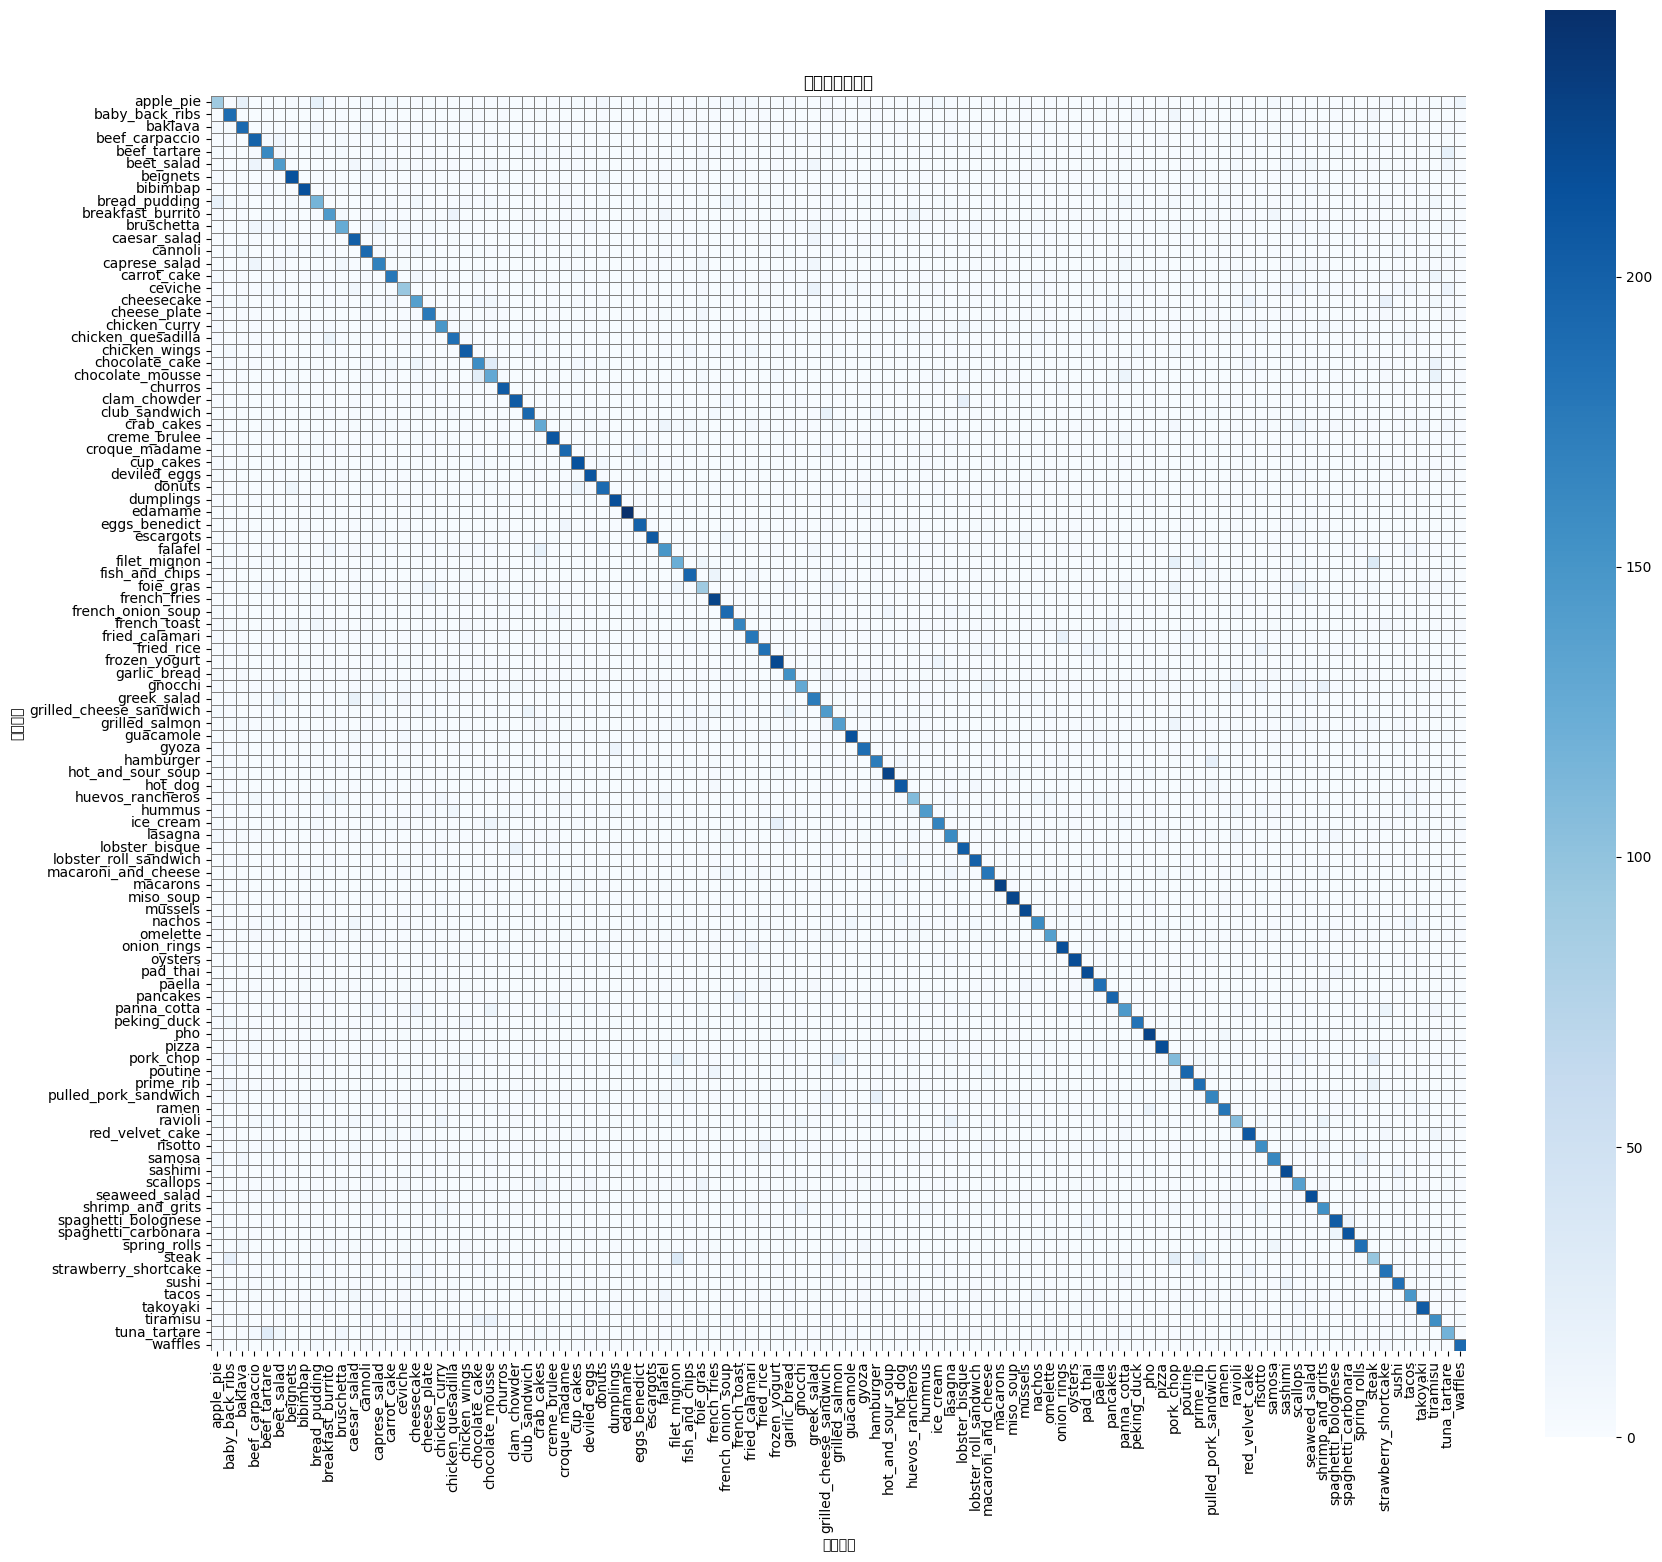

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

# 先收集所有验证集样本的真实标签和预测标签
print("正在生成验证集的预测标签...")

true_labels = []
pred_labels = []

for sample in dataset['validation']:
    image = preprocess_image(np.array(sample['image']))
    image = tf.expand_dims(image, 0)

    pred = model.predict(image, verbose=0)
    pred_label = np.argmax(pred[0])

    true_labels.append(sample['label'])
    pred_labels.append(pred_label)

# 创建混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)

# 如果你只想看前 N 类（可选）
# N = 20
# cm = cm[:N, :N]
# display_labels = food_classes[:N]

display_labels = food_classes  # 显示所有类别

# 可视化混淆矩阵（热力图）
plt.figure(figsize=(18, 16))
sns.heatmap(cm, 
            xticklabels=display_labels, 
            yticklabels=display_labels, 
            cmap='Blues', 
            linewidths=0.5, 
            linecolor='gray',
            square=True,
            cbar=True)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('验证集混淆矩阵')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
